# Problem Set: Solar Power Generation Data
Student: Andreas Eppler<br>
Date: 24.02.2022<br>
University: Karlsruhe Institute of Technology (KIT)<br>
Course: Data Driven Engineering 1: Machine Learning for Dynamical Systems

## Outline:
[1. Problem definition: short term solar power generation forecasting](#1-problem-definition-short-term-solar-power-generation-forecasting)<br>
>[1.1 Working principle of a solar power plant](#11-working-principle-of-a-solar-power-plant)<br>
[1.2 Choosing a measure of Loss/Success](#12-choosing-a-measure-of-losssuccess)<br>
[1.3 Libraries](#13-libraries)

[2: Data Exploration and Preparation](#2-data-exploration-and-preparation)<br> 
>[2.1: Data Exploration](#21-data-exploration)<br> 
[2.2 Data Preparation](#22-data-preparation)<br> 
[2.3 Correlations](#23-correlations)

[3. Testing Phase I: Baseline Models](#3-testing-phase-i-baseline-models)<br>
>[3.1 Autoregression](#31-autoregression)<br>
[3.2 SARIMAX Model](#32-sarimax-model)<br>
[3.3 Baseline Model](#33-baseline-model)<br>
[3.4 SVM](#34-svm)<br>
[3.5 Bayesian Ridge Regression](#35-bayesian-ridge-regression)<br>
[3.6 Elastic Net](#36-elastic-net)

[4. Testing Phase II: Model Development](#4-testing-phase-2-model-development)<br>
>[4.1 Simple Neural Network](#41-simple-neural-network)<br>
[4.2 LSTM](#42-lstm)

[5. Evaluation of the model predictions](#5-evaluation-of-the-model-predictions)

[6. Lessons learn and conclusions](#6-lessons-learnt-and-conclusions)

# 1: Problem definition: short term solar power generation forecasting
Data taken from: https://www.kaggle.com/anikannal/solar-power-generation-data?select=Plant_2_Weather_Sensor_Data.csv <br>
"The data of the problem set has been gathered at two solar power plants located in India. The data covers a 34 day period. It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. The power generation datasets are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at the plant level with a single array of sensors optimally placed at the plant."

The power grid is a very dynamic system in which the energy producers and consumers must be kept in constant balance. An important indicator for this is the grid frequency. In the European interconnected grid, this is 50 Hz and is synchronous with power generators in power plants. If there is an oversupply of electrical power in the power grid, the power plant turbines experience a higher resistance Torque due to the generator, which means that they have to rotate faster in order to maintain the same power output ($P = M*\omega$ applies). Therefore, the grid frequency decreases. In the case of undersupply, the opposite is true. If the grid frequency falls below or exceeds a critical value, the power plants must be taken off the grid, otherwise cavitation could occur and damage the turbine blades. For further explanations, see https://en.wikipedia.org/wiki/Utility_frequency <br>
In order to limit the effects of climate change, it is essential to get to net zero carbon emissions in the upcoming decade(s). Rewenable energy will be the driving force behind that transition away from fossile fuels. <br>
Due to the nature of solar and wind power, the energy grid will need to be way more dynamically regulated in the coming years. Being able to forecast renewable energy production for the next couple of days will be a huge help to regulate the grid via storage solutions such as pumped-storage power plants, home storage systems, hydrogen electrolysers and electric cars with bidirectional charging capability. This will allow to enable a stable, prosumer driven grid.
>In this notebook, the goal is to examine the forecasting possibilities of different Machine Learning Models in the scope of this data set.

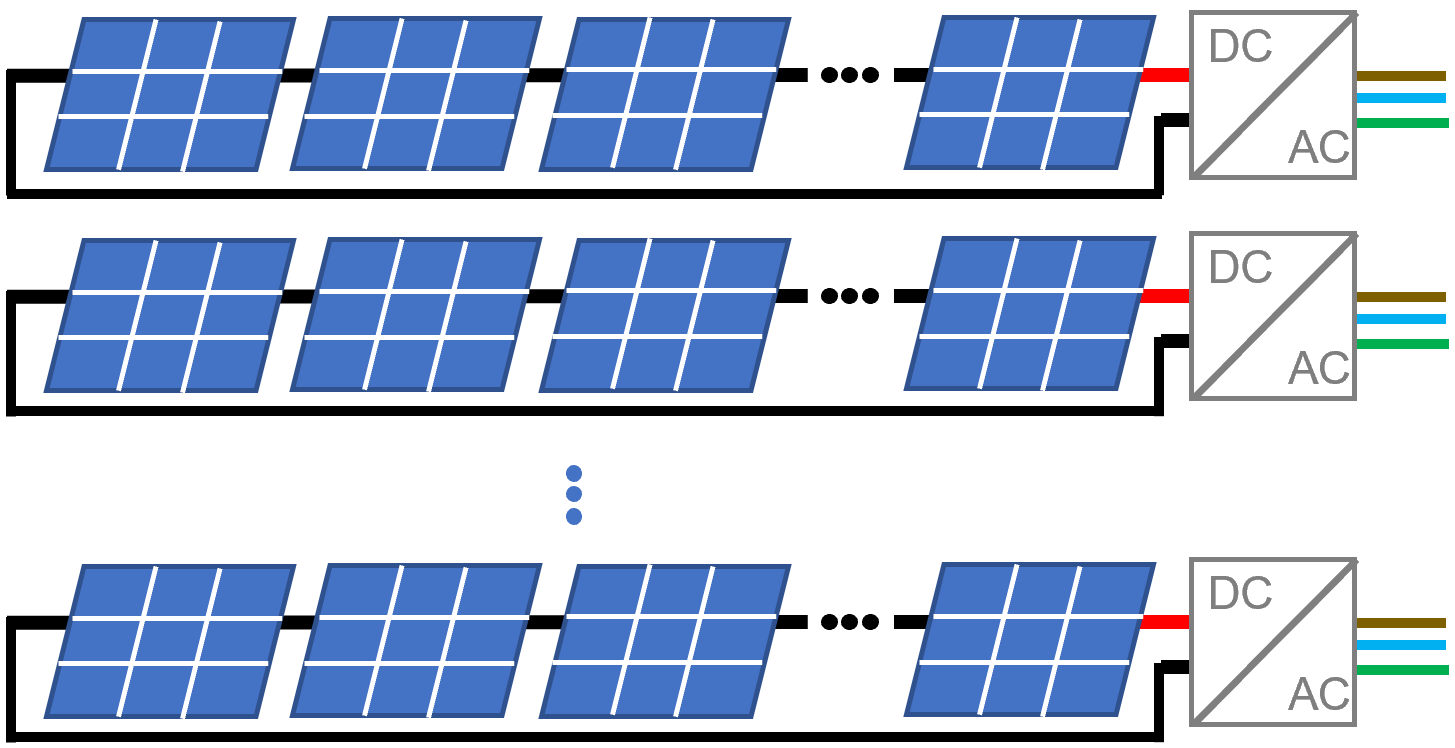

In [1]:
from IPython.display import Image
Image(data="solar_power_plant.png", embed =True, width = 700)
# self-created image of a solar power plant

#### 1.1 working principle of a solar power plant
>The self-created image shows the basic build of a solar power plant. Rows of modules are wired together and then connected to an inverter, that transforms the DC current to an AC current in order to feed the energy into the electric grid. The single modules can either be wired together with a parallel or series connection (as shown in the above image). 
There are advantages and disadvantages to both the interconnection options.
>- In a series connection, the current stays the same while the voltage is increased with each module. This allows for easy wiring. However, if only one of the modules is faulty or produces a lower current due to shading, the current and with that, the power of the whole installation decreases. 
>- With a parallel connection, the voltage remeains persistent while the current of the modules is added up. With it, shading and faulty modules are less of a problem. However, faulty modules are also harder to detect. Due to the larger currents, the wiring requires more effort and is more expensive.

source: https://www.solaranlage.eu/photovoltaik/technik-komponenten/wechselrichter/konzepte-zur-verschaltung

#### 1.2 Choosing a measure of Loss/Success:

since power forcasting is a regression task, the following are the most common measures of loss / success that we can use:
* mean squared error $MSE = \sum_{i=1}^{N}(y_i-\hat{y_i})^2$ with $y = y_{true}$, $\hat{y} = y_{predicted}$

* mean absolute error $MAE = \sum_{i=1}^{N}|y_i-\hat{y_i}|$

* mean absolute percentage error $MAPE = \frac{100\%}{N}\sum_{i=1}^{N}\frac{y_i-\hat{y_i}}{y_i}$

* Coefficient of determination $R² = \frac{\sum_{i=1}^{N}(\hat{y_i}-\bar{y})^2} {\sum_{i=1}^{N}(y_i-\bar{y})^2}$ with $\bar{y} = \frac{1}{N}\sum_{i=1}^{N}y_i$
>We cannot use MAPE since the error goes to infinity for y_true values of zero of which exist a lot in this dataset since the power is zero during nighttime hours.<br>
We will use the R² error for evaluation of model performance since it is a very intuitive error.<br>
We will further also use MAE for evaluation of model performance as it possesses the predictor units and is therefore natural to understand<br>
As a loss quantity for model training and hyperparameter optimization, we will use MSE, as it penalizes outliers more heavily than MAE, which often leads to faster training and less noisy predictions.

## 1.3 Libraries

>Implementation of all the libraries used in this project

In [2]:
%pip install ipython-autotime
%load_ext autotime

Note: you may need to restart the kernel to use updated packages.
time: 0 ns (started: 2022-04-23 17:24:37 +02:00)


We will use optuna for hyperparameter tuning so let´s first install it.

In [3]:
!python -m pip install --user optuna

time: 4.69 s (started: 2022-04-23 17:24:38 +02:00)


In [4]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import matplotlib.dates as mdates
hour_minutes = mdates.DateFormatter('%H:%M')
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import DateOffset

time: 11.4 s (started: 2022-04-23 17:24:43 +02:00)


In [5]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import optuna as op
from optuna.visualization.matplotlib import plot_optimization_history

time: 3.88 s (started: 2022-04-23 17:24:56 +02:00)


In [6]:
# ML Algorithms to be used

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge, ElasticNet, LinearRegression
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__

'2.2.0'

time: 10.9 s (started: 2022-04-23 17:25:02 +02:00)


# 2: Data Exploration and Preparation

## 2.1 Data Exploration

>In the following, for the sake of improved clarity, only the second solar power plant is being investigated. Provided underneath is the option to switch to the first power plant for reasons of boundless curiosity. The code is executable for both the plants. However, please note that the comments and selected parameters only make sense for the second plant.

In [7]:
# plant_no = 1
plant_no = 2

time: 0 ns (started: 2022-04-23 17:25:14 +02:00)


### 2.1.1 Plant Data:

In [8]:
gen_data = pd.read_csv(f'Plant_{plant_no}_Generation_Data.csv')
gen_data

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0       5/15/2020 0:00   4136001  4UPUqMRk7TRMgml       0.0       0.0   
1       5/15/2020 0:00   4136001  81aHJ1q11NBPMrL       0.0       0.0   
2       5/15/2020 0:00   4136001  9kRcWv60rDACzjR       0.0       0.0   
3       5/15/2020 0:00   4136001  Et9kgGMDl729KT4       0.0       0.0   
4       5/15/2020 0:00   4136001  IQ2d7wF4YD8zU1Q       0.0       0.0   
...                ...       ...              ...       ...       ...   
67693  6/17/2020 23:45   4136001  q49J1IKaHRwDQnt       0.0       0.0   
67694  6/17/2020 23:45   4136001  rrq4fwE8jgrTyWY       0.0       0.0   
67695  6/17/2020 23:45   4136001  vOuJvMaM2sgwLmb       0.0       0.0   
67696  6/17/2020 23:45   4136001  xMbIugepa2P7lBB       0.0       0.0   
67697  6/17/2020 23:45   4136001  xoJJ8DcxJEcupym       0.0       0.0   

       DAILY_YIELD   TOTAL_YIELD  
0      9425.000000  2.429011e+06  
1         0.000000  1.215279e+09  
2      3075.333333  2.247720e+09  
3       269.933333  1.704250e+06  
4      3177.000000  1.994153e+07  
...            ...           ...  
67693  4157.000000  5.207580e+05  
67694  3931.000000  1.211314e+08  
67695  4322.000000  2.427691e+06  
67696  4218.000000  1.068964e+08  
67697  4316.000000  2.093357e+08  

[67698 rows x 7 columns]

time: 218 ms (started: 2022-04-23 17:25:15 +02:00)


There are seven columns for both the data sets consisting of the plant id (same for the entire dataset), the id of each inverter (source_key), AC- and DC-power, daily yield and total yield. From kaggle, we take the following information:
1. DATE_TIME:   Date and time for each observation. Observations recorded at 15 minute intervals.
2. PLANT_ID:    Plant ID - this will be common for the entire file. ***(can therefore be deleted)***
3. SOURCE_KEY:  Source key in this file stands for the inverter id.
4. DC_POWER:    Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. ***(explanation makes no sense, since power over a time interval would be energy, so it´s probably the average power during that interval. Also, it should be power generated by the modules connected to one inverter)***
5. AC_POWER:    Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW. ***(should be average AC power after conversion by the inverter during each 15 minute interval)***
6. DAILY_YIELD: Daily yield is a cumulative sum of power generated on that day, till that point in time. ***(This is probably energy in kWh, not power, explanation for this assumption can be found later)***
7. TOTAL_YIELD: This is the total yield for the inverter till that point in time.

### 2.1.2 Weather Data:

In [9]:
weather_data = pd.read_csv(f'Plant_{plant_no}_Weather_Sensor_Data.csv')
weather_data

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0     2020-05-15 00:00:00   4136001  iq8k7ZNt4Mwm3w0            27.004764   
1     2020-05-15 00:15:00   4136001  iq8k7ZNt4Mwm3w0            26.880811   
2     2020-05-15 00:30:00   4136001  iq8k7ZNt4Mwm3w0            26.682055   
3     2020-05-15 00:45:00   4136001  iq8k7ZNt4Mwm3w0            26.500589   
4     2020-05-15 01:00:00   4136001  iq8k7ZNt4Mwm3w0            26.596148   
...                   ...       ...              ...                  ...   
3254  2020-06-17 22:45:00   4136001  iq8k7ZNt4Mwm3w0            23.511703   
3255  2020-06-17 23:00:00   4136001  iq8k7ZNt4Mwm3w0            23.482282   
3256  2020-06-17 23:15:00   4136001  iq8k7ZNt4Mwm3w0            23.354743   
3257  2020-06-17 23:30:00   4136001  iq8k7ZNt4Mwm3w0            23.291048   
3258  2020-06-17 23:45:00   4136001  iq8k7ZNt4Mwm3w0            23.202871   

      MODULE_TEMPERATURE  IRRADIATION  
0              25.060789          0.0  
1              24.421869          0.0  
2              24.427290          0.0  
3              24.420678          0.0  
4              25.088210          0.0  
...                  ...          ...  
3254           22.856201          0.0  
3255           22.744190          0.0  
3256           22.492245          0.0  
3257           22.373909          0.0  
3258           22.535908          0.0  

[3259 rows x 6 columns]

time: 62 ms (started: 2022-04-23 17:25:16 +02:00)


In [10]:
weather_data["SOURCE_KEY"][0] in gen_data["SOURCE_KEY"]

False

time: 15 ms (started: 2022-04-23 17:25:16 +02:00)


The above code shows that the weather sensor source key is not in the list of inverter ids

We can see that the weather data covers the same period of time and is taken at the same plant (similar plant id). The data covers the ambient temperature, module temperature and the irradiation, which will be really helpful for time series prediction. 
Irradiation and with this the number of photons is directly linked to the energy output of the solar panels while the temperature of a solar module changes the efficiency of the modules. As a general rule, the efficiency of a solar panel declines with increasing temperatures. 
Unfortunately, as checked in the cell above, we don´t know which module the module temperature has been taken at but for the further analysis let´s assume that the temperature reading is representative for all the modules.
The temperature seems to be taken in degrees Celsius.
1. DATE_TIME: Date and time for each observation. Observations recorded at 15 minute intervals.
2. PLANT_ID: Plant ID - this will be common for the entire file. ***(can therefore be deleted)***
3. SOURCE_KEY: Stands for the sensor panel id. This will be common for the entire file because there's only one sensor panel for the plant. ***(can therefore be deleted)***
4. AMBIENT_TEMPERATURE: This is the ambient temperature at the plant. ***(most likely in °C)***
5. MODULE_TEMPERATURE: There's a module (solar panel) attached to the sensor panel. This is the temperature reading for that module. ***(most likely in °C)***
6. IRRADIATION: Amount of irradiation for the 15 minute interval.

### 2.1.3 checking for missing data

In [11]:
print(gen_data.info())
print(weather_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    67698 non-null  object 
 1   PLANT_ID     67698 non-null  int64  
 2   SOURCE_KEY   67698 non-null  object 
 3   DC_POWER     67698 non-null  float64
 4   AC_POWER     67698 non-null  float64
 5   DAILY_YIELD  67698 non-null  float64
 6   TOTAL_YIELD  67698 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3259 non-null   object 
 1   PLANT_ID             3259 non-null   int64  
 2   SOURCE_KEY           3259 non-null   object 
 3   AMBIENT_TEMPERATURE  3259 non-null   float64
 4   MODULE_TEMPERATURE   3259 non-null  

>Fortunately, the data seems to contain no null object values that need to be dealt with. However, a period of 34 days should cover 34x24x4= 3264 values, so there seem to be some missing time steps.

Let´s first convert the date and time information to represent the indices of our data frame.

In [12]:
dt_gen, dt_weather = 0, 0
if plant_no == 1:
    dt_gen = pd.to_datetime(gen_data["DATE_TIME"], format='%d-%m-%Y %H:%M').values
    dt_weather = pd.to_datetime(weather_data["DATE_TIME"], format='%Y-%m-%d %H:%M:%S').values
if plant_no == 2:
    dt_gen = pd.to_datetime(gen_data["DATE_TIME"], format='%m/%d/%Y %H:%M').values
    dt_weather = pd.to_datetime(weather_data["DATE_TIME"], format='%Y-%m-%d %H:%M:%S').values
gen_data=(gen_data.set_index(pd.DatetimeIndex(dt_gen))).drop(['DATE_TIME', 'PLANT_ID'],axis=1)
weather_data=(weather_data.set_index(pd.DatetimeIndex(dt_weather))).drop(['DATE_TIME', 'PLANT_ID','SOURCE_KEY'],axis=1)

time: 63 ms (started: 2022-04-23 17:25:18 +02:00)


With this, we can now check for missing sonsor readings. To accomplish this, a list of all 15 minute intervals between the first and last time step is created and compared with the datetime lists of the dataframe. The resulting number of inverter readings per time step is stored in a dictionary

In [13]:
dt_list = np.arange(dt_gen[0], dt_gen[-1]+np.timedelta64(15, 'm'), np.timedelta64(15, 'm')).astype('datetime64[m]').tolist()  
dt_gen_dict = dict(zip(dt_list, [0]*len(dt_list)))
dt_weather_dict = dict(zip(dt_list, [0]*len(dt_list)))
counter = 0

for datetime in dt_list:
    while counter < len(dt_gen) and dt_gen[counter].astype('datetime64[m]') == datetime:
        dt_gen_dict[datetime] += 1
        counter += 1

counter=0
for datetime in dt_list:
    if dt_weather[counter].astype('datetime64[m]') == datetime:
        dt_weather_dict[datetime] += 1
        counter += 1

time: 2.03 s (started: 2022-04-23 17:25:19 +02:00)


In [14]:
panel_lst = gen_data["SOURCE_KEY"].unique()
print(f"total number of inverters: {len(panel_lst)}")
# for p in panel_lst:
#     print(gen_data.loc[gen_data["SOURCE_KEY"] == p].shape[0], end = " ")

total number of inverters: 22
time: 16 ms (started: 2022-04-23 17:25:22 +02:00)


As found out above, the total number of inverters is 22. Now let´s find all the time slots where the number of inverter readings stored in the data differs from the total number of inverters:

In [15]:
tmp = dt_list[0]
for p in dt_list:
    if dt_gen_dict[tmp] != dt_gen_dict[p]:
        if dt_gen_dict[tmp] != len(panel_lst):
            print(f"from {tmp} to {p}, delta = {p-tmp} {dt_gen_dict[tmp]} inverter readings")
        tmp = p
correction_list = [s for s in dt_gen_dict if dt_gen_dict[s]!=22 and dt_gen_dict[s]!=0]

from 2020-05-15 23:15:00 to 2020-05-15 23:30:00, delta = 0:15:00 0 inverter readings
from 2020-05-19 16:00:00 to 2020-05-19 16:15:00, delta = 0:15:00 0 inverter readings
from 2020-05-19 22:15:00 to 2020-05-20 14:15:00, delta = 16:00:00 12 inverter readings
from 2020-05-20 22:00:00 to 2020-05-29 16:00:00, delta = 8 days, 18:00:00 18 inverter readings
from 2020-05-29 16:00:00 to 2020-05-29 16:15:00, delta = 0:15:00 0 inverter readings
from 2020-06-01 17:45:00 to 2020-06-01 18:00:00, delta = 0:15:00 0 inverter readings
from 2020-06-03 14:00:00 to 2020-06-03 14:15:00, delta = 0:15:00 0 inverter readings
time: 0 ns (started: 2022-04-23 17:25:23 +02:00)


>This does not look too bad. There are only five occurances where all inverter sensor readings failed at once, whilst only for one 15 minute time step. This will be of no concern for the later investigation. What is even better, as can be seen below, the missing inverter sensor reading times are similar to the missing weather sensor reading times. The two time windows of concern however, are the ones with only 12 / 18 inverter readings, as those would later lead to erroneous training data, if left uncorrected. It is unclear if the data is missing due to malfunctioning sensors or because the solar module did not work during that period of time.

In [16]:
tmp = dt_list[0]
for p in dt_list:

    if dt_weather_dict[tmp] != dt_weather_dict[p]:
        if dt_weather_dict[tmp] == 0:
            print(f"from {tmp} to {p}, delta = {p-tmp} no sensor data available")
        tmp = p

from 2020-05-15 23:15:00 to 2020-05-15 23:30:00, delta = 0:15:00 no sensor data available
from 2020-05-19 16:00:00 to 2020-05-19 16:15:00, delta = 0:15:00 no sensor data available
from 2020-05-29 16:00:00 to 2020-05-29 16:15:00, delta = 0:15:00 no sensor data available
from 2020-06-01 17:45:00 to 2020-06-01 18:00:00, delta = 0:15:00 no sensor data available
from 2020-06-03 14:00:00 to 2020-06-03 14:15:00, delta = 0:15:00 no sensor data available
time: 0 ns (started: 2022-04-23 17:25:24 +02:00)


### 2.1.4 plotting the data:

For the correction, we will now find out wether the missing inverter data is also influencing the daily, as well as the total yield. For this purpose, let´s plot them:

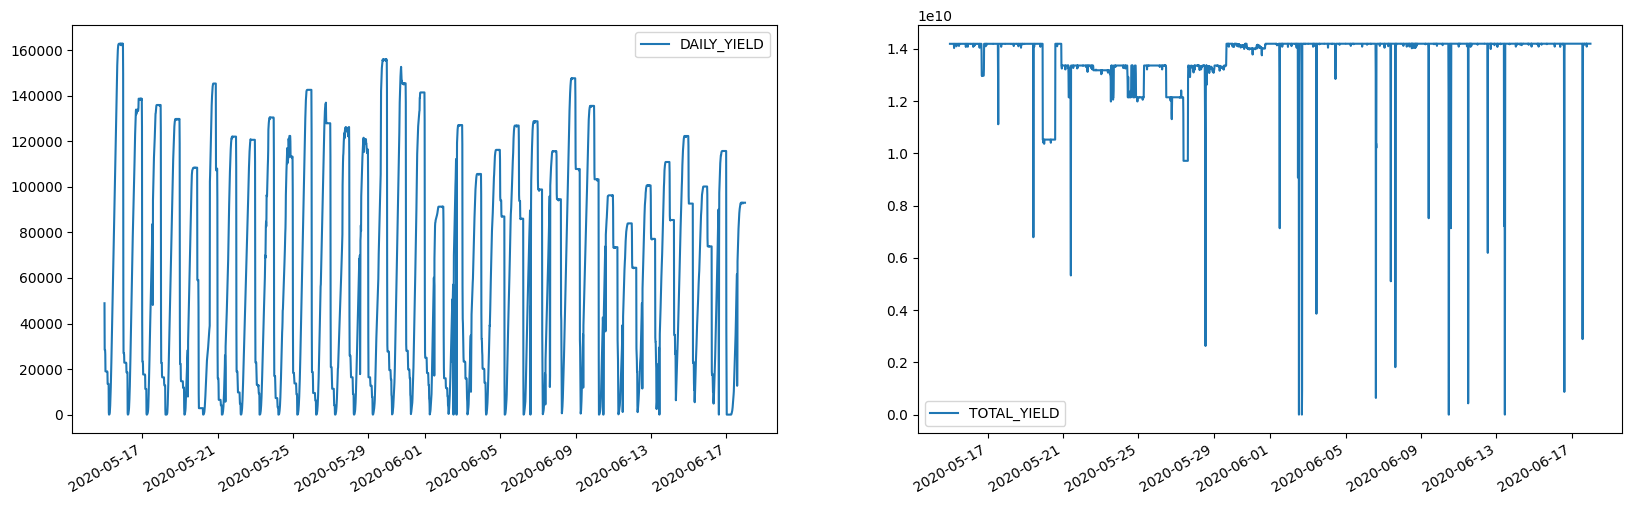

time: 985 ms (started: 2022-04-23 17:25:25 +02:00)


In [17]:
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
gen_data_inv_sum = gen_data.groupby(gen_data.index).sum()
gen_data_inv_sum.plot(y = 'DAILY_YIELD', ax = ax[0])
gen_data_inv_sum.plot(y = 'TOTAL_YIELD', ax = ax[1]);

>Looking at the plots, we can see that there seem to exist a lot of erroneous data points, both for the daily yield as well as the total yield. The daily yield should as per definition be zero at 0:00, increase over each day according to each day´s AC-power production and then drop straight to zero again at 0:00. This is not at all what the plot describes for most days. The total yield looks also really bad. According to its definition, it should only ever increase, which it clearly does not. If we switch to plant 1, we see that the plots look a lot more as expected, but still contain a lot of errors. <br>
Let´s check, wether all the data is as erroneous. Following, you can find plots of the other parameters, plotted as point plots over a single day:

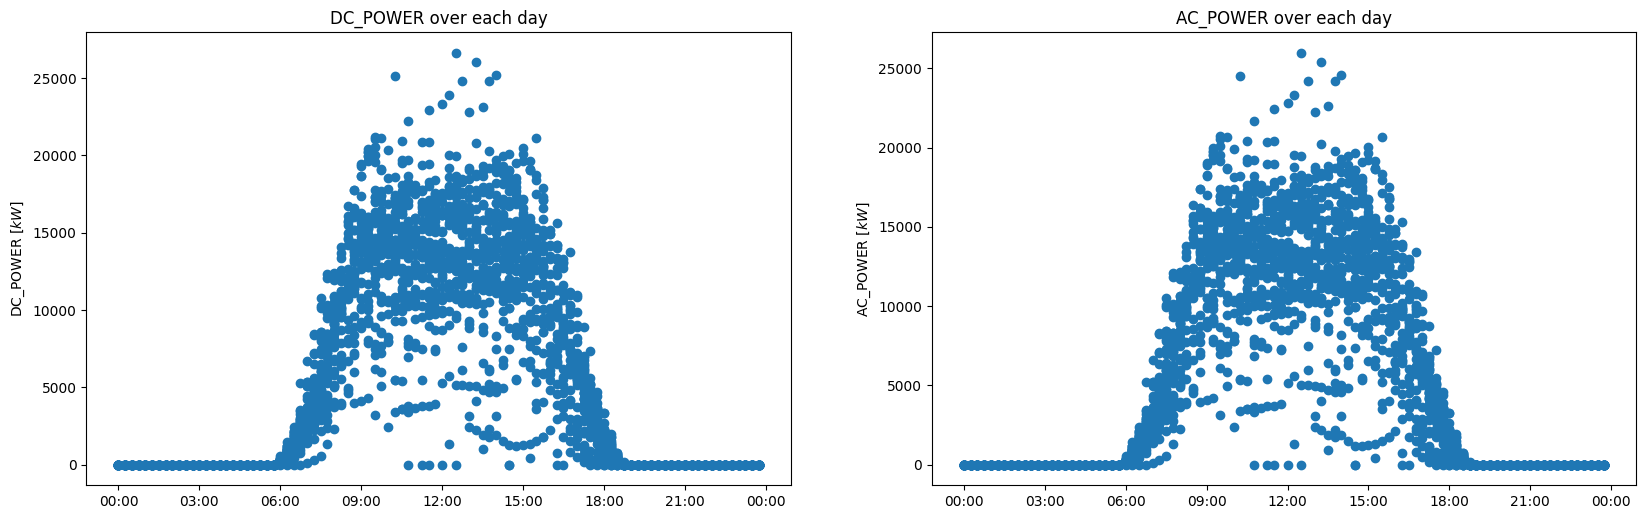

time: 1.7 s (started: 2022-04-23 17:25:27 +02:00)


In [18]:
def plot_ac_dc_power(df):
    fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
    for i, name in enumerate(['DC_POWER', 'AC_POWER']):
        ax[i].scatter([dt.datetime.combine(dt.date(2020,1,1), t) for t in df.index.time], df[name])
        ax[i].set_ylabel(f'{name} $[kW]$')
        ax[i].set_title(f"{name} over each day")
        ax[i].xaxis.set_major_formatter(hour_minutes)

plot_ac_dc_power(gen_data_inv_sum)

>Luckily, this looks a lot better that the daily and total yield. This are the key take-aways:
>- First, we see that the plots look very similar except for a small scaling factor (efficiency of the inverter). As we will see later on in the correlation plot, the relationship is in fact linear. Side note: for plant 1, the AC power is around 10.3 times smaller than the DC power, so the efficiency would be around 9.7%, which would be really bad. There seems to be a scaling error of one decimal point for the DC power, since all the other data (daily yield, total yield, ac power) is consistent. 
>- It makes sense that during nighttime hours (around 18:00 till 6:00) there is no power production.
>- The power production seems to rise to a certain amount in the morning, then stays pretty consistent over the day and falls in the evening (looking a little like a capped gaussian distribution)
>- There are some data points where the power production is zero over the day even though the irradiation isn´t (as can be seen below). These data points are only over one 15 minute interval so it seems unlikely, that this is due to repairs / other. Probably, these are errors in the data that need to be fixed.

In [19]:
#efficiency of the inverter:
np.mean(gen_data_inv_sum['AC_POWER']/gen_data_inv_sum['DC_POWER'])

0.9766987572557135

time: 31 ms (started: 2022-04-23 17:25:30 +02:00)


According to https://understandsolar.com/solar-inverter-efficiency/, this is actually top notch. Also, we find out that the inverters are probably from SMA Solar or SolarEdge.

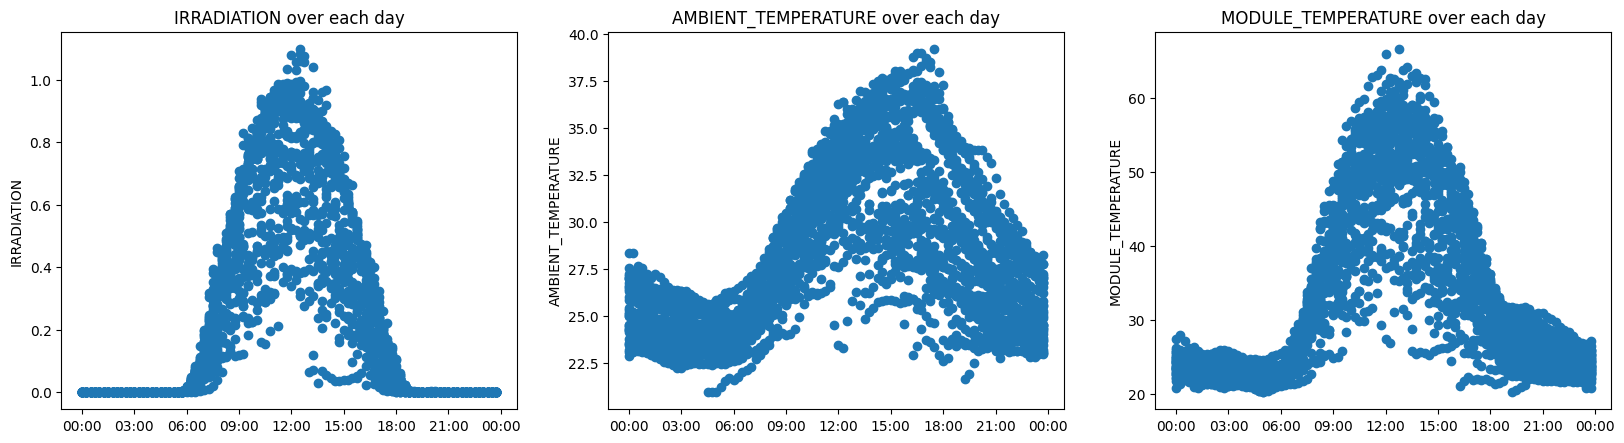

time: 1.08 s (started: 2022-04-23 17:25:31 +02:00)


In [20]:
fig,ax = plt.subplots(ncols=3,nrows=1, dpi=100,figsize=(20,5))
for i, name in enumerate(['IRRADIATION','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE']):
    ax[i].scatter([dt.datetime.combine(dt.date(2020,1,1), t) for t in weather_data.index.time], weather_data[name])
    ax[i].set_ylabel(f'{name}')
    ax[i].xaxis.set_major_formatter(hour_minutes)
    ax[i].set_title(f"{name} over each day")

Take-aways:
- The weather sensor data looks really clean and consistent. We can see that the irradiation closely matches the power curves without being capped off, while the module temperature is a overlay of the irradiation and the ambient temperature. All this seems to confirm our physical understanding.
- If we tried to match the irradiation data to the sunrise and sunset data of that particular month and the ambient temperature to the climatic conditions, we could probably narrow down where the plant is stationed in india.
- This place gets really hot in summer

## 2.2 Data Preparation

>Now we gained all the insights we need to start correcting the erroneous data. The revealed issues will be dealt with as follows:
1. step: The total yield will be deleted as it currently has no identifiable surplus value and can easily be reconstructed from the AC power column which will be way easyer than correcting this mess.
2. step: We will try to use linear regression to correct all the zero power production values during daytime hours
3. step: There are several possible methods to deal with the missing inverter data.
- neglecting the parts of the data set where inverters are missing - waste of a lot of useful data
- interpolation of data for the missing inverters - not feasible since the time spans are by far too large
- summing up the power generation of all the inverters per time step while creating another column with the number of working inverters which would have the benefit that the model would take into account the possibility of inverters being out of service. However, with only two occurances, the training data would be too limited to understand this relationship
- which leads us to the most feasible solution: summing up the power generation of all the inverters per time step and scaling the power production with the total  number of inverters, divided by the functioning inverters. Of course, we cannot assume that all the inverters produce an equal amount of power but the margin of error should be little enough.
4. step: We will create a correct list of the daily yield and replace the column in the data frame from the AC power column

### 2.2.1 Step 1: Dropping the total yield

In [21]:
gen_data = gen_data.drop(['TOTAL_YIELD'], axis = 1)
gen_data_inv_sum = gen_data_inv_sum.drop(['TOTAL_YIELD'], axis = 1)

time: 0 ns (started: 2022-04-23 17:25:33 +02:00)


### 2.2.2: let´s now create a function that enables us to create a corrected list of the daily yield

In [22]:
def create_daily_yield_list(dataframe, ac_power):
    day_list = []
    for i in list(pd.date_range(start=dataframe.index[0], end=dataframe.index[-1], freq='D')):
        day_list.append(i.strftime('%Y-%m-%d'))
    daily_yield = []
    for datetime in day_list:
        tmp = 0
        for idx, row in dataframe.loc[:,datetime].iterrows():
            tmp += row[ac_power]
            daily_yield.append(tmp)
    return daily_yield

gen_data_inv_sum.loc[:,'DAILY_YIELD'] = create_daily_yield_list(gen_data_inv_sum, 'AC_POWER')

time: 516 ms (started: 2022-04-23 17:25:33 +02:00)


>We see that the plot resembles the other plot closely with the errors being correctet. The new plot is scaled by a factor of 4. I can only guess how this factor comes into play. Most likely, the daily yield is in kWh, so the daily yield would be an integral of the power over the day. Since every quaterly average AC power has to be multiplied by $1/4 hr$ to achieve this, the factor would make sense.

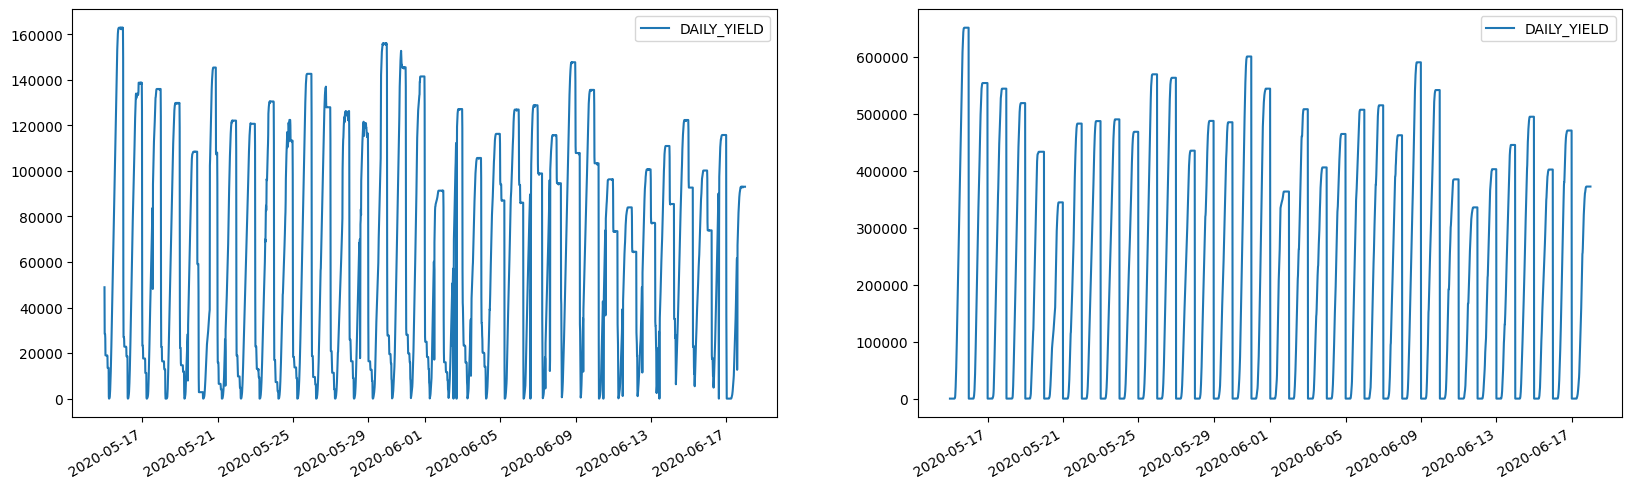

time: 1.02 s (started: 2022-04-23 17:25:35 +02:00)


In [23]:
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
fig.autofmt_xdate()
gen_data.groupby(gen_data.index).sum().plot(y = 'DAILY_YIELD', ax = ax[0])
gen_data_inv_sum.plot(y = 'DAILY_YIELD', ax = ax[1]);

Let´s corect this factor:

In [24]:
gen_data_inv_sum['DAILY_YIELD'] = gen_data_inv_sum['DAILY_YIELD'].apply(lambda x: x/4)
gen_data_inv_sum['DAILY_YIELD'].max()

162859.43416700777

time: 16 ms (started: 2022-04-23 17:25:37 +02:00)


### 2.2.3 Step 2: correcting all zero power production values: 

We will first set all daytime zero values to Null and than use the pandas linear interpolation function to correct those values. We will use conservative assumptions for daytime hours as to not accidentally correct nighttime values.

In [25]:
sunrise = 8
sunset = 17
date_time = pd.DatetimeIndex(gen_data_inv_sum.index.values)
day_ix = (date_time.hour >= sunrise) & (date_time.hour <= sunset)
daytime_zeros = day_ix & (gen_data_inv_sum['AC_POWER'] == 0)
gen_data_inv_sum[daytime_zeros]
for i in range(len(daytime_zeros)):
    if daytime_zeros[i]:
        gen_data_inv_sum.iloc[i,0:2] = None
print(f'number of null objects before interpolation: {gen_data_inv_sum.isnull().sum().sum()}')
gen_data_inv_sum = gen_data_inv_sum.interpolate(limit = 1, method ='linear', limit_direction ='both')
print(f'number of null objects after interpolation: {gen_data_inv_sum.isnull().sum().sum()}')

number of null objects before interpolation: 22
number of null objects after interpolation: 0
time: 46 ms (started: 2022-04-23 17:25:38 +02:00)


We can see that 22 daytime zero values were found and corrected via interpolation. The resulting plot can be seen below.

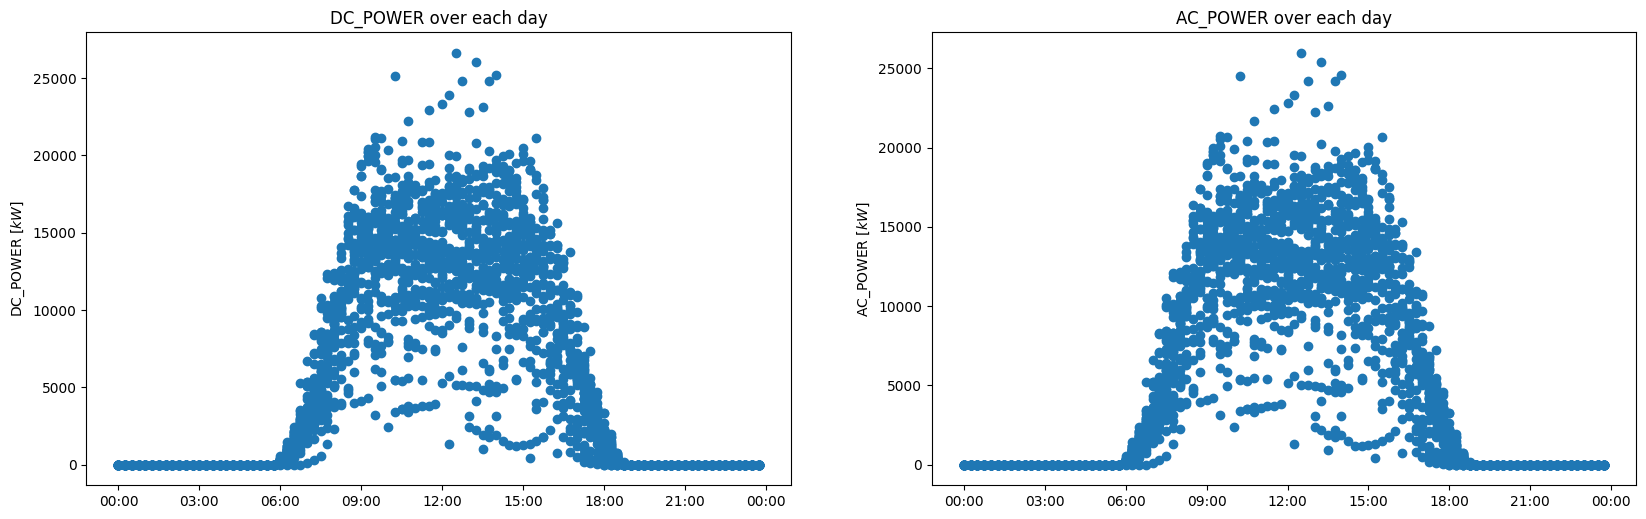

time: 812 ms (started: 2022-04-23 17:25:39 +02:00)


In [26]:
plot_ac_dc_power(gen_data_inv_sum)

### 2.2.4 Step 3: missing inverter data correction

since we know that the irradiation and the AC power are closely linked, let´s use this to check wether our correction makes sense

In [27]:
def plot_daily_yield_and_irradiation(dataframe):
    df_daily_mean = dataframe.groupby(dataframe.index.date).mean()
    fig,ax = plt.subplots(dpi=100,figsize=(10,6))

    plt.ioff()
    plt.grid()
    fig.autofmt_xdate()
    ax.plot(df_daily_mean['IRRADIATION'], label="irradiation", color="b")
    ax.set_ylabel("irradiation",color="b")
    ax2=ax.twinx()
    ax2.plot(df_daily_mean['AC_POWER'], color="g")
    for x, date in enumerate(list(set([d.date() for d in correction_list]))):
        if x!= 0:
            if x==1:
                ax2.plot(df_daily_mean['AC_POWER'][tmp:date], label="missing inverter data corrected", color="r")
            else:
                ax2.plot(df_daily_mean['AC_POWER'][tmp:date], color="r")
        tmp = date
    ax2.set_ylabel(f'AC power $[kW]$', color="g")
    ax2.legend(loc='upper right', shadow=False, fancybox=False, facecolor='white', edgecolor='black')
    ax2.set_title("average daily AC power and irradiation")

time: 0 ns (started: 2022-04-23 17:25:40 +02:00)


This is how the plots look prior to the correction. As predicted, we notice a close correlation for all but the time span with the missing inverter data.

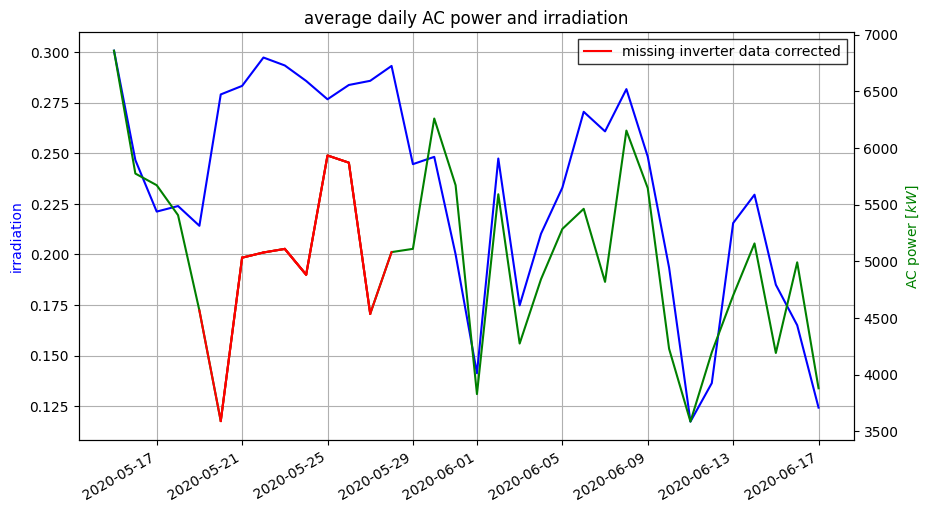

time: 719 ms (started: 2022-04-23 17:25:41 +02:00)


In [28]:
plot_daily_yield_and_irradiation(pd.merge(gen_data_inv_sum, weather_data, left_index=True, right_index=True))

The scaling correction is performed below. Its success can be seen by the before / after comparison of a time span with missing inverter readings.

In [29]:
tmp = pd.DataFrame(list(dt_gen_dict.items()), columns = ['DATE_TIME','NO_INVERTERS'])
tmp = (tmp.set_index(pd.DatetimeIndex(pd.to_datetime(tmp["DATE_TIME"]).values))).drop(['DATE_TIME'],axis=1)
corrected_df = pd.merge(gen_data_inv_sum, tmp, left_index=True, right_index=True)
print(corrected_df.loc[correction_list[0]])
for datetime in correction_list:
    corrected_df.loc[datetime] = corrected_df.loc[datetime]/dt_gen_dict[datetime]*22
print(corrected_df.loc[correction_list[0]])


DC_POWER             0.00000
AC_POWER             0.00000
DAILY_YIELD     108388.68066
NO_INVERTERS        12.00000
Name: 2020-05-19 22:15:00, dtype: float64
DC_POWER             0.00000
AC_POWER             0.00000
DAILY_YIELD     198712.58121
NO_INVERTERS        22.00000
Name: 2020-05-19 22:15:00, dtype: float64
time: 1.12 s (started: 2022-04-23 17:25:43 +02:00)


From the above example and the plot below, we can see that the correction was successfull and as expected. The correction probably is not perfect but the correlation definitely looks better.

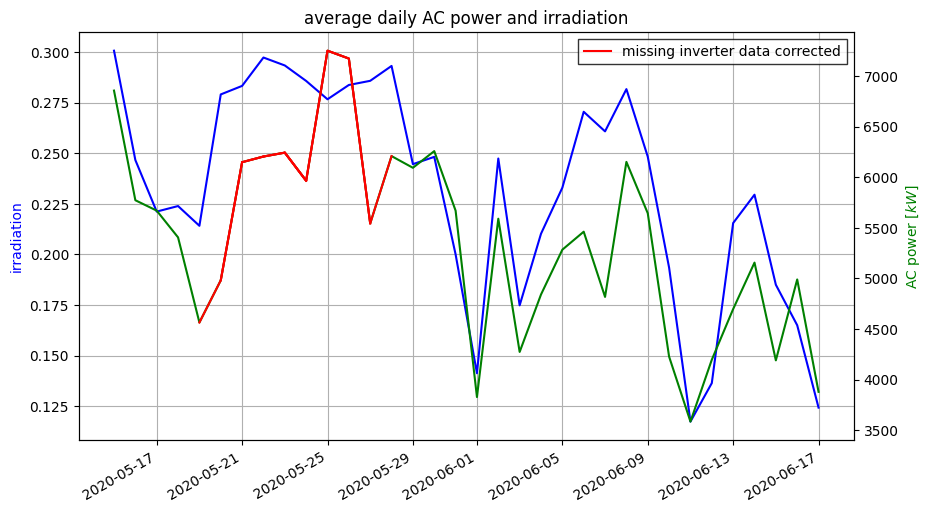

time: 688 ms (started: 2022-04-23 17:25:45 +02:00)


In [30]:
df_plant = pd.merge(corrected_df, weather_data, left_index=True, right_index=True).drop('NO_INVERTERS', axis = 1)
plot_daily_yield_and_irradiation(df_plant)


### 2.2.5 Step 4: Correcting daily yield to update changes made to AC power

We will now use the already created function to create the corrected daily yield column. We had to perform this action after correting the AC power in order to take the changed values into account.

In [31]:
df_plant.loc[:,'DAILY_YIELD'] = create_daily_yield_list(df_plant, 'AC_POWER')
df_plant.loc[:,'DAILY_YIELD'] = df_plant.loc[:,'DAILY_YIELD'].apply(lambda x: x/4)
df_plant.loc[:,'DAILY_YIELD'].max()

174037.18997492545

time: 484 ms (started: 2022-04-23 17:25:46 +02:00)


## 2.3 Correlations

Let´s now take a look at the correlation matrix:

In [32]:
correlationMatrix = pd.DataFrame(df_plant).corr() 
correlationMatrix.style.background_gradient(cmap='viridis').set_precision(2)

time: 234 ms (started: 2022-04-23 17:25:47 +02:00)


There´s a lot of insight to be gained here. 
- DC and AC power are perfectly correlated --> there is a linear relationship of the inverter input to output power with its slope being the efficiency of the inverter. (we already know this)
- Irradiation, AC power, DC power, module temperature and ambient temperature are all correlated closely which makes absolute sense. Broken down, the irradiation directly influences the DC power (minus shadowing and efficiency) and the ambient temperature, while the module temperature is influenced by the ambient temperature and the waste energy of the panels and itself infulences the efficiency
- the daily yield shows correlation with the temperature, not so much with the other values. This makes sense, since looking at the pairplots below, we can see a quadratic relationship.
> This is very valuable information. Our aim is to predict the power generated by the solar plant, so we could either predict the DC power, AC power or the daily yield. We now know that the DC power is the AC power multiplied by the efficiency of the inverter, which we also know. What is more, we can construct the daily yield from the AC power and vice versa. <br> This means that we are theoretically free of choice in what quantity we want to predict. However, if we use the weather data, it allows for smaller models if the underlying relationships are linear instead of quadratic. In those cases, it will be advantageous to predict the AC power in order to save ressources. With that, we also know that linear models should already do a pretty good job at predicting

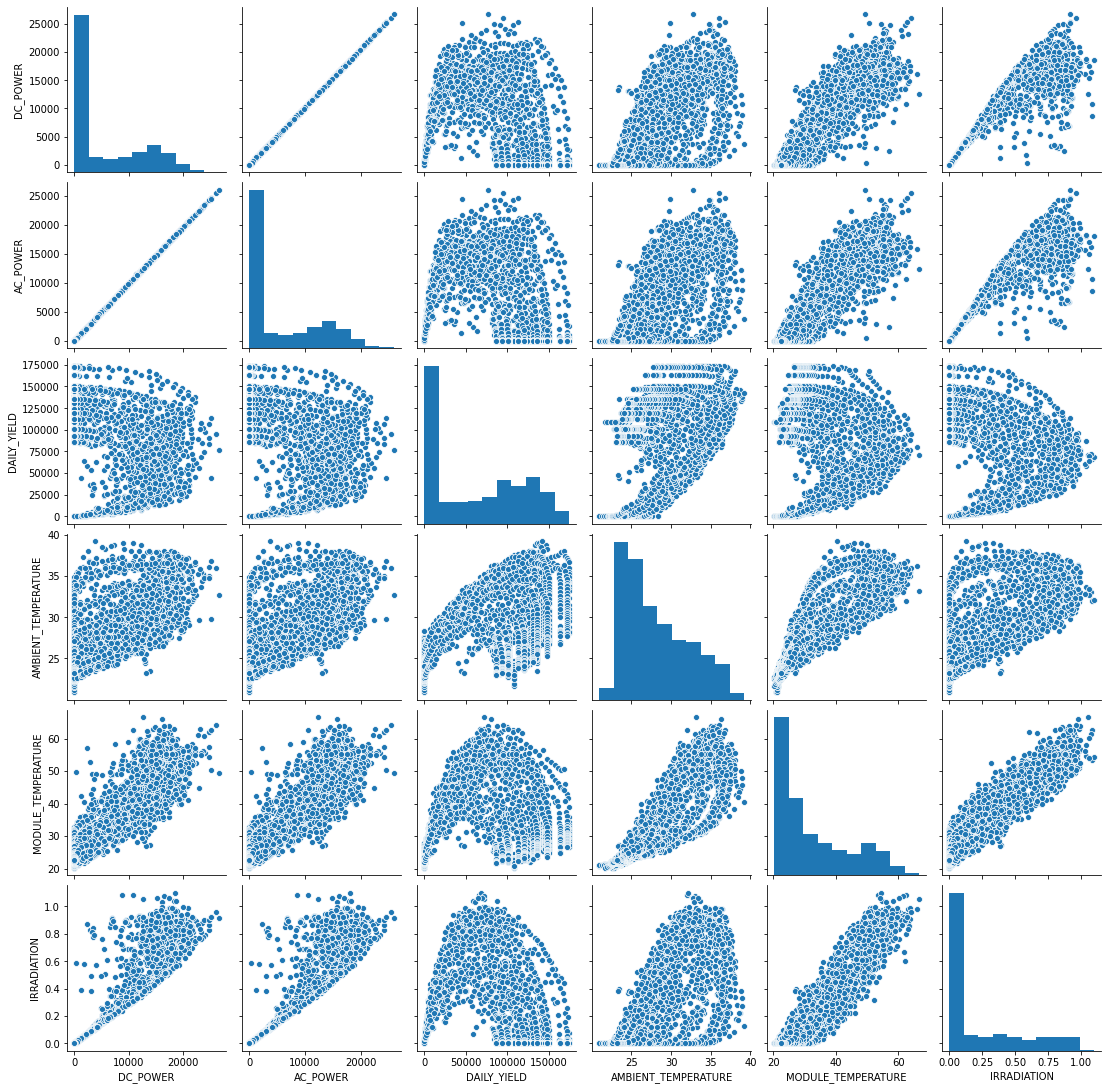

time: 9.84 s (started: 2022-04-23 17:25:48 +02:00)


In [33]:
sns.pairplot(df_plant)
plt.show()

# 3: Testing Phase I: Baseline Models

> since most weather models make hourly forecasts for the next three days at most, and since the reliability of the forecasts decreases significantly after these three days, we will try to predict the solar power generation for a similar period of time. We will do hourly predicitons as this matches the weather model predictions and will reduce model training at least by the factor of 4. For a three-day forecast, there is no need for a higher resolution than 1 hr time steps. For the SARIMAX model, the training time saved is even higher, since the seasonal component appears to have a significant influence on total model training time. Model training with a seasonal factor of 96 was awfully slow.

Since the data is fairly limited in size, it is still possible to switch to observing every quaterhourly time interval in a somewhat reasonal amount of time. Both possibilities are thoroughly implemented and lead to different insights. Please remain using hourly predictions if you want to see quick results. Also, please note that all the comments are implemented for hourly time intervals only.

In [34]:
observe_hourly = True # set this to False in order to observe quaterhourly time intervals (takes a lot more time and memory)

time: 0 ns (started: 2022-04-23 17:25:59 +02:00)


We can group the whole dataframe by its hourly mean values since these are the definitions of the AC power, DC power, Irradiation, ambient and module temperatures. This does not hold true for the daily yield column though. We will therefore recreate it after the grouping.

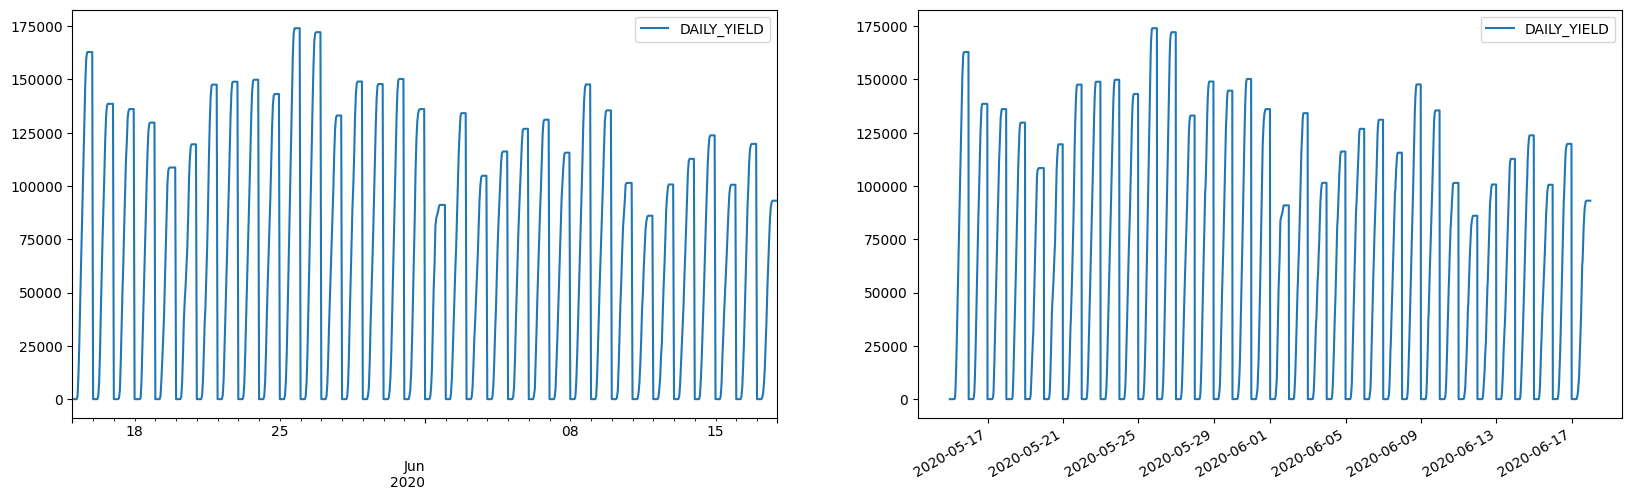

time: 1.5 s (started: 2022-04-23 17:26:00 +02:00)


In [35]:
# grouping our data by hour and creating a new dataframe, checking wether it matches the old
df_plant_hour = df_plant.groupby(pd.Grouper(freq='H')).mean()
df_plant_hour.loc[:,'DAILY_YIELD'] = create_daily_yield_list(df_plant_hour, 'AC_POWER')
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
fig.autofmt_xdate()
df_plant_hour.plot(y = 'DAILY_YIELD', ax = ax[0])
df_plant.plot(y = 'DAILY_YIELD', ax = ax[1]);

>From comparing both the old as well as the new daily yield plots, we can see that our grouping was successful.

## 3.1 Autoregression

### 3.1.1 Seasonal Decomposition

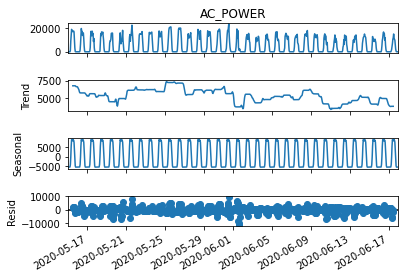

time: 1.48 s (started: 2022-04-23 17:26:03 +02:00)


In [36]:
#Calling our function:
decomposition = seasonal_decompose(df_plant_hour['AC_POWER']["2020-05-15":'2020-06-17'], model = 'additive')
#Plotting:
fig = decomposition.plot()
fig.autofmt_xdate()
# mpl.rcParams['figure.figsize'] = [8.0, 8.0]

There is a clear daily seasonality to observe (daily irradiation), while no clear overall trend can be seen except that it seems to be declining over time.

### 3.1.2 lag plot

>We will compare both possible forecasting values (AC power and daily yield) and see wether one of them is better suited to be predicted with the SARIMAX model without exogenous factors

<Figure size 432x288 with 0 Axes>

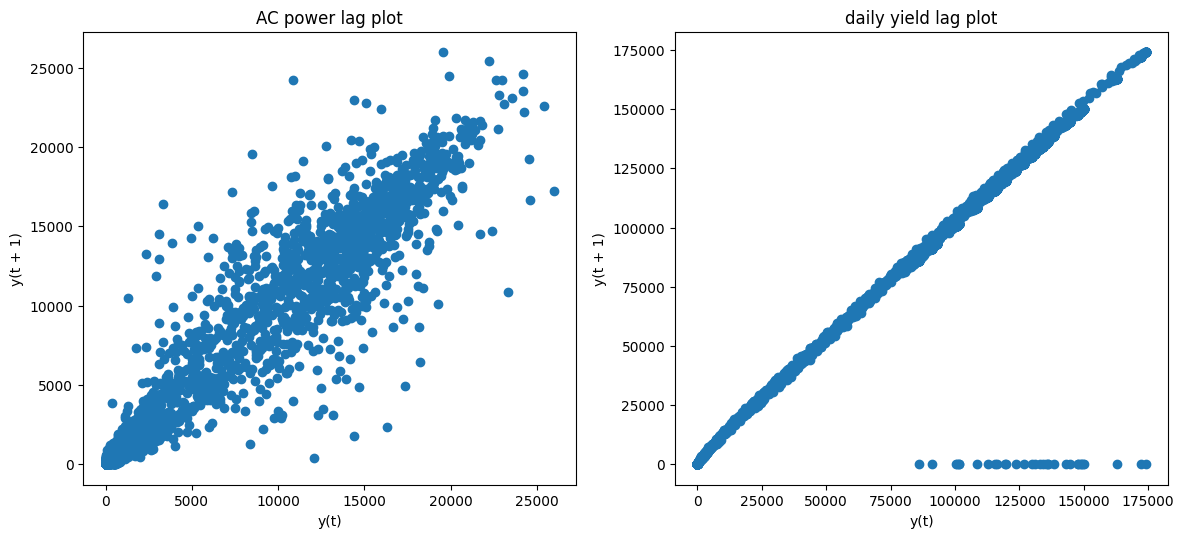

time: 1.08 s (started: 2022-04-23 17:26:05 +02:00)


In [37]:
# Plotting the figure:
plt.figure()
fig,ax = plt.subplots(1,2, dpi=100,figsize=(14,6))
lag_plot(df_plant.loc[:,'AC_POWER'], ax = ax[0], lag=1)
lag_plot(df_plant.loc[:,'DAILY_YIELD'], ax = ax[1], lag=1)
ax[0].set_title('AC power lag plot')
ax[1].set_title('daily yield lag plot');

>We can see that both plots show a clear relationship between two following timesteps with seemingly randomly distributed outliers for the AC power plot. The daily yield lag plot shows a very distinct relationship. This makes sense since because of the incremental addition operation, $y(t+1)$ and $y(t)$ are quite similar. We also see that there are a lot of outliers on the $y(t)$ axis. The outliers can be explained by the fact that each day at 0:00, the daily_yield is set to zero again. This will probably be problematic for our SARIMAX model.

### 3.1.3 autocorrelation plot

<Figure size 432x288 with 0 Axes>

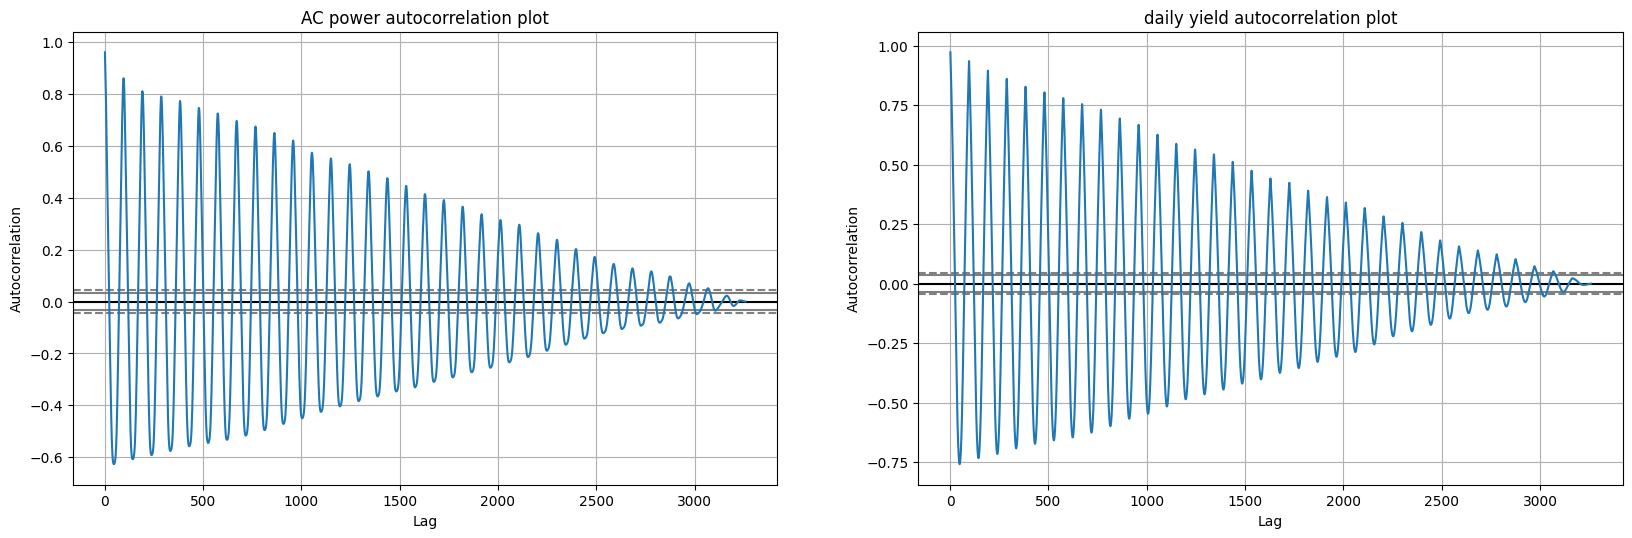

time: 1 s (started: 2022-04-23 17:26:07 +02:00)


In [38]:
plt.figure()
fig, ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
autocorrelation_plot(df_plant.loc[:,'AC_POWER'], ax = ax[0])
autocorrelation_plot(df_plant.loc[:,'DAILY_YIELD'], ax = ax[1])
ax[0].set_title(f'AC power autocorrelation plot')
ax[1].set_title(f'daily yield autocorrelation plot');

>We can see that there is correlation for a lot of the the previous time steps. Interestingly, both the plots look very similar, but since the daily yield is created from the AC power by summating over it, there inevitably is correlation.

>From now on, both the plots look very similar and since we already determined that the AC power is most likely better suited to be predicted, especially with exogenous factors, we will only plot the AC power in the following for the sake of readability.

<Figure size 432x288 with 0 Axes>

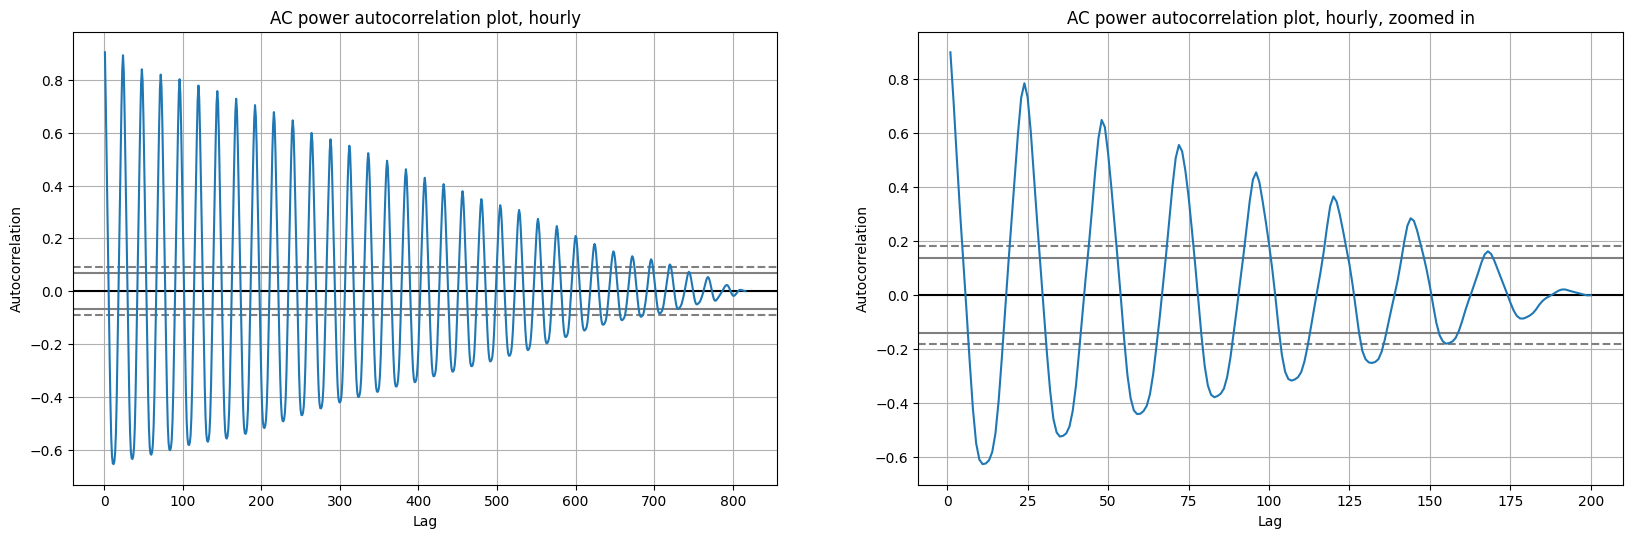

time: 813 ms (started: 2022-04-23 17:26:09 +02:00)


In [39]:
plt.figure()
fig,ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
autocorrelation_plot(df_plant_hour.loc[:,'AC_POWER'], ax = ax[0])
autocorrelation_plot(df_plant_hour.loc[:,'AC_POWER'][0:200], ax = ax[1])
ax[0].set_title('AC power autocorrelation plot, hourly')
ax[1].set_title('AC power autocorrelation plot, hourly, zoomed in');

>If we group the dataframe so that every hour is added up and zoom in, we can see that every 24 hours, the positive correlation is high again, which again makes sense since at this point of time, the sun´s location is almost similar. For the ungrouped dataframe this means that every 24*4=96 time steps, positive correlation is high.

### 3.1.4 Auto Correlation Function

<Figure size 432x288 with 0 Axes>

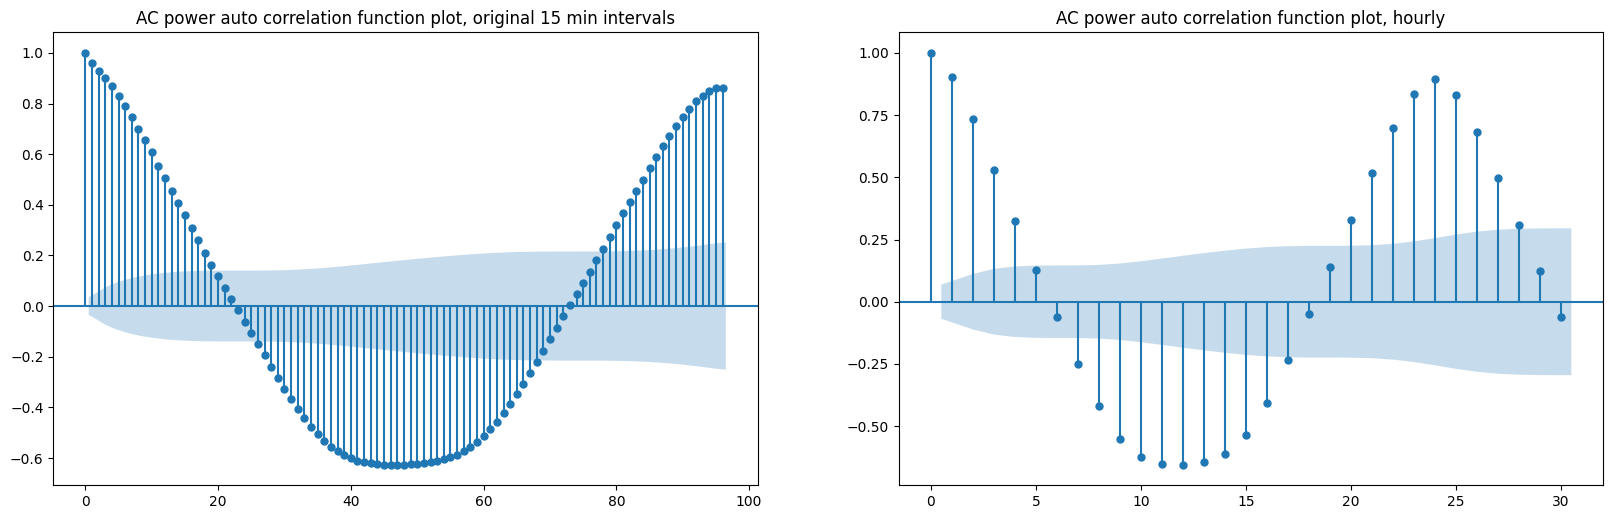

time: 734 ms (started: 2022-04-23 17:26:11 +02:00)


In [40]:
plt.figure()
fig,ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
plot_acf(df_plant.loc[:,'AC_POWER'], ax = ax[0], lags = 24*4)
plot_acf(df_plant_hour.loc[:,'AC_POWER'], ax = ax[1])
ax[0].set_title('AC power auto correlation function plot, original 15 min intervals')
ax[1].set_title('AC power auto correlation function plot, hourly');

>We can see that for the MA parameters of the hourly AC power prediction, 5 lags are beneficial while for the quaterhourly prediction, we can implement up to 20 beneficial lags.

C:\Users\AEppl\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


<Figure size 432x288 with 0 Axes>

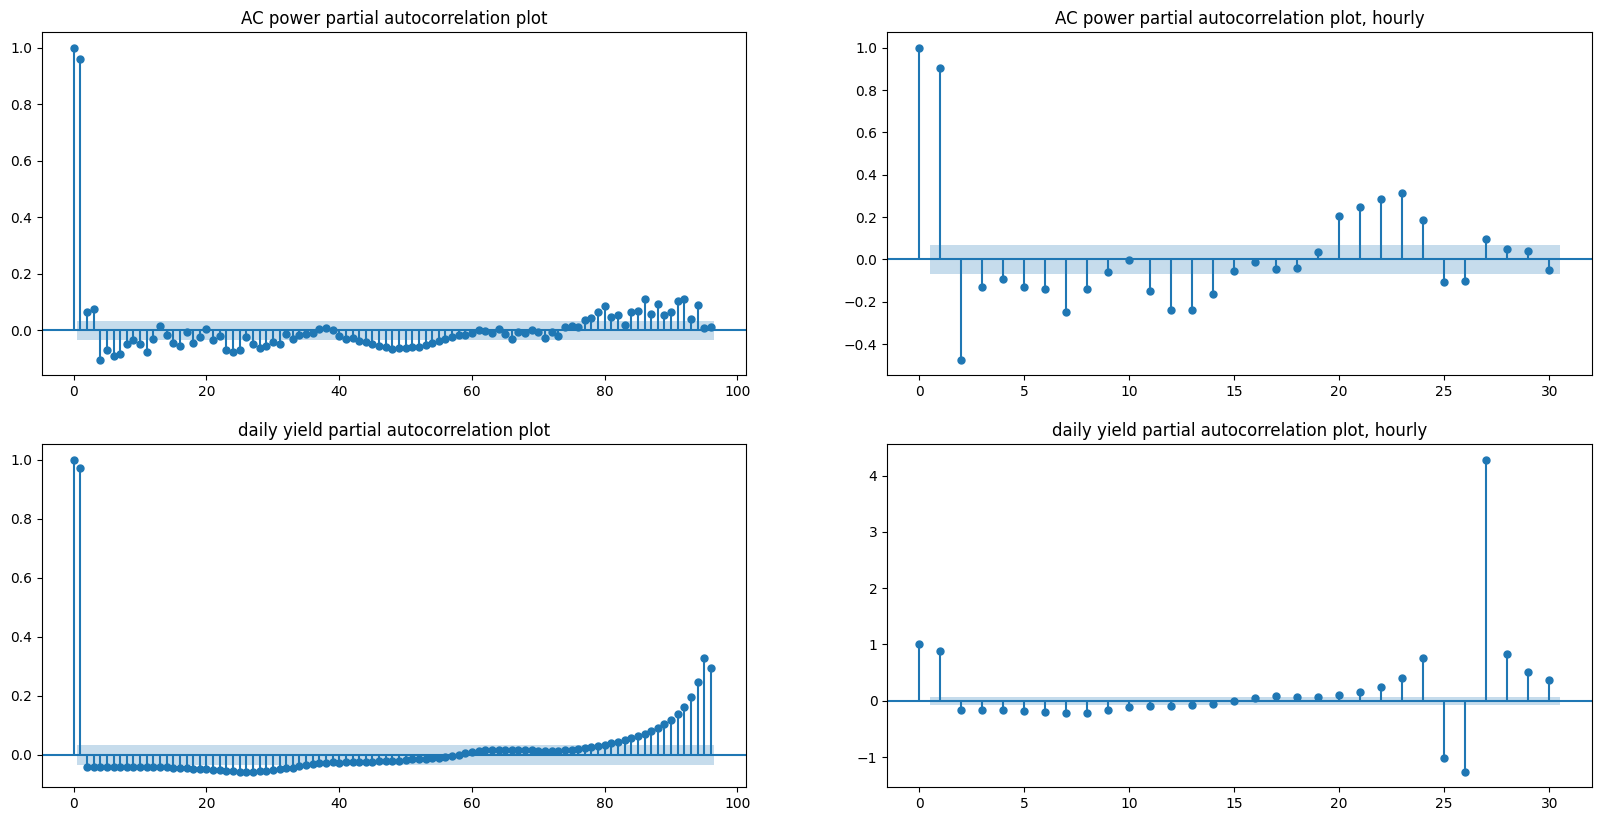

time: 1.86 s (started: 2022-04-23 17:26:12 +02:00)


In [41]:
plt.figure()
fig,ax = plt.subplots(2,2, dpi=100,figsize=(20,10))
plot_pacf(df_plant.loc[:,'AC_POWER'], ax = ax[0][0], lags = 24*4)
plot_pacf(df_plant_hour.loc[:,'AC_POWER'], ax = ax[0][1])
plot_pacf(df_plant.loc[:,'DAILY_YIELD'], ax = ax[1][0], lags = 24*4)
plot_pacf(df_plant_hour.loc[:,'DAILY_YIELD'], ax = ax[1][1])
ax[0][0].set_title('AC power partial autocorrelation plot')
ax[0][1].set_title('AC power partial autocorrelation plot, hourly')
ax[1][0].set_title('daily yield partial autocorrelation plot')
ax[1][1].set_title('daily yield partial autocorrelation plot, hourly');


>We learn that for the hourly AC power forcasting, we could possibly use an AR lag of 8. However, only the first two AR lags shows very high correlation, so another option would be to use an AR lag of two. For the quaterhourly implementation, up to 11 lags could be implemented while only the first lag shows high correlation.

While trying out different things I noticed that for values higher than 24, the hourly daily yield plot shows a weird behaviour (corelation higher than 4), but this seems to have been caused by the underlying mathematical models. https://de.mathworks.com/matlabcentral/answers/122337-wrong-function-partial-autocorrelation-pacf-parcorr-greater-than-1-1

The following code snippet is taken from [medium](https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53). With it, we want to check wether our data is stationary, which it is for values of $p<0.05$. This is important since any time series data that has to be modeled needs to be stationary. Stationary means that its statistical properties are more or less constant with time. This should probably be the case since each day follows a somewhat similar pattern to the days before.

In [42]:
dftest = adfuller(df_plant_hour.AC_POWER, autolag = 'AIC')
print("p-value : ", dftest[1])

p-value :  0.0005845008571331245
time: 93 ms (started: 2022-04-23 17:26:16 +02:00)


>We can observe from the p-value that our data is already stationary so we don´t have to do any kind of transformation on it.

## 3.2 SARIMAX model

### 3.2.1 rescaling the data:

We will now scale the data in order for our models to function correctly. Since our data contains only values greater or equal to zero, it seems fitting to use a MINMAX scaler.

In [43]:
# scaler = pp.StandardScaler(copy=True)
scaler1 = pp.MinMaxScaler()
scaler2 = pp.MinMaxScaler()
forecast_variable = 'AC_POWER'
# drop unused columns (we cannot use the module temperature as other than the irradiation or ambient temperature, we can´t predict this using weather forecasts)
drop_columns = ['DAILY_YIELD', 'DC_POWER', 'MODULE_TEMPERATURE']
#exogenous factors
exog = ['IRRADIATION', 'AMBIENT_TEMPERATURE']

def scale_df(df_to_scale):
    df_scaled = df_to_scale.copy(deep=True).drop(drop_columns, axis = 1)
    df_scaled.loc[:,forecast_variable] = scaler1.fit_transform(df_scaled.loc[:,forecast_variable].values.reshape(-1, 1))
    df_scaled.loc[:,exog] = scaler2.fit_transform(df_scaled[exog])
    return df_scaled

time: 0 ns (started: 2022-04-23 17:26:17 +02:00)


Dataframes before and after scaling:

In [44]:
if observe_hourly: df_plant_scaled = df_plant_hour
else: df_plant_scaled = df_plant
df_plant_scaled.describe()

DC_POWER      AC_POWER    DAILY_YIELD  AMBIENT_TEMPERATURE  \
count    816.000000    816.000000     816.000000           816.000000   
mean    5499.548950   5378.432931   65532.783408            28.070104   
std     6738.909193   6588.277758   57298.706897             4.040917   
min        0.000000      0.000000       0.000000            21.358449   
25%        0.000000      0.000000       1.240800            24.591309   
50%      924.774821    896.794940   64710.826223            27.085322   
75%    11805.385952  11551.649970  117578.043452            31.009560   
max    24205.943453  23615.849166  174037.189975            38.660055   

       MODULE_TEMPERATURE  IRRADIATION  
count          816.000000   816.000000  
mean            32.771671     0.232699  
std             11.221429     0.307226  
min             20.600520     0.000000  
25%             23.698327     0.000000  
50%             27.666859     0.029822  
75%             40.993842     0.456546  
max             63.042589     0.967406

time: 47 ms (started: 2022-04-23 17:26:18 +02:00)


In [45]:
df_plant_scaled = scale_df(df_plant_scaled)
df_plant_scaled.describe()

AC_POWER  AMBIENT_TEMPERATURE  IRRADIATION
count  816.000000           816.000000   816.000000
mean     0.227747             0.387921     0.240539
std      0.278977             0.233557     0.317577
min      0.000000             0.000000     0.000000
25%      0.000000             0.186853     0.000000
50%      0.037974             0.331002     0.030827
75%      0.489148             0.557816     0.471928
max      1.000000             1.000000     1.000000

time: 31 ms (started: 2022-04-23 17:26:19 +02:00)


### 3.2.2 Dividing into train and test dataset

Since we have got a relatively small time series of only 34 days, we will use the entire data set for training except for the last three days which we will be using as testing data.

In [46]:
# Train-Test Split:
train_start_dt = '2020-05-15 0:00'
test_start_dt = '2020-06-15 0:00'
test_end_dt = '2020-06-17 23:45'
# trainin data: filtered copy
train = df_plant_scaled.copy(deep=True)[(df_plant_scaled.index >= train_start_dt) & (df_plant_scaled.index < test_start_dt)]
# test data: filtered copy
test = df_plant_scaled.copy(deep=True)[(df_plant_scaled.index >= test_start_dt) & (df_plant_scaled.index < test_end_dt)]
#let's see how it looks like:
print('Train data shape: ', train.shape)
print('Test data shape: ', test.shape)

Train data shape:  (744, 3)
Test data shape:  (72, 3)
time: 16 ms (started: 2022-04-23 17:26:20 +02:00)


With three days of test data and 31 days of training data, the test data is around 10% of the training data, which is a pretty common split factor.

### 3.2.3 Setting the hyperparameters

We now set the hyperparameters according to the values previously determined in [3.1](#31-autoregression) we will set the horizon to one day as this doesn´t change the results noticably from a time horizon of only 4 hours, however it decreases the training time significantly since the training has to be performed only thrice.

In [47]:
if observe_hourly: 
    horizon = 24
    #The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. 
    # d must be an integer indicating the integration order of the process, while p and q may either 
    # be an integers indicating the AR and MA orders (so that all lags up to those orders are included)
    # or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).
    order = (8, 1, 4)
    #The (P,D,Q,s) order of the seasonal component of the model for:
    # the AR parameters,  differences, MA parameters, and periodicity.
    seasonal_order = (1, 1, 1, 24)
    # forecast variable
else: 
    horizon = 24
    order = (1, 1, 20)
    seasonal_order = (1, 1, 1, 96)

time: 0 ns (started: 2022-04-23 17:26:21 +02:00)


In [48]:
#Copying the test DF:
test_shifted = test.copy().drop(exog, axis = 1)
#preparing the shifted test data:
for t in range(1, horizon):
    test_shifted.loc[:,f'{forecast_variable}+{str(t)}'] = test_shifted.loc[:,forecast_variable].shift(-t)
test_shifted = test_shifted.dropna()
test_shifted.head(2)

AC_POWER  AC_POWER+1  AC_POWER+2  AC_POWER+3  AC_POWER+4  \
2020-06-15 00:00:00       0.0         0.0         0.0         0.0         0.0   
2020-06-15 01:00:00       0.0         0.0         0.0         0.0         0.0   

                     AC_POWER+5  AC_POWER+6  AC_POWER+7  AC_POWER+8  \
2020-06-15 00:00:00    0.000000    0.057183    0.248394    0.548665   
2020-06-15 01:00:00    0.057183    0.248394    0.548665    0.403908   

                     AC_POWER+9  ...  AC_POWER+14  AC_POWER+15  AC_POWER+16  \
2020-06-15 00:00:00    0.403908  ...     0.455076     0.400312     0.333500   
2020-06-15 01:00:00    0.469428  ...     0.400312     0.333500     0.140949   

                     AC_POWER+17  AC_POWER+18  AC_POWER+19  AC_POWER+20  \
2020-06-15 00:00:00     0.140949     0.044209          0.0          0.0   
2020-06-15 01:00:00     0.044209     0.000000          0.0          0.0   

                     AC_POWER+21  AC_POWER+22  AC_POWER+23  
2020-06-15 00:00:00          0.0          0.0          0.0  
2020-06-15 01:00:00          0.0          0.0          0.0  

[2 rows x 24 columns]

time: 94 ms (started: 2022-04-23 17:26:22 +02:00)


In [49]:
#Warning update:
#----------------
#each optimization inside the profile likelihood generates a warning, 
#we turn off the warnings here to make the output clean in the below cell:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
#You can check the source code from here:
#https://www.statsmodels.org/0.8.0/_modules/statsmodels/base/model.html

time: 0 ns (started: 2022-04-23 17:26:23 +02:00)


We will try the prediction with and without exogenous factors and see, how beneficial it is to include them.

### 3.2.4 No exogenous Factors:

In [50]:
def sarimax(incl_exog = False):
  # Predictions on test data:
  training_window = 720

  test_ts = test_shifted
  #Creating the history
  history = [x for x in train[forecast_variable]]
  if incl_exog: exog_lst = train.loc[:,exog].values.tolist()
  #Filtering the training window: Uncomment the below line if you want.
  # history = history[(-training_window):]
  # exog_lst = exog_lst[(-training_window):]
  #Creating predictions to store the model outcomes:
  predictions = list()
  #Calling model: 
  #Horizon calculation list:
  for t in range(0,test_ts.shape[0],horizon):
    if incl_exog: model = SARIMAX(endog=history, exog = exog_lst, order=order, seasonal_order=seasonal_order)
    else: model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    #Model fitting:
    model_fit = model.fit()
    #Model predictions:
    if incl_exog: y_p = model_fit.forecast(steps = horizon, exog = test.loc[:,exog].values.tolist()[t:(t+horizon)])
    else: y_p = model_fit.forecast(steps = horizon)
    obs = list(test_ts.iloc[t])
  # moving the training window: here I add the prediction as in real life we would 
  # not know the true value! Here we will also save the predictions.
    for j in range(horizon):
      predictions.append(y_p[j])
      history.append(y_p[j])
      if incl_exog: exog_lst.append(test.loc[:,exog].values.tolist()[j+t])
    #Dropping the first horizon elements:
    for j in range(horizon):
      history.pop(0)
      if incl_exog: exog_lst.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', y_p, '\ntrue value =', obs)
  return predictions

time: 16 ms (started: 2022-04-23 17:26:24 +02:00)


In [51]:
predictions_no_exo = sarimax()

C:\Users\AEppl\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\AEppl\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2020-06-15 00:00:00
1 : predicted = [-0.00630125 -0.01137092 -0.01681447 -0.01855652 -0.01808018 -0.01780563
  0.03716242  0.21635429  0.41840398  0.55322803  0.5327758   0.54863893
  0.58314249  0.52836586  0.53122094  0.51083857  0.35272354  0.16188425
  0.01621413 -0.01779199 -0.01785558 -0.01782723 -0.01790143 -0.01791383] 
true value = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05718273351072785, 0.24839415124157982, 0.5486646268916426, 0.40390771063601116, 0.46942782318717685, 0.37278718586271914, 0.41303841283447695, 0.3715779999350146, 0.45507557721010555, 0.4003123648905488, 0.33349996544329114, 0.1409487997555733, 0.04420930328372375, 0.0, 0.0, 0.0, 0.0, 0.0]
2020-06-16 00:00:00
25 : predicted = [-0.01862257 -0.01916146 -0.01995307 -0.02018397 -0.02007859 -0.02005733
  0.03304055  0.20405151  0.41671715  0.55535669  0.52961819  0.54573768
  0.57536713  0.52101489  0.52704468  0.50799     0.35197915  0.15932003
  0.01333772 -0.02007788 -0.02009344 -0.02008178 -0.02012037 -0.02008466] 
t

In [52]:
# model_fit.save("SARIAX_1hr_8_1_4_1_1_1_24_horizon_6")

time: 0 ns (started: 2022-04-23 17:31:29 +02:00)


#### 3.2.4.1 Evaluating results

We will create a function that we will use for all the later models in order to create a dataframe, containing the actual as well as predicted Test data.

In [53]:
def create_results_df(predictions, y_test):
    # Evaluation of results:
    # We will combine the predictions with the actual load values in a DF. 
    eval_df = pd.DataFrame(predictions)
    eval_df.columns = ['prediction']
    #Updating the indices:
    eval_df=(eval_df.set_index(y_test.index))
    #Adding true values:
    eval_df['actual'] = y_test
    #Let's check:
    eval_df.info()

    #Back-transforming:
    eval_df[['prediction', 'actual']] = scaler1.inverse_transform(eval_df[['prediction', 'actual']])
    #creating daily yield columns
    eval_df['dy_prediction'] = create_daily_yield_list(eval_df, 'prediction')
    eval_df['dy_actual'] = create_daily_yield_list(eval_df, 'actual')
    return eval_df

time: 0 ns (started: 2022-04-23 17:31:30 +02:00)


In [54]:
results_no_exo = create_results_df(predictions_no_exo, test.loc[:,forecast_variable])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-06-15 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 46 ms (started: 2022-04-23 17:31:31 +02:00)


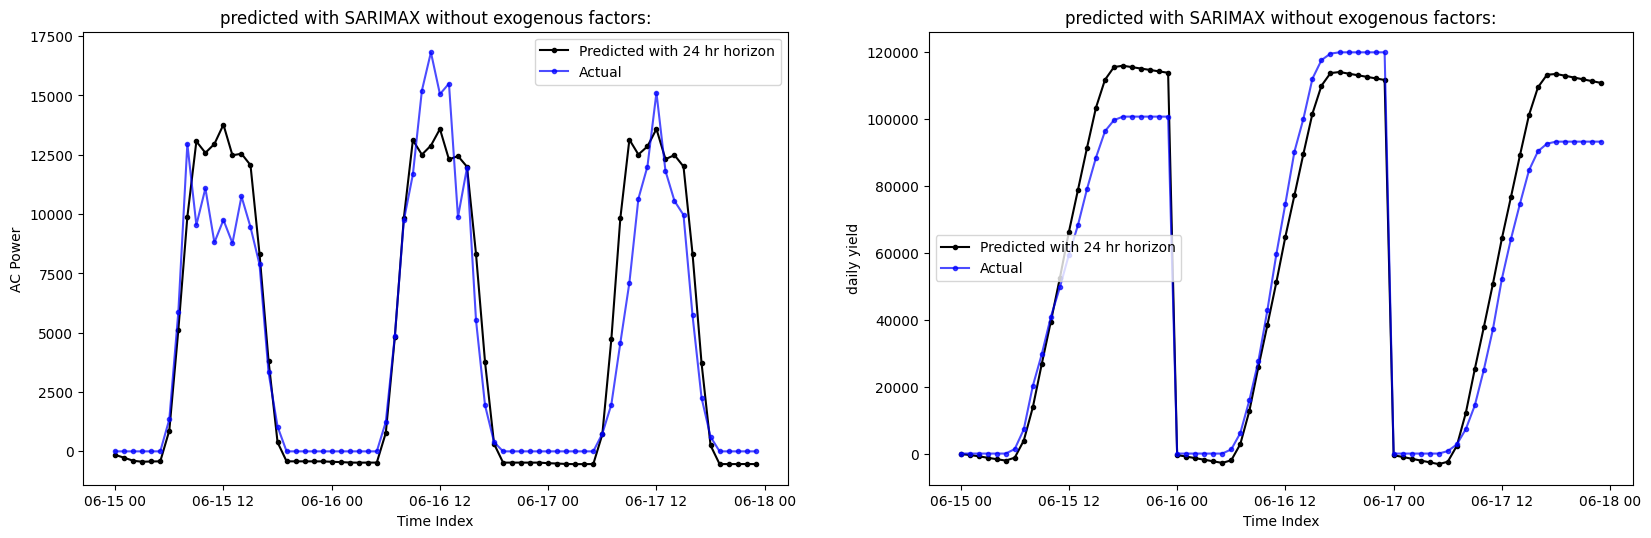

time: 859 ms (started: 2022-04-23 17:31:32 +02:00)


In [55]:
#Plotting predictions vs actual values: 
def plot_pred_vs_actual(eval_df, title):
    fig, ax = plt.subplots(1,2, dpi=100,figsize=(20,6))
    for i in range(0,2):
        ax[i].plot(eval_df.iloc[:,i*2], 'k.-')
        ax[i].plot(eval_df.iloc[:,1+i*2], 'b.-', alpha=0.70)
        ax[i].legend([f'Predicted with {horizon} hr horizon', 'Actual'])
        ax[i].set_title(f"predicted with {title}")
        ax[i].set_xlabel('Time Index')
    ax[0].set_ylabel('AC Power')
    ax[1].set_ylabel('daily yield')

plot_pred_vs_actual(results_no_exo, 'SARIMAX without exogenous factors:')

>We can see that the prediction succeds at predicting the general trend, however fails drastically in catching daily differences. The forecast for the following day looks exactly as the previous one. The model also predicts a negative power during nighttime hours, which does not make sense.

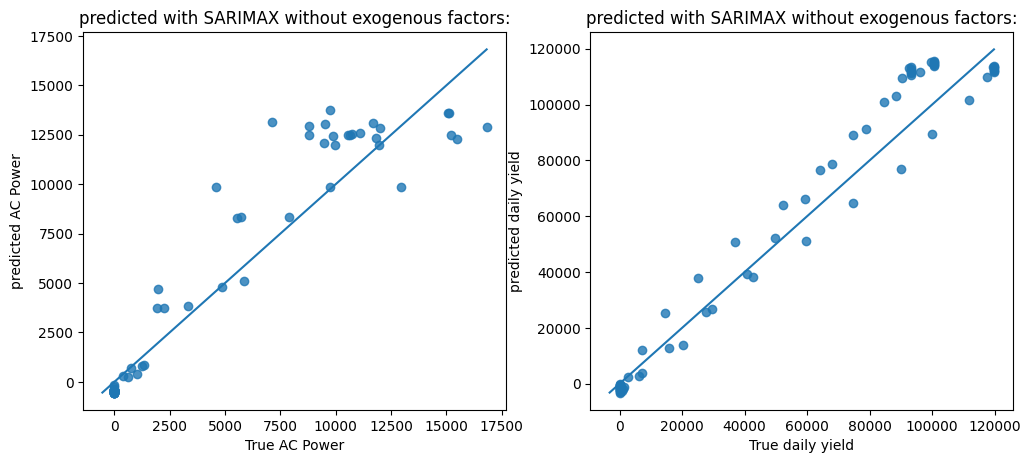

time: 532 ms (started: 2022-04-23 17:31:34 +02:00)


In [56]:
#Visual comparisons of the predictions:
#---------------------------------------
#Visualization of the accuracy
def plot_accuracy(eval_df, title):
    fig, ax = plt.subplots(1,2, dpi=100,figsize=(12,5))
    for i, var in enumerate(["AC Power", "daily yield"]):
        lims = [min(eval_df.iloc[:,i*2].min(), eval_df.iloc[:,1+i*2].min()), max(eval_df.iloc[:,i*2].max(), eval_df.iloc[:,1+i*2].max())]
        ax[i].plot(lims, lims)
        ax[i].scatter(eval_df.iloc[:,1+i*2], eval_df.iloc[:,i*2], marker='o',alpha=0.8)
        ax[i].set_title(f"predicted with {title}")
        ax[i].set_xlabel(f'True {var}')
        ax[i].set_ylabel(f'predicted {var}')

plot_accuracy(results_no_exo, 'SARIMAX without exogenous factors:')

In order to do a final comparison of all the different models later on, we will create another dataframe, saving all the final model scores in it.

In [57]:
scores_all_models = pd.DataFrame(index=['AC power R² hourly','AC power MAE hourly','daily yield R² hourly','daily yield MAE hourly',
                                        'AC power R² 3 days','AC power MAE 3 days','daily yield R² 3 days','daily yield MAE 3 days'])

time: 16 ms (started: 2022-04-23 17:31:35 +02:00)


In [58]:
def print_eval_scores(eval_df, model, hourly = True):
    mae = [mean_absolute_error(eval_df.iloc[:,1], eval_df.iloc[:,0]), mean_absolute_error(eval_df.iloc[:,3], eval_df.iloc[:,2])]
    r2 = [r2_score(eval_df.iloc[:,1], eval_df.iloc[:,0]), r2_score(eval_df.iloc[:,3], eval_df.iloc[:,2])]
    if hourly: 
        scores_all_models.loc[:'daily yield MAE hourly',model] = [r2[0]*100, mae[0], r2[1]*100, mae[1]]
        print(model, 'hourly prediction')
    else: 
        scores_all_models.loc['AC power R² 3 days':,model] = [r2[0]*100, mae[0], r2[1]*100, mae[1]]
        print(model, 'three day prediction')
    print(f"AC power R2 score:      {r2[0]*100:8.3f}%    MAE:{mae[0]:9.2f}kW")
    print(f"daily yield R2 score:   {r2[1]*100:8.3f}%    MAE:{mae[1]:9.2f}kWh")
    
print_eval_scores(results_no_exo, 'SARIMAX w/o exog', hourly = False)

SARIMAX w/o exog three day prediction
AC power R2 score:        88.230%    MAE:  1253.89kW
daily yield R2 score:     94.986%    MAE:  8121.24kWh
time: 15 ms (started: 2022-04-23 17:31:36 +02:00)


>Regarding the MAE and R² score, we can see that the Sarima model already does a really good job at predicting the power output of the following days. This seems to be due to the fact, that the daily trend is cought. It can also be seen that if the daily trend is cought, the daily yield shows an even better R2 score than the AC power.

In [59]:
scores_all_models

SARIMAX w/o exog
AC power R² hourly                   NaN
AC power MAE hourly                  NaN
daily yield R² hourly                NaN
daily yield MAE hourly               NaN
AC power R² 3 days             88.229557
AC power MAE 3 days          1253.887932
daily yield R² 3 days          94.986005
daily yield MAE 3 days       8121.242972

time: 16 ms (started: 2022-04-23 17:31:37 +02:00)


We can see that our function successfully stores the results in a dataframe.

### 3.2.5 Using exogenous Factors

Now we will repeat the model training, this time including exogenous factors by using the fucntion already written.

In [60]:
predictions_exo = sarimax(True)

2020-06-15 00:00:00
1 : predicted = [-4.46472455e-04  4.16141118e-03  5.10310524e-03  5.13257534e-04
  5.81682643e-03  8.58180122e-03  6.17191121e-02  2.45611371e-01
  5.54697682e-01  5.73355840e-01  5.63494649e-01  4.06075985e-01
  4.68919448e-01  2.73131532e-01  4.75177021e-01  4.36454829e-01
  3.29724125e-01  1.41757928e-01  2.49774010e-02 -9.09605449e-03
 -7.19642529e-03 -4.74560719e-03 -1.52721463e-03 -1.47621095e-03] 
true value = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05718273351072785, 0.24839415124157982, 0.5486646268916426, 0.40390771063601116, 0.46942782318717685, 0.37278718586271914, 0.41303841283447695, 0.3715779999350146, 0.45507557721010555, 0.4003123648905488, 0.33349996544329114, 0.1409487997555733, 0.04420930328372375, 0.0, 0.0, 0.0, 0.0, 0.0]
2020-06-16 00:00:00
25 : predicted = [-1.82424415e-03  1.36390757e-04  2.19858781e-03  1.28450298e-03
  3.19709320e-03  4.92036480e-03  5.76599159e-02  2.05062107e-01
  4.14613107e-01  4.61976997e-01  4.28347203e-01  4.49543669e-01
  

#### 3.2.5.1 Evaluating results

In [61]:
results_exo = create_results_df(predictions_exo, test.loc[:,forecast_variable])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-06-15 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 47 ms (started: 2022-04-23 17:36:32 +02:00)


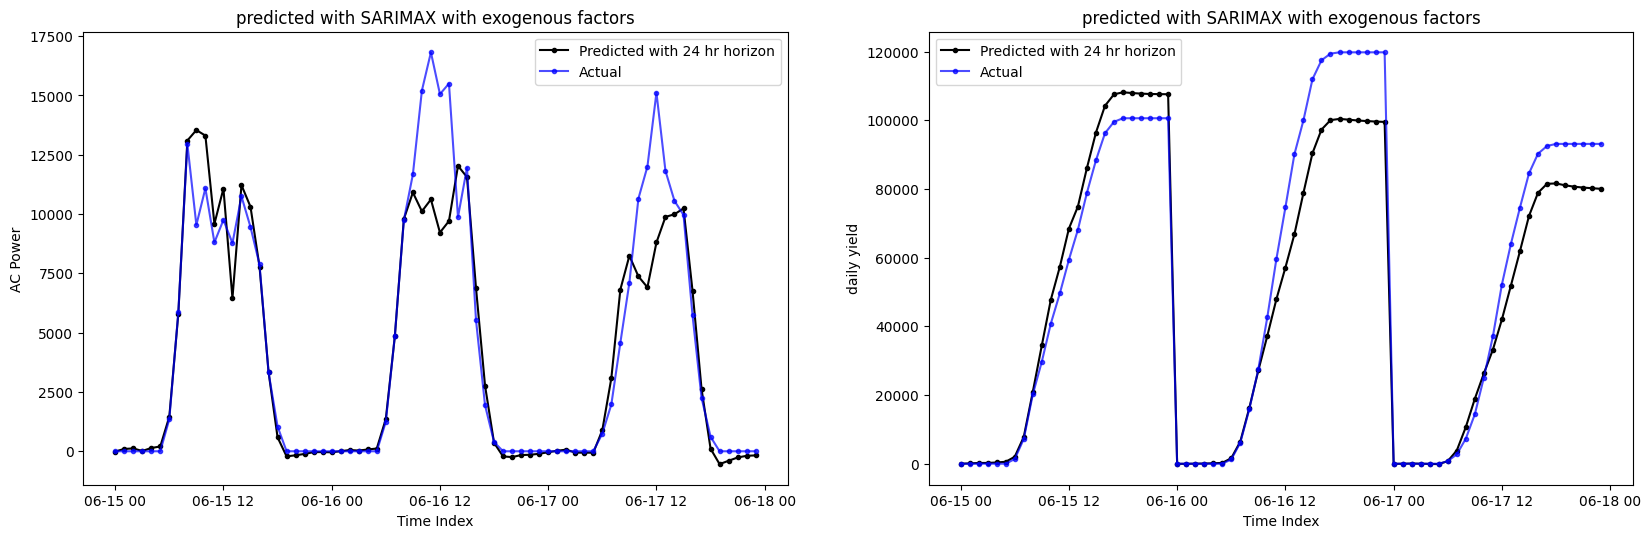

time: 875 ms (started: 2022-04-23 17:36:33 +02:00)


In [62]:
plot_pred_vs_actual(results_exo, 'SARIMAX with exogenous factors')

We can see that the model with exogenous factors is slightly better at catching the values shortly after sunrise / before sunset since this information is included in the exogenous factors. The nighttime predictions are also more accurate. However, we can also see that the model does not manage to catch the fluctuations over midday hours correctly.

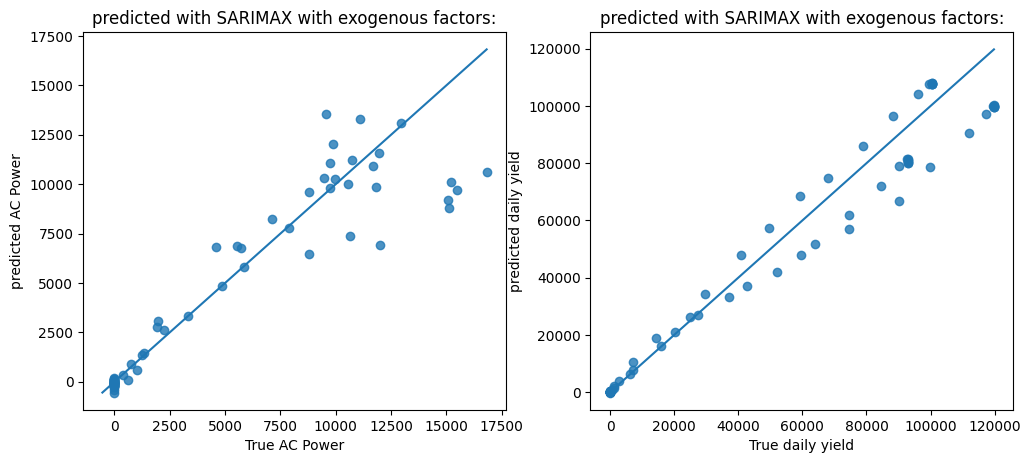

time: 672 ms (started: 2022-04-23 17:36:34 +02:00)


In [63]:
plot_accuracy(results_exo, 'SARIMAX with exogenous factors:')

In [64]:
print_eval_scores(results_exo, 'SARIMAX with exog', hourly = False)

SARIMAX with exog three day prediction
AC power R2 score:        87.255%    MAE:   968.36kW
daily yield R2 score:     94.899%    MAE:  7409.24kWh
time: 16 ms (started: 2022-04-23 17:36:36 +02:00)


While the R² values are slightly lesser than for the Sarimax model without exogenous factors, we can see that the mean average error improved for both the AC power as well as the daily yield, so including exogenous factors had its benefits. 

## 3.3 Baseline Model

As it is customary in data science, we will include a simple baseline model in order to compare our model performance to a common point of reference.

>As a baseline model, we will implement a simple linear regression model solely based on the irradiation data which we consider to be possesing due to weather forecasts. The results should be already reasonably good as we know from our correlation matrix (see [2.3](#23-correlations)) that there is 93% correlation between the irradiation and the AC power.

### 3.3.1 Train Test Split

We will first split our data into a train and test dataset.

In [65]:
X_baseline = df_plant_scaled.loc[:,'IRRADIATION'] # df_plant_scaled[exog]
y_baseline = df_plant_scaled.loc[:,forecast_variable]

time: 0 ns (started: 2022-04-23 17:36:37 +02:00)


In [66]:
# Train-Test Split function with option to split into validation data also:
def train_test_split(X, y, test_start_dt, val_start_dt = None, val = False):
    train_start_dt = '2020-05-15 0:00'
    test_end_dt = '2020-06-18 0:00'
    
    if val: train_end_dt = val_start_dt
    else: train_end_dt = test_start_dt

    #Let's use the same notation: 
    X_train = X.copy()[(X.index >= train_start_dt)& (X.index < train_end_dt)]
    y_train = y.copy()[(y.index >= train_start_dt)& (y.index < train_end_dt)]
    
    if val:
        X_val = X.copy()[(X.index >= val_start_dt)& (X.index < test_start_dt)]
        y_val = y.copy()[(y.index >= val_start_dt)& (y.index < test_start_dt)]

    X_test =  X.copy()[(X.index >= test_start_dt) & (X.index < test_end_dt)]
    y_test =  y.copy()[(y.index >= test_start_dt) & (y.index < test_end_dt)]

    print('Train data shape: ', X_train.shape, y_train.shape)
    if val: print('Validation data shape: ', X_val.shape, y_val.shape)
    print('Test data shape: ', X_test.shape, y_test.shape)
    if val: return X_train, y_train, X_val, y_val, X_test, y_test
    else: return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(X_baseline, y_baseline, test_start_dt = '2020-06-15 0:00')

#if doing single input linear regression, Scikit-learn requires reshape of input data
X_train = X_train.to_numpy().reshape(-1, 1)
X_test =  X_test.to_numpy().reshape(-1, 1)

Train data shape:  (744,) (744,)
Test data shape:  (72,) (72,)
time: 15 ms (started: 2022-04-23 17:36:38 +02:00)


### 3.3.2 Model Creation

In [67]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

time: 15 ms (started: 2022-04-23 17:36:38 +02:00)


In [68]:
#Model Predictions:
#------------------
def model_prediction_scores(model, X_val, y_val, model_name, val = True):

    y_train_pred = model.predict(X_train)
    scoreTraining = r2_score(y_train, y_train_pred)
    print('-----------------------------------')
    print(f'{model_name} Training R^2 Score: ', scoreTraining)
    print('-----------------------------------')
    y_val_pred = model.predict(X_val)
    scoreValidation = r2_score(y_val, y_val_pred)
    print('-----------------------------------')
    if val: print(f'{model_name} Validation R^2 Score: ', scoreValidation)
    else: print(f'{model_name} Test R^2 Score: ', scoreValidation)
    print('-----------------------------------')

model_prediction_scores(model_lr, X_test, y_test, "linear regression", val = False)

-----------------------------------
linear regression Training R^2 Score:  0.8913992043300547
-----------------------------------
-----------------------------------
linear regression Test R^2 Score:  0.8593476576687722
-----------------------------------
time: 0 ns (started: 2022-04-23 17:36:39 +02:00)


We can see that our baseline model already seems to do a pretty good job at predicting. Let´s take a closer look at the results in the following paragraph:

In [69]:
predictions = model_lr.predict(X_test)
results_lr = create_results_df(predictions, y_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-06-15 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 62 ms (started: 2022-04-23 17:36:40 +02:00)


### 3.3.3 Results

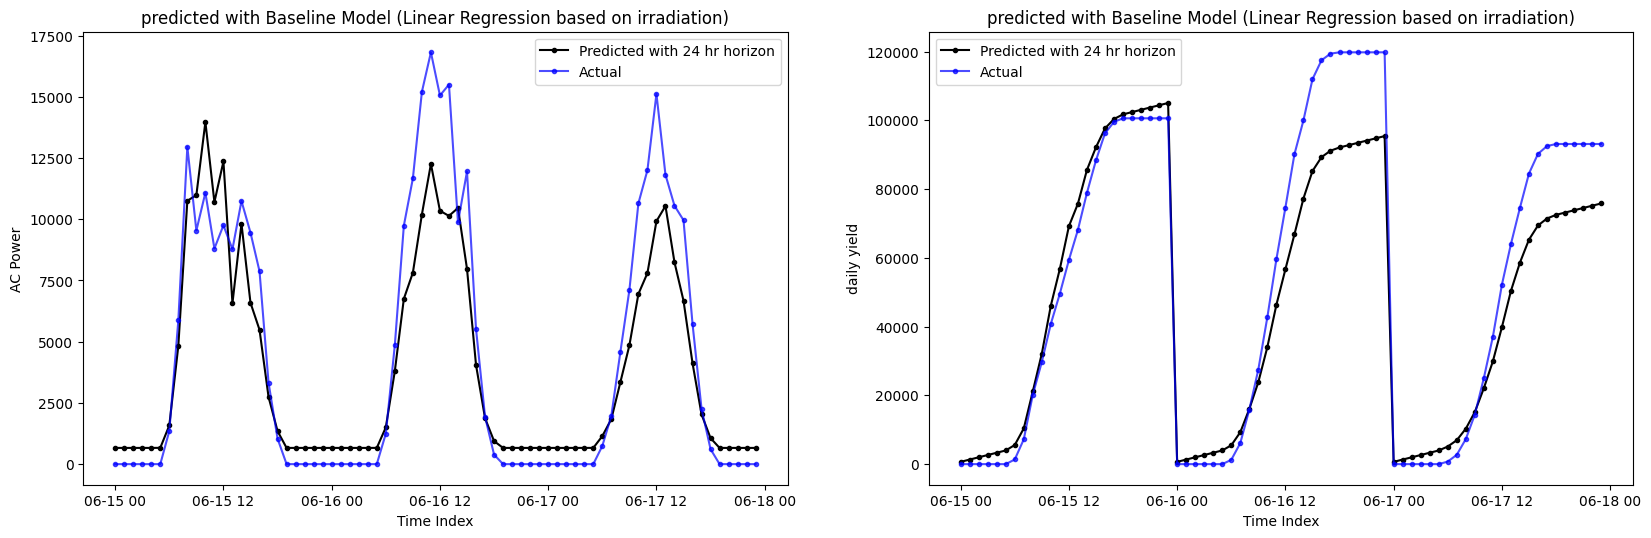

time: 797 ms (started: 2022-04-23 17:36:41 +02:00)


In [70]:
plot_pred_vs_actual(results_lr, 'Baseline Model (Linear Regression based on irradiation)')

>We can see that our baseline model is very good at catching the general trend of the AC power since it´s largely depending on the Irradiation. However, it seems to lack some sort of scaling. The first thought is that this scaling factor is contributed to the temperature. However, as you can test yourself, including the ambient temperature to the model does in fact worsen the predictions.

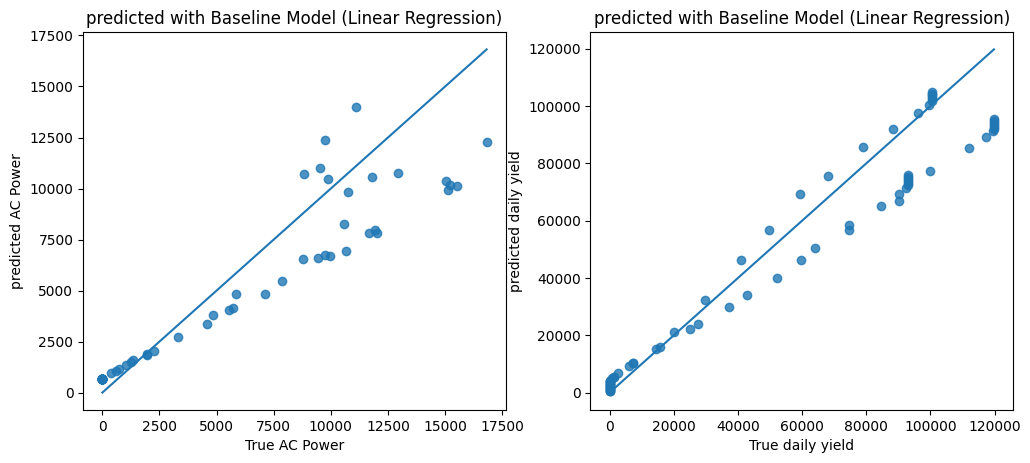

time: 625 ms (started: 2022-04-23 17:36:42 +02:00)


In [71]:
plot_accuracy(results_lr, 'Baseline Model (Linear Regression)')

In [72]:
print_eval_scores(results_lr, 'Baseline Model', hourly = False)

Baseline Model three day prediction
AC power R2 score:        85.935%    MAE:  1447.19kW
daily yield R2 score:     91.607%    MAE:  9549.72kWh
time: 16 ms (started: 2022-04-23 17:36:44 +02:00)


We can see that the scores of our baseline model are surprisingly good and will provide a tough baseline to compete against.

## 3.4 SVM

### 3.4.1 Feature Creation

In [73]:
# function that allows to add features such as minimum values and standard deviation to the dataframe:
def adding_features(df, time_interval):
    #Defining the time intervall (rolling window width in hours):
    hours = time_interval
    #Calling Rolling:
    window = df[[forecast_variable]].rolling(window=hours + 1)
    if not observe_hourly: hours = hours/4
    # Additional features: mean, median, std, min, max
    new_df = pd.concat([window.mean(), window.median(), window.std(), window.min(), window.max()], axis=1)
    new_df.columns = [f'mean_{hours}h', f'median_{hours}h', f'std_{hours}h', f'min_{hours}h', f'max_{hours}h']
    new_df = pd.merge(df, new_df, left_index=True, right_index=True)
    return new_df

time: 0 ns (started: 2022-04-23 17:36:45 +02:00)


We will add both features for the near term as well as for longer periods of time (up to two days) in order to capture the daily seasonality trends of the data. I found out that little features were necessary to get good predictions for the following time step, however at least as many features were necessary to achive good predictions for the 72 hour forecasts.
>The function is constructed so that the feature list t_intv can be changed without requiring further code changes.

In [74]:
if observe_hourly: t_intv = [2,4,12,24,48]
else: t_intv = [4,8,16,48,96,192] #[4,8,16,32,48,96,144,192]
def create_feature_df(dataframe):
    new_df = adding_features(dataframe, t_intv[0])
    for t in t_intv[1:]:
        new_df = adding_features(new_df, t)
    new_df = new_df.dropna() 
    return new_df

feature_df = create_feature_df(df_plant_scaled)
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 768 entries, 2020-05-17 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AC_POWER             768 non-null    float64
 1   AMBIENT_TEMPERATURE  768 non-null    float64
 2   IRRADIATION          768 non-null    float64
 3   mean_2h              768 non-null    float64
 4   median_2h            768 non-null    float64
 5   std_2h               768 non-null    float64
 6   min_2h               768 non-null    float64
 7   max_2h               768 non-null    float64
 8   mean_4h              768 non-null    float64
 9   median_4h            768 non-null    float64
 10  std_4h               768 non-null    float64
 11  min_4h               768 non-null    float64
 12  max_4h               768 non-null    float64
 13  mean_12h             768 non-null    float64
 14  median_12h           768 non-null    float64


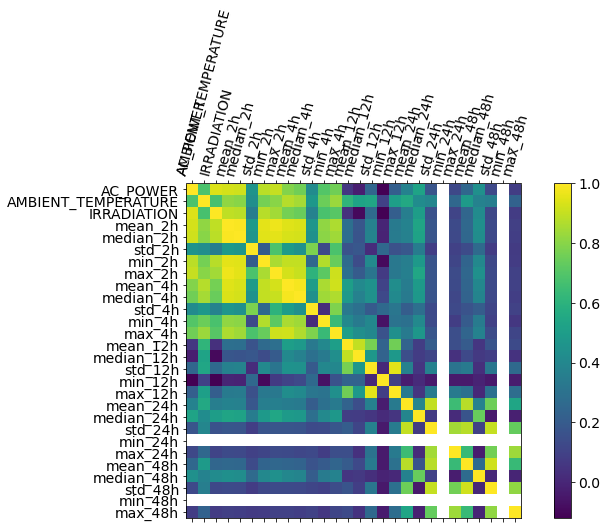

time: 1.11 s (started: 2022-04-23 17:36:47 +02:00)


In [75]:
#Correlation Matrix
correlationMatrix = pd.DataFrame(feature_df).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(feature_df.shape[1]), feature_df.columns, fontsize=14, rotation=75)
plt.yticks(range(feature_df.shape[1]), feature_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

The correlation matrix is very conclusive as it reveals that the short term features in general show drastically higher correlation than the ones covering 12 hours or more. However, there is still correlation which we will need in order to catch the seasonality effects, other than through irradiation and ambient temperature. We also see that some features like the standard deviation show less correlation, while the median shows higher correlation for the longer time periods. For values higher than daytime hours (~13h), the minimum value is missing since it is zero for the entire dataframe. However, this could still prove to be a valuable source of information (e.g. for neural networks)

### 3.4.2 Train Val Test Split

We will now create a sliding window over three days.

In [76]:
#finding the indices as integers for time substraction below:
start = 0
end = len(feature_df)
#setting windows width:
horizon = 72
window = horizon
if not observe_hourly: window = horizon * 4
#emply datalist
dataX = []
dataY = []
column_names = []
for i in range(start,end-window):

    # Slice a window of features
    dataX.append((feature_df.iloc[i:i+window].to_numpy()).ravel())
    dataY.append(feature_df[forecast_variable].iloc[i+window] )

for j in range(1,window+1):
    column_names.append([f"{x}_t_{j}" for x in feature_df.columns])

column_names = itertools.chain(*column_names)
dataX = pd.DataFrame(np.vstack(dataX),index=feature_df.iloc[start+window:end].index)
dataX.columns = column_names
dataY =pd.Series(dataY,index=feature_df.iloc[start+window:end].index)
dataY.column = [forecast_variable]

time: 219 ms (started: 2022-04-23 17:36:49 +02:00)


In [77]:
dataX.head(2)

AC_POWER_t_1  AMBIENT_TEMPERATURE_t_1  IRRADIATION_t_1  \
2020-05-20 00:00:00           0.0                 0.271576              0.0   
2020-05-20 01:00:00           0.0                 0.231820              0.0   

                      mean_2h_t_1  median_2h_t_1    std_2h_t_1  min_2h_t_1  \
2020-05-20 00:00:00  2.479299e-16            0.0  2.327949e-08         0.0   
2020-05-20 01:00:00  2.479299e-16            0.0  2.327949e-08         0.0   

                     max_2h_t_1  mean_4h_t_1  median_4h_t_1  ...  \
2020-05-20 00:00:00         0.0          0.0            0.0  ...   
2020-05-20 01:00:00         0.0          0.0            0.0  ...   

                     mean_24h_t_72  median_24h_t_72  std_24h_t_72  \
2020-05-20 00:00:00       0.184102         0.000549       0.26032   
2020-05-20 01:00:00       0.184102         0.000549       0.26032   

                     min_24h_t_72  max_24h_t_72  mean_48h_t_72  \
2020-05-20 00:00:00           0.0      0.676051       0.206059   
2020-05-20 01:00:00           0.0      0.676051       0.206059   

                     median_48h_t_72  std_48h_t_72  min_48h_t_72  max_48h_t_72  
2020-05-20 00:00:00         0.000549       0.27697           0.0      0.715522  
2020-05-20 01:00:00         0.000549       0.27697           0.0      0.715522  

[2 rows x 2016 columns]

time: 47 ms (started: 2022-04-23 17:36:50 +02:00)


In [78]:
dataY.head(2)

2020-05-20 00:00:00    0.0
2020-05-20 01:00:00    0.0
Freq: H, dtype: float64

time: 0 ns (started: 2022-04-23 17:36:50 +02:00)


Finally, we split our data into training, validation and test data sets with the last three days as a test set and the three days before that as a validation set. We will already require a validation set since I decided to directly include the model selection (hyperparameter optimization) in these steps. The way we created our data we could also split up the training and validation data sets randomly and perform cross validation. However, as this took significantly more time and didn´t lead to noticable improvements, the "classic" time series approach for splitting into training, validation and test set was used.

In [79]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(dataX, dataY, val_start_dt = '2020-6-12 0:00', test_start_dt = '2020-06-15 0:00', val = True)

Train data shape:  (552, 2016) (552,)
Validation data shape:  (72, 2016) (72,)
Test data shape:  (72, 2016) (72,)
time: 31 ms (started: 2022-04-23 17:36:52 +02:00)


### 3.4.3 Model Creation

we will first create the model with its default parameters and see how well it performs on the validation data, then perform the hyperparameter optimization and check how much it improved.

In [80]:
# Hyperparameters:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#

#__________________________________________________________________________________________
#___Notes__________________________________________________________________________________
#Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. 

#The parameter C, common to all SVM kernels, trades off misclassification of training examples 
#against simplicity of the decision surface. 
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#The strength of the regularization is inversely proportional to C. Large C => little regularization; Low C => higher regularization

#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.
#__________________________________________________________________________________________

kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1   # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)
 

time: 0 ns (started: 2022-04-23 17:36:52 +02:00)


In [81]:
# Model Training:
model_svr = svr
#Fitting the model according to given data:
model_svr.fit(X_train, y_train)

SVR(kernel='linear', tol=1e-05)

time: 235 ms (started: 2022-04-23 17:36:54 +02:00)


In [82]:
model_prediction_scores(model_svr, X_val, y_val, "SVM Regression")

-----------------------------------
SVM Regression Training R^2 Score:  0.9468263835989011
-----------------------------------
-----------------------------------
SVM Regression Validation R^2 Score:  0.8949567581218315
-----------------------------------
time: 125 ms (started: 2022-04-23 17:36:54 +02:00)


>We can observe that the vanilla model seems to already perform really good on the validation data. Also, overfit doesn´t seem to be too much of an issue. However, let´s see how well it performs after optimization:

### 3.4.4 Hyperparameter optimization

>We will use optuna for the parameter optimization as this is a quite recently developed library that uses pruning (automatically stopping unpromising trials at the early stages) and therefore takes very little time for successfull optimization. Furthermore, it possesses some useful visualization libraries.
Inspiration was taken from here:
https://towardsdatascience.com/how-to-make-your-model-awesome-with-optuna-b56d490368af

In order to use optuna, we must first define an objective function that contains all the necessary information (parameter range, model and error function). The limits of the hyperparameters were narrowed down to reasonable ranges in several iterative steps.

In [83]:
def objective_svr(n_trials):
    if observe_hourly:
        params = {
            'kernel' : n_trials.suggest_categorical("kernel", ["linear", "poly", "rbf"]), #, "sigmoid"]), omitted since sigmoid leads to huge errors
            'gamma' : 'scale', #n_trials.suggest_float('gamma', 1e-4, 0.1, log = True),
            'C': n_trials.suggest_float('C', 0.005, 0.05, log = True),
            'epsilon' : n_trials.suggest_float('epsilon', 0.005, 0.2, log = True),
            'tol': 1e-5,
            'max_iter': -1
        }
    else:
        params = {
            # in a previous iteration step it was found out that the rbf kernel produces the best results. Therefore, it was set to default in order to tune gamma
            'kernel' : 'rbf', # n_trials.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]), #
            'gamma' : n_trials.suggest_float('gamma', 1e-4, 0.1, log = True), # 'scale',
            'C': n_trials.suggest_float('C', 1e-2, 10, log = True),
            'epsilon' : n_trials.suggest_float('epsilon', 1e-3, 1, log = True),
            'tol': 1e-5,
            'max_iter': 500
        }
    model = SVR()
    model.set_params(**params)
    regressor = model.fit(X_train, y_train)
    y_pred = regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse

time: 0 ns (started: 2022-04-23 17:36:55 +02:00)


What´s really handy about optuna is that we can set a time limit / define the number of trials, which we will set to 100.

In [84]:
study_svr = op.create_study(direction="minimize")
study_svr.optimize(objective_svr, n_trials=100)
print(f"Optimized MSE: {study_svr.best_value:.4f}")
print("Best params:")
for key, value in study_svr.best_params.items():
    print(f"\t{key}: {value}")

[I 2022-04-23 17:36:56,608] A new study created in memory with name: no-name-007d56fc-ffcd-4112-a256-dde65cf5d86c
[I 2022-04-23 17:36:56,905] Trial 0 finished with value: 0.004046246830204337 and parameters: {'kernel': 'linear', 'C': 0.0074032942938054205, 'epsilon': 0.054070929442079266}. Best is trial 0 with value: 0.004046246830204337.
[I 2022-04-23 17:36:57,110] Trial 1 finished with value: 0.016655130114711134 and parameters: {'kernel': 'poly', 'C': 0.03095406274413959, 'epsilon': 0.09084700280686928}. Best is trial 0 with value: 0.004046246830204337.
[I 2022-04-23 17:36:57,269] Trial 2 finished with value: 0.003845159552780111 and parameters: {'kernel': 'linear', 'C': 0.02914945240199016, 'epsilon': 0.13017437424665182}. Best is trial 2 with value: 0.003845159552780111.
[I 2022-04-23 17:36:57,800] Trial 3 finished with value: 0.01043212905990716 and parameters: {'kernel': 'rbf', 'C': 0.0054043123204174665, 'epsilon': 0.04069132357857148}. Best is trial 2 with value: 0.00384515955

Optimized MSE: 0.0036
Best params:
	kernel: linear
	C: 0.025223720657800923
	epsilon: 0.09981795128582499
time: 32 s (started: 2022-04-23 17:36:56 +02:00)


The following plot shows the evolution of the error over the number of trials. It can bes seen that the library figures out reasonable parameter combinations very fast and then slowly improves them while from time to time trying totally different combinations.

C:\Users\AEppl\AppData\Local\Temp\ipykernel_12056\3252711947.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_svr);


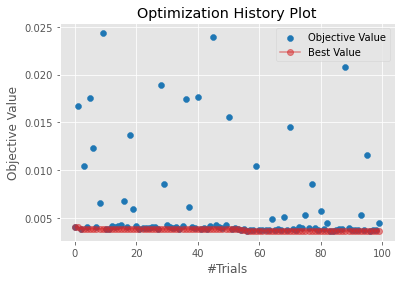

time: 438 ms (started: 2022-04-23 17:37:29 +02:00)


In [85]:
# svm_opt_results_df = study_svr.trials_dataframe()
plot_optimization_history(study_svr);

The following plot shows the importance of the hyperparameters on the result (kind of like in a design of experiments study). We can see that the kernel plays the highest influence on the result. However, this is dependent on how well the hyperparameter boundaries are set since it simply seems to compare the standard deviations of the error margins of the hyperparameters. We will therefore omit this plot in the further analysis.

In [86]:
fig = op.visualization.plot_param_importances(study_svr)
fig.show()

time: 5.91 s (started: 2022-04-23 17:37:30 +02:00)


The following plot is really handy to pick the ranges for optuna to find reasonable hyperparameters.

For the following plot, you can use the interactive feature of the plot in order to zoom. We can  see that we picked reasonable ranges for the hyperparameter values. We can also see that a linear kernel overal has the best performance for hourly observations. For quaterhourly observations, a rbf kernel is better suited.

In [87]:
fig = op.visualization.plot_slice(study_svr)
fig.show()

time: 500 ms (started: 2022-04-23 17:37:37 +02:00)


>Let´s now see how well our tuned model performs on the validation data. We can see significant improvements in the validation error. We can also see that the error gap was significantly reduced (overfit is less of a problem now).

In [88]:
if observe_hourly: model_svr.set_params(**study_svr.best_params, gamma = 'scale')
else: model_svr.set_params(**study_svr.best_params, kernel = 'rbf')
model_svr.fit(X_train, y_train)
model_prediction_scores(model_svr, X_val, y_val, 'tuned Support Vector Regression')

-----------------------------------
tuned Support Vector Regression Training R^2 Score:  0.9355114946465021
-----------------------------------
-----------------------------------
tuned Support Vector Regression Validation R^2 Score:  0.9304256246856984
-----------------------------------
time: 313 ms (started: 2022-04-23 17:37:38 +02:00)


### 3.4.5 Results hourly forecast

>We now use the combined training and validation data to train the best parameter model in order to evaluate it on the test data:

In [89]:
# Train-Test Split:
X_train, y_train, X_test, y_test = train_test_split(dataX, dataY, test_start_dt = '2020-06-15 0:00')
model_svr.fit(X_train, y_train)

Train data shape:  (624, 2016) (624,)
Test data shape:  (72, 2016) (72,)


SVR(C=0.025223720657800923, epsilon=0.09981795128582499, kernel='linear',
    tol=1e-05)

time: 219 ms (started: 2022-04-23 17:37:39 +02:00)


In [90]:
predictions = model_svr.predict(X_test)
results_svm_hourly = create_results_df(predictions, y_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-06-15 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 110 ms (started: 2022-04-23 17:37:40 +02:00)


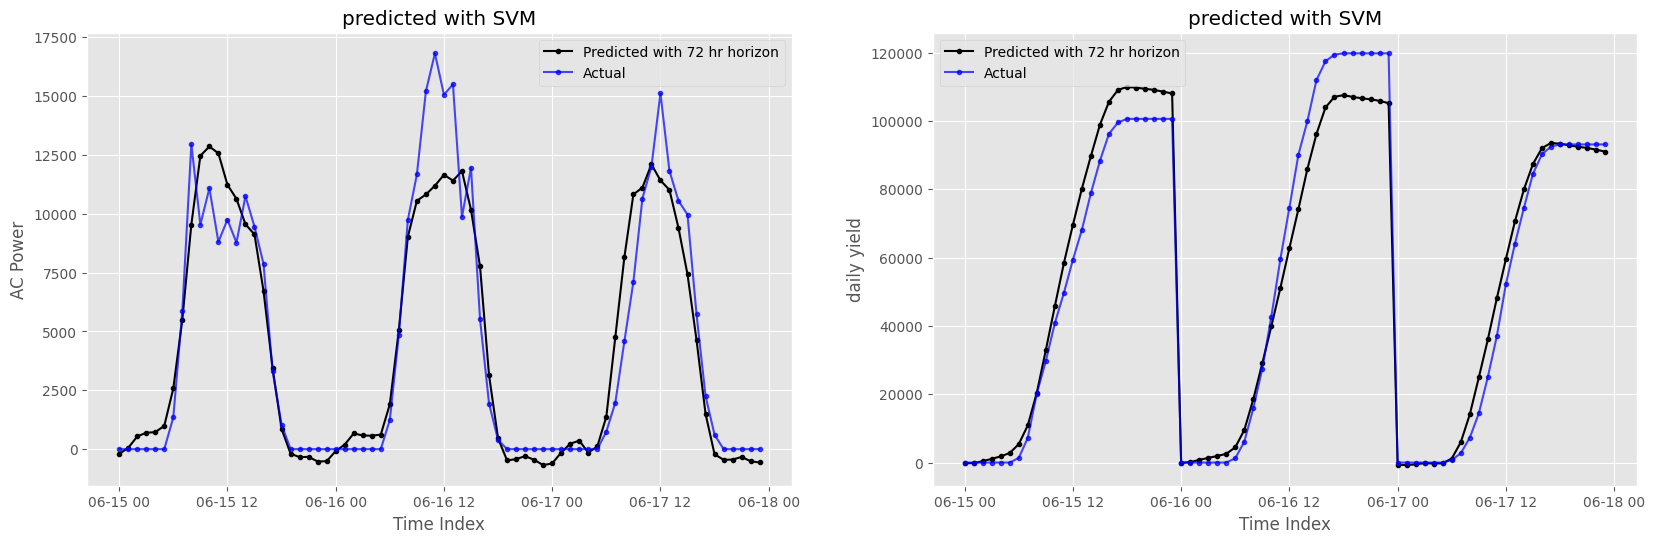

time: 938 ms (started: 2022-04-23 17:37:41 +02:00)


In [91]:
plot_pred_vs_actual(results_svm_hourly, 'SVM')

We can see that the model is very good at catching the daily overall trend, especially for the first and third day. However, it does not catch the hourly fluctuationson the first day and the high power on the second day. All in all, this allows the model to forecast the daily yield pretty accurately though.

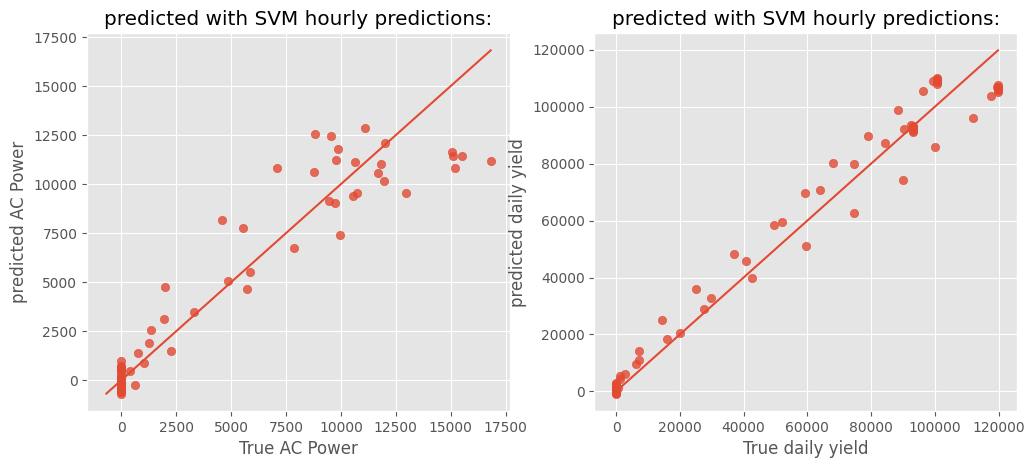

time: 594 ms (started: 2022-04-23 17:37:43 +02:00)


In [92]:
plot_accuracy(results_svm_hourly, 'SVM hourly predictions:')

In [93]:
print_eval_scores(results_svm_hourly, 'SVM', hourly = True)

SVM hourly prediction
AC power R2 score:        89.747%    MAE:  1158.88kW
daily yield R2 score:     97.228%    MAE:  5750.39kWh
time: 16 ms (started: 2022-04-23 17:37:44 +02:00)


### 3.4.6 Results Three Days Forecast

We will now create a time frame possessing the weather info in order to predict the whole three days.

In [94]:
# we need the start time to be earlier according to the longest feature in order to allow us to update the features later on.
feature_start_time = pd.Timestamp(y_test.index[0]) - DateOffset(hours=t_intv[-1])
test_weather_info = df_plant_scaled.copy(deep = True)[(df_plant_scaled.index >= feature_start_time) & (df_plant_scaled.index < test_start_dt)]
tmp = df_plant_scaled.copy(deep = True)[(df_plant_scaled.index >= test_start_dt) & (df_plant_scaled.index < test_end_dt)]
# we will pretend to not know the AC power values while possesing knowledge of the ambient tmeperature and irradiation through weather forecasts,
# therefore we will fill the AC power column with null values, starting at the first value we want to predict
tmp[forecast_variable] = None
test_weather_info = test_weather_info.append(tmp)
test_weather_info

AC_POWER  AMBIENT_TEMPERATURE  IRRADIATION
2020-06-13 00:00:00       0.0             0.102533          0.0
2020-06-13 01:00:00       0.0             0.086764          0.0
2020-06-13 02:00:00       0.0             0.060143          0.0
2020-06-13 03:00:00       0.0             0.059141          0.0
2020-06-13 04:00:00       0.0             0.061173          0.0
...                       ...                  ...          ...
2020-06-17 19:00:00       NaN             0.125520          0.0
2020-06-17 20:00:00       NaN             0.133955          0.0
2020-06-17 21:00:00       NaN             0.143232          0.0
2020-06-17 22:00:00       NaN             0.131925          0.0
2020-06-17 23:00:00       NaN             0.114110          0.0

[120 rows x 3 columns]

time: 16 ms (started: 2022-04-23 17:37:45 +02:00)


This is a function that we can reuse for all the baseline models, it updates our AC power column from the test_weather_info df with every prediction loop, in order to update our feature dataframe to work for the next prediction

In [95]:
def pred_three_days(model, test_weather_info, n_features, np_able = True):
    # series to store the predicted values
    test_weather = test_weather_info.copy(deep = True)
    y_predicted =pd.Series(index=y_test.index, dtype='float64')
    if np_able: X_test_last = X_test.copy(deep = True).iloc[0:1].to_numpy()
    else: X_test_last = X_test.copy(deep = True).iloc[0:1]
    for case_index in y_test.index:
    # predicting with trained input model
        prediction = model.predict(X_test_last).flatten()[0]
        # print(prediction)
        y_predicted.update(pd.Series(prediction,index=[case_index]))
        test_weather.loc[case_index, forecast_variable] = prediction
        update_next_hour = create_feature_df(test_weather)
        
        test_weather = test_weather.iloc[1:, :]
        # updating X_test_last with new values
        for i in range (X_test_last.shape[1]-n_features):
            if np_able: X_test_last[0][i] = X_test_last[0][i+n_features]
            else: X_test_last.iloc[0,i] = X_test_last.iloc[0,i+n_features]
        for i in range(update_next_hour.shape[1]):   
            if np_able: X_test_last[0][X_test_last.shape[1]-n_features+i] = update_next_hour.iloc[0,i]
            else: X_test_last.iloc[0,X_test_last.shape[1]-n_features+i] = update_next_hour.iloc[0,i]
    return y_predicted

predictions = pred_three_days(model_svr, test_weather_info, feature_df.shape[1])
results_svm = create_results_df(predictions, y_test.copy(deep=True))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-06-15 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 5.2 s (started: 2022-04-23 17:37:46 +02:00)


Let´s take a look at the results:

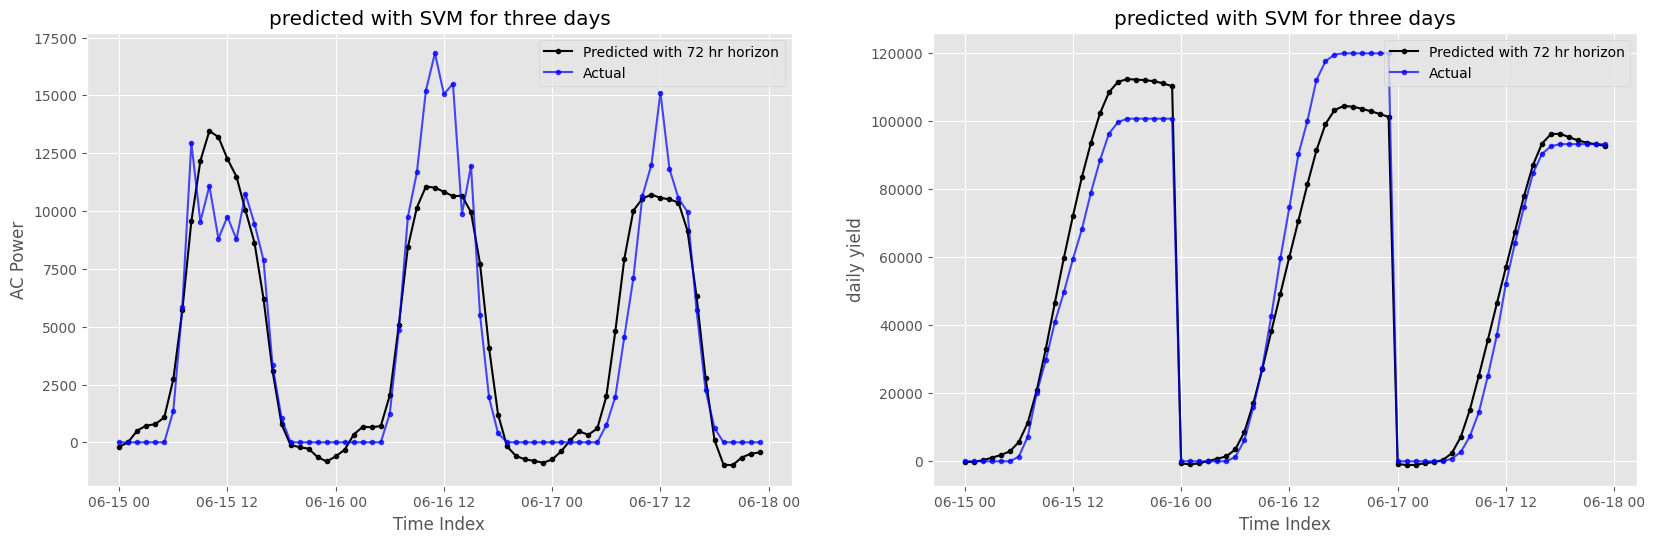

time: 1.02 s (started: 2022-04-23 17:37:52 +02:00)


In [96]:
plot_pred_vs_actual(results_svm, 'SVM for three days')

we can see that our model is surprisingly good at predicting the next three days and that the results are very similar to the hourly predictions, only slightly less accurate. At first I thought this was contributed to the model heavily depending on the "weather forecast" data. However, in order to check that assumption I omitted the long term features and noticed stark decreases in long term forecast ability so the long term features seem to play a more important role.

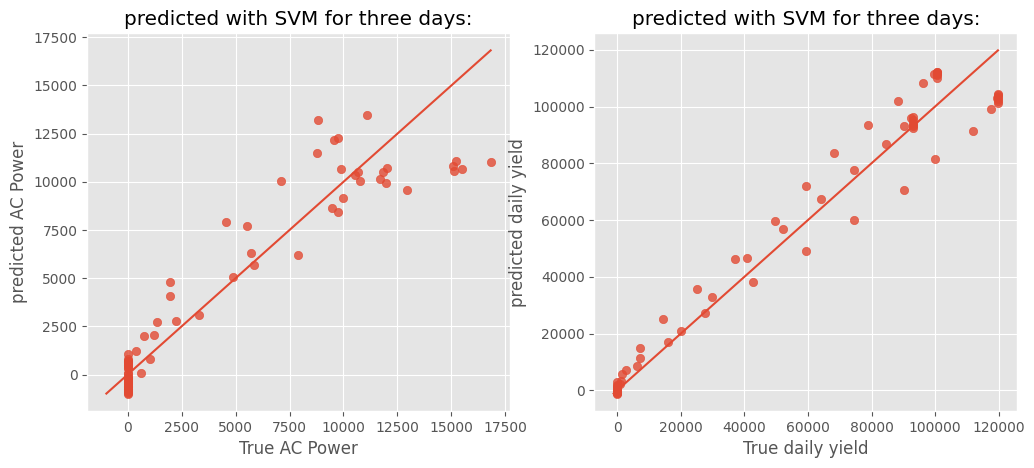

time: 531 ms (started: 2022-04-23 17:37:54 +02:00)


In [97]:
plot_accuracy(results_svm, 'SVM for three days:')

In [98]:
print_eval_scores(results_svm, 'SVM', hourly = False)

SVM three day prediction
AC power R2 score:        88.149%    MAE:  1283.00kW
daily yield R2 score:     95.827%    MAE:  6814.99kWh
time: 16 ms (started: 2022-04-23 17:37:55 +02:00)


It can be seen that the R² score of the model is better than that of the baseline and Sarimax model.

## 3.5 Bayesian Ridge Regression

We need to do the train test val split again since our training data currently consists of the combined training and validation data:

In [99]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(dataX, dataY, val_start_dt = '2020-6-12 0:00', test_start_dt = '2020-06-15 0:00', val = True)

Train data shape:  (552, 2016) (552,)
Validation data shape:  (72, 2016) (72,)
Test data shape:  (72, 2016) (72,)
time: 46 ms (started: 2022-04-23 17:37:56 +02:00)


### 3.5.1 Model Creation

In [100]:
# Hyperparameters:
n_iter = 300 # default=300 Maximum number of iterations. Should be greater than or equal to 1.
tol = 1e-3 # default=1e-3 Stop the algorithm if w has converged.
alpha_1 = 1e-6 # default=1e-6 Hyper-parameter : shape parameter for the Gamma distribution prior over the alpha parameter.
alpha_2 = 1e-6 # default=1e-6 Hyper-parameter : inverse scale parameter (rate parameter) for the Gamma distribution prior over the alpha parameter.
lambda_1 = 1e-6 # default=1e-6 Hyper-parameter : shape parameter for the Gamma distribution prior over the lambda parameter.
lambda_2 = 1e-6 # default=1e-6 Hyper-parameter : inverse scale parameter (rate parameter) for the Gamma distribution prior over the lambda parameter.

brr = BayesianRidge(n_iter = n_iter, tol = tol, alpha_1 = alpha_1, alpha_2 = alpha_2, lambda_1 = lambda_1, lambda_2 = lambda_2, compute_score=True)

model_brr = brr.fit(X_train, y_train)
model_prediction_scores(model_brr, X_val, y_val, 'Bayesian Ridge Regression')

-----------------------------------
Bayesian Ridge Regression Training R^2 Score:  0.9653001203079555
-----------------------------------
-----------------------------------
Bayesian Ridge Regression Validation R^2 Score:  0.9331345213663103
-----------------------------------
time: 1.3 s (started: 2022-04-23 17:37:57 +02:00)


>We can see that the default brr model already does a really good job at predicting the validation data (compareable to the optimized SVM). Let´s see if we can even further improve this:

### 3.5.2 Hyperparameter optimization

Reasonable hyperparameter ranges were again determined iteratively.

In [101]:
def objective_brr(n_trials):
    if observe_hourly:
        params = {
            'alpha_1' : n_trials.suggest_float('alpha_1', 1e-8, 0.01, log = True),
            'alpha_2' : n_trials.suggest_float('alpha_2', 0.01, 1, log = True),
            'lambda_1' : n_trials.suggest_float('lambda_1', 1e-8, 1, log = True),
            'lambda_2' : n_trials.suggest_float('lambda_2', 0.002, 0.02, log = True),
            'tol': 1e-5,
            'n_iter': 1000
        }
    else:
        params = {
            'alpha_1' : n_trials.suggest_float('alpha_1', 1e-3, 20, log = True),
            'alpha_2' : n_trials.suggest_float('alpha_2', 5, 20, log = True),
            'lambda_1' : n_trials.suggest_float('lambda_1', 1e-8, 10, log = True),
            'lambda_2' : n_trials.suggest_float('lambda_2', 1e-8, 0.01, log = True),
            'tol': 1e-5,
            'n_iter': 500
        }
    model = BayesianRidge()
    model.set_params(**params)
    regressor = model.fit(X_train, y_train)
    y_pred = regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse

time: 0 ns (started: 2022-04-23 17:37:59 +02:00)


In [102]:
study_brr = op.create_study(direction="minimize")
study_brr.optimize(objective_brr, n_trials=100)
print(f"Optimized MSE: {study_brr.best_value:.4f}")
print("Best params:")
for key, value in study_brr.best_params.items():
    print(f"\t{key}: {value}")

[I 2022-04-23 17:37:59,880] A new study created in memory with name: no-name-3233ab81-0967-435a-9467-200d37eec9cd
[I 2022-04-23 17:38:01,119] Trial 0 finished with value: 0.0034875428383099117 and parameters: {'alpha_1': 3.284582586275573e-08, 'alpha_2': 0.13148096701341452, 'lambda_1': 7.066398897111291e-06, 'lambda_2': 0.01940293686712788}. Best is trial 0 with value: 0.0034875428383099117.
[I 2022-04-23 17:38:02,431] Trial 1 finished with value: 0.003497064112122581 and parameters: {'alpha_1': 8.884467260728294e-05, 'alpha_2': 0.05902986022800419, 'lambda_1': 7.557398938772925e-06, 'lambda_2': 0.014244323806760037}. Best is trial 0 with value: 0.0034875428383099117.
[I 2022-04-23 17:38:03,715] Trial 2 finished with value: 0.0036487586340461942 and parameters: {'alpha_1': 1.104346145799228e-07, 'alpha_2': 0.8705627427139221, 'lambda_1': 1.4325021861875936e-06, 'lambda_2': 0.004906033732128952}. Best is trial 0 with value: 0.0034875428383099117.
[I 2022-04-23 17:38:04,934] Trial 3 fin

Optimized MSE: 0.0035
Best params:
	alpha_1: 6.505247998593547e-06
	alpha_2: 0.07861047211804259
	lambda_1: 0.9984614629115277
	lambda_2: 0.003759541786498962
time: 1min 58s (started: 2022-04-23 17:37:59 +02:00)


C:\Users\AEppl\AppData\Local\Temp\ipykernel_12056\2612134214.py:2: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



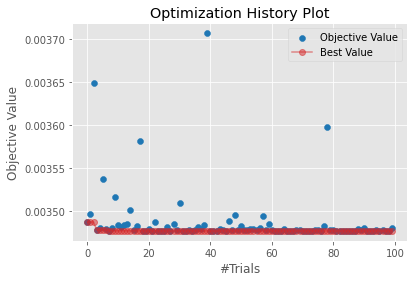

time: 469 ms (started: 2022-04-23 17:39:59 +02:00)


In [103]:
# svm_opt_results_df = study_svr.trials_dataframe()
plot_optimization_history(study_brr);

We can see that the alpha 2 parameter possesses by far the most distinct minimum.

In [104]:
fig = op.visualization.plot_slice(study_brr)
fig.show()

time: 266 ms (started: 2022-04-23 17:40:00 +02:00)


In [105]:
model_brr.set_params(**study_brr.best_params)
model_brr.fit(X_train, y_train)
model_prediction_scores(model_brr, X_val, y_val, 'tuned Bayesian Ridge Regression')

-----------------------------------
tuned Bayesian Ridge Regression Training R^2 Score:  0.9635104799851276
-----------------------------------
-----------------------------------
tuned Bayesian Ridge Regression Validation R^2 Score:  0.9332369389085009
-----------------------------------
time: 1.17 s (started: 2022-04-23 17:40:05 +02:00)


we can see that for the hourly forecast, the vanilla BRR was already producing really good results that can be hardly improved by hyperparameter optimization.

### 3.5.3 Results hourly forecast

>We now use the combined training and validation data to train the best parameter model in order to evaluate it on the test data:

In [106]:
# Train-Test Split:
X_train, y_train, X_test, y_test = train_test_split(dataX, dataY, test_start_dt = '2020-06-15 0:00')
model_brr.fit(X_train, y_train)

Train data shape:  (624, 2016) (624,)
Test data shape:  (72, 2016) (72,)


BayesianRidge(alpha_1=6.505247998593547e-06, alpha_2=0.07861047211804259,
              compute_score=True, lambda_1=0.9984614629115277,
              lambda_2=0.003759541786498962)

time: 1.27 s (started: 2022-04-23 17:40:07 +02:00)


In [107]:
predictions = model_brr.predict(X_test)
results_brr_hourly = create_results_df(predictions, y_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-06-15 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 63 ms (started: 2022-04-23 17:40:09 +02:00)


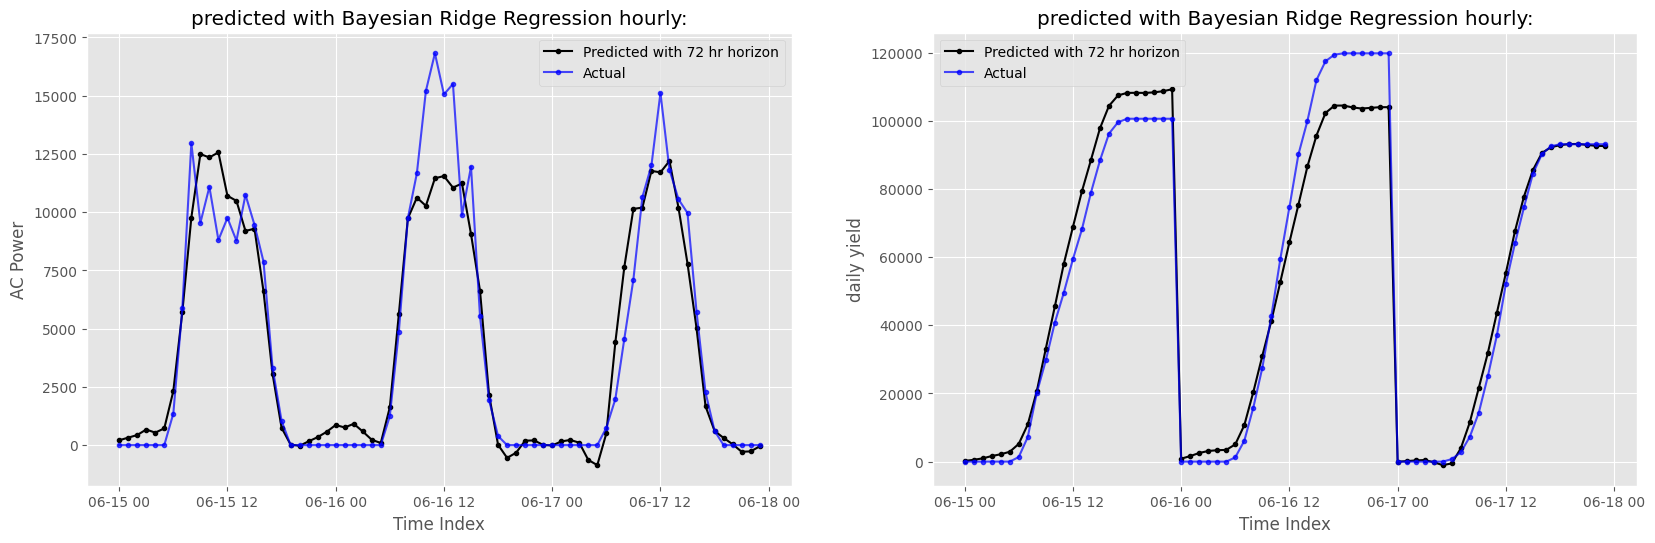

time: 516 ms (started: 2022-04-23 17:40:10 +02:00)


In [108]:
plot_pred_vs_actual(results_brr_hourly, 'Bayesian Ridge Regression hourly:')

This plot looks fairly similar to that of the support vector machine. Like the SVM, it catches the first and third day really well while underpredicting the second day. This behaviour is mirrored by the daily yield plot.

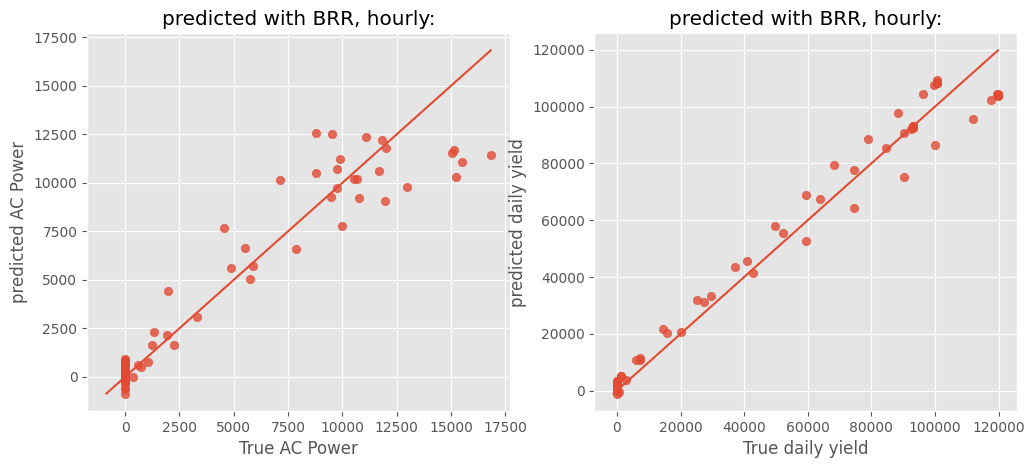

time: 625 ms (started: 2022-04-23 17:40:11 +02:00)


In [109]:
plot_accuracy(results_brr_hourly, 'BRR, hourly:')

In [110]:
print_eval_scores(results_brr_hourly, 'Bayesian Ridge Regression', hourly = True)

Bayesian Ridge Regression hourly prediction
AC power R2 score:        90.648%    MAE:  1023.00kW
daily yield R2 score:     97.261%    MAE:  5528.57kWh
time: 0 ns (started: 2022-04-23 17:40:12 +02:00)


As was to be expected, the errors closely resemble those of the SVM. Let´s see if this also holds true for predicting three days into the future:

### 3.5.4 Results Three Days forecast

In [111]:
predictions = pred_three_days(model_brr, test_weather_info, feature_df.shape[1])
results_brr = create_results_df(predictions, y_test.copy(deep=True))


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-06-15 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 3.41 s (started: 2022-04-23 17:40:12 +02:00)


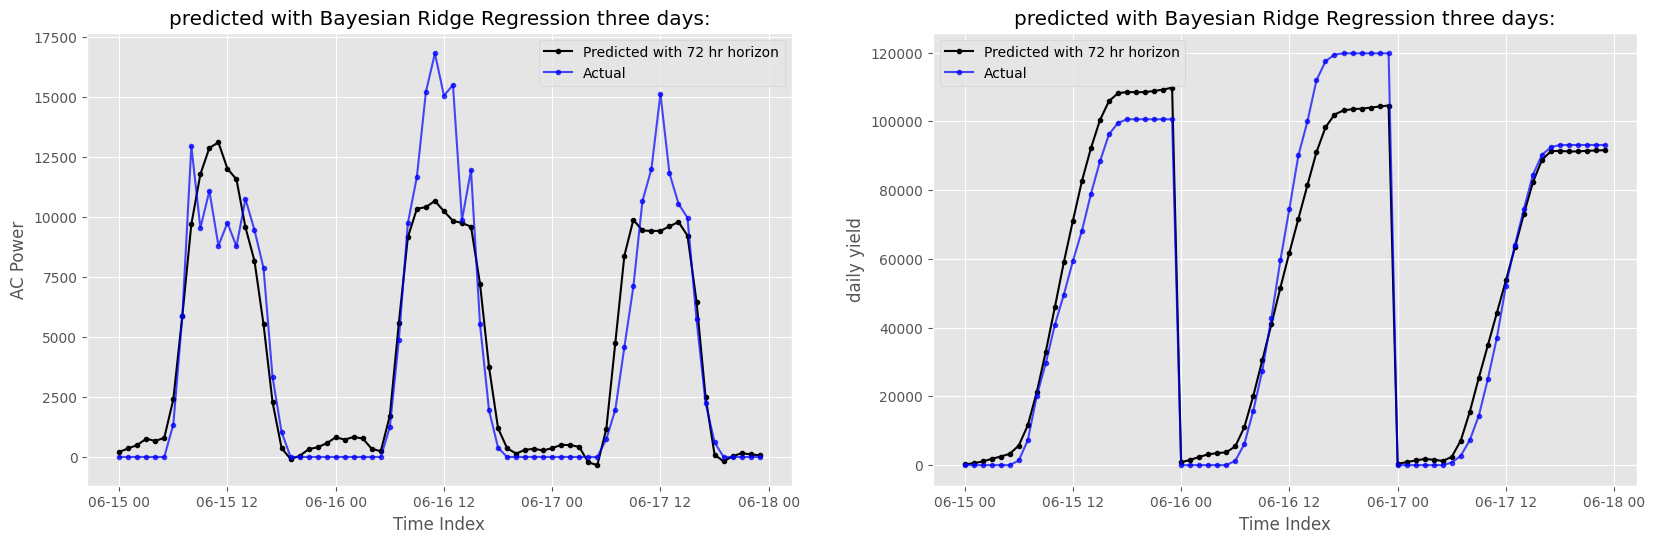

time: 656 ms (started: 2022-04-23 17:40:16 +02:00)


In [112]:
plot_pred_vs_actual(results_brr, 'Bayesian Ridge Regression three days:')

The three day predicition again looks quite good since it manages to predict the overall trend fairly well. And as already suspected, those predictions also look very similar to those of the SVM.

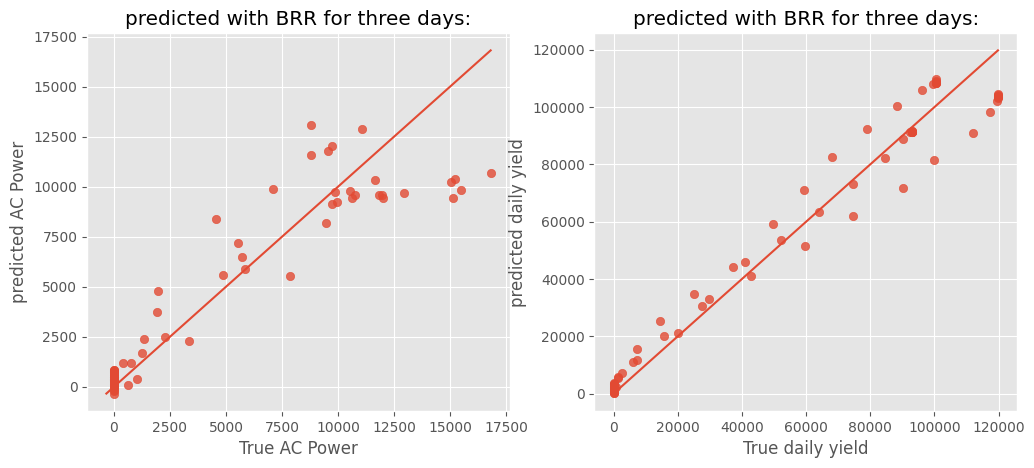

time: 453 ms (started: 2022-04-23 17:40:17 +02:00)


In [113]:
plot_accuracy(results_brr, 'BRR for three days:')

In [114]:
print_eval_scores(results_brr, 'Bayesian Ridge Regression', hourly = False)

Bayesian Ridge Regression three day prediction
AC power R2 score:        86.444%    MAE:  1288.83kW
daily yield R2 score:     96.358%    MAE:  6513.14kWh
time: 0 ns (started: 2022-04-23 17:40:19 +02:00)


## 3.6 Elastic Net

We will now try a further basic modelling aproach using elastic net regression. Therefore, we have to reset the train val test split again.

In [115]:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(dataX, dataY, val_start_dt = '2020-6-12 0:00', test_start_dt = '2020-06-15 0:00', val = True)

Train data shape:  (552, 2016) (552,)
Validation data shape:  (72, 2016) (72,)
Test data shape:  (72, 2016) (72,)
time: 47 ms (started: 2022-04-23 17:40:19 +02:00)


### 3.6.1 Model Creation

In [116]:

# Hyperparameters:
max_iter = 500
tol = 1e-5 # default = 1e-4
alpha = 1 # default = 1
l1_ratio = 0.5 # default = 0.5

en = ElasticNet(max_iter = max_iter, tol = tol, alpha = alpha, l1_ratio = l1_ratio)

model_en = en.fit(X_train, y_train)
model_prediction_scores(model_en, X_val, y_val, 'Elastic Net Regression')

-----------------------------------
Elastic Net Regression Training R^2 Score:  0.0
-----------------------------------
-----------------------------------
Elastic Net Regression Validation R^2 Score:  -0.025663377861869563
-----------------------------------
time: 140 ms (started: 2022-04-23 17:40:20 +02:00)


we can see that the basic elastic net regression does a very poor job at predicting.
>In fact, the R² score of 0 seems to imply that every prediction is the same and is simply the mean of all the true AC power values. For the formula of R², please see [Chapter 1.2](#12-choosing-a-measure-of-losssuccess). This is the first basic model that performs poorly so let´s find out if this holds true after the hyperparameter optimization.

### 3.6.1 Hyperparameter optimization

In [117]:
def objective(n_trials):
    if observe_hourly:
        params = {
            'alpha': n_trials.suggest_float('alpha', 0.001, 0.1, log = True),
            'l1_ratio': n_trials.suggest_float('l1_ratio', 1e-8, 1, log=True),
            'max_iter': 1000,
            'tol': 1e-5
        }
    else:
        params = {
            'alpha': n_trials.suggest_float('alpha', 1e-3, 0.1, log = True),
            'l1_ratio': n_trials.suggest_float('l1_ratio', 1e-2, 1, log=True),
            'max_iter': 1000,
            'tol': 1e-5
        }
    model = ElasticNet()
    model.set_params(**params)
    regressor = model.fit(X_train, y_train)
    y_pred = regressor.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse

time: 0 ns (started: 2022-04-23 17:40:21 +02:00)


In [118]:
study_en = op.create_study(direction="minimize")
study_en.optimize(objective, n_trials=100)
print(f"Optimized MSE: {study_en.best_value:.4f}")
print("Best params:")
for key, value in study_en.best_params.items():
    print(f"\t{key}: {value}")

[I 2022-04-23 17:40:21,916] A new study created in memory with name: no-name-278fc49d-25db-4dbd-88c4-45fb8a8920f4
C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1040689358334994, tolerance: 0.0004506953825711477

[I 2022-04-23 17:40:23,736] Trial 0 finished with value: 0.004233634593392924 and parameters: {'alpha': 0.08178836825908714, 'l1_ratio': 1.8908698496478955e-06}. Best is trial 0 with value: 0.004233634593392924.
C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9357802756140763, tolerance: 0.0004506953825711477

[I 2022-04-23 17:40:25,310] Trial 1 finished with value: 0.004302384556746346 and parameters: {'alpha': 0.0742613843

Optimized MSE: 0.0034
Best params:
	alpha: 0.00832114172770412
	l1_ratio: 2.3020853799188425e-07
time: 2min 54s (started: 2022-04-23 17:40:21 +02:00)


C:\Users\AEppl\AppData\Local\Temp\ipykernel_12056\1773732850.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



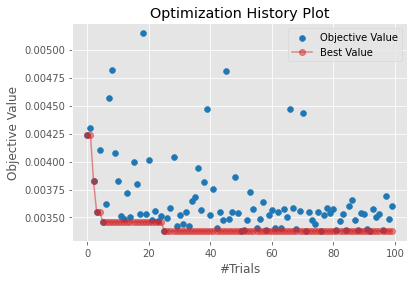

time: 313 ms (started: 2022-04-23 17:43:16 +02:00)


In [119]:
plot_optimization_history(study_en);

We can see that the alpha value has a very distinct curve that seems to be influenced very little by the l1_ratio parameter.

In [120]:
fig = op.visualization.plot_slice(study_en, params=['alpha', 'l1_ratio'])
fig.show()

time: 109 ms (started: 2022-04-23 17:43:17 +02:00)


In [121]:
model_en.set_params(**study_en.best_params)
model_en.fit(X_train, y_train)
model_prediction_scores(model_en, X_val, y_val, 'Elastic Net Regression')

-----------------------------------
Elastic Net Regression Training R^2 Score:  0.9613301780957465
-----------------------------------
-----------------------------------
Elastic Net Regression Validation R^2 Score:  0.930688745706828
-----------------------------------
time: 875 ms (started: 2022-04-23 17:43:17 +02:00)


C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2121473596304093, tolerance: 0.0004506953825711477



After optimization, the model shows R² values comparably to those of the other models. We will now use the whole training data again.

In [122]:
X_train, y_train, X_test, y_test = train_test_split(dataX, dataY, test_start_dt = '2020-06-15 0:00')
model_en.fit(X_train, y_train)

Train data shape:  (624, 2016) (624,)
Test data shape:  (72, 2016) (72,)


C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.354438181027111, tolerance: 0.0004890458999777662



ElasticNet(alpha=0.00832114172770412, l1_ratio=2.3020853799188425e-07,
           max_iter=500, tol=1e-05)

time: 1 s (started: 2022-04-23 17:43:19 +02:00)


### 3.6.2 Results hourly predictions

In [123]:
predictions = model_en.predict(X_test)
results_en_hourly = create_results_df(predictions, y_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-06-15 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 78 ms (started: 2022-04-23 17:43:20 +02:00)


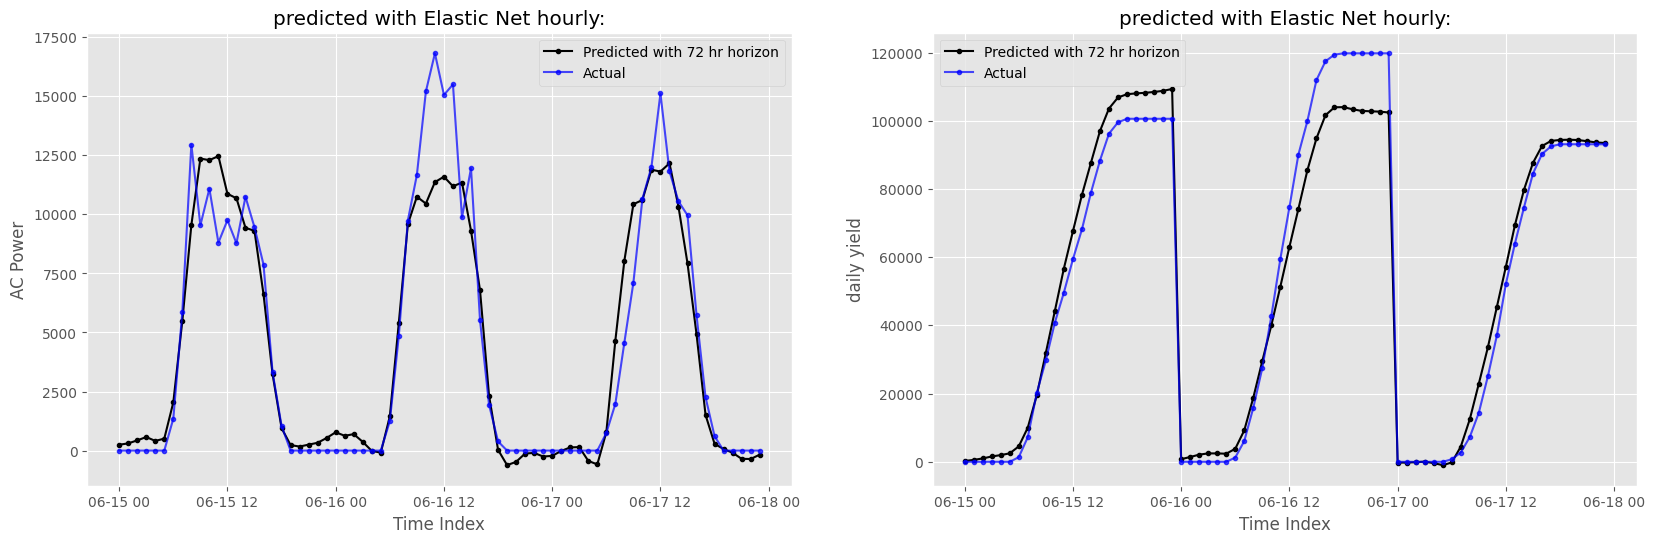

time: 703 ms (started: 2022-04-23 17:43:21 +02:00)


In [124]:
plot_pred_vs_actual(results_en_hourly, 'Elastic Net hourly:')

This looks very similar to both the other models again.

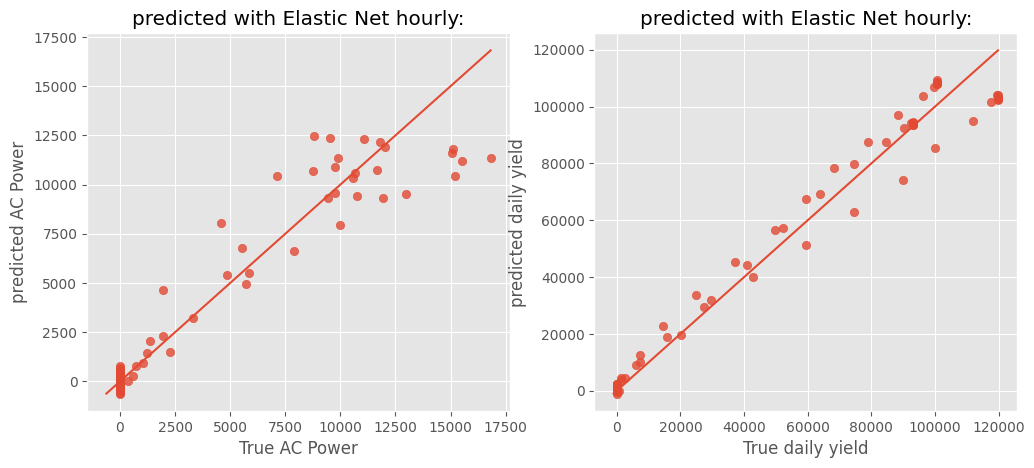

time: 672 ms (started: 2022-04-23 17:43:22 +02:00)


In [125]:
plot_accuracy(results_en_hourly, 'Elastic Net hourly:')

In [126]:
print_eval_scores(results_en_hourly, 'Elastic Net', hourly = True)

Elastic Net hourly prediction
AC power R2 score:        90.701%    MAE:  1002.47kW
daily yield R2 score:     97.056%    MAE:  5723.35kWh
time: 0 ns (started: 2022-04-23 17:43:23 +02:00)


### 3.6.3 Results three days

In [127]:
predictions = pred_three_days(model_en, test_weather_info, feature_df.shape[1])
results_en = create_results_df(predictions, y_test.copy(deep=True))


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-06-15 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 4.88 s (started: 2022-04-23 17:43:24 +02:00)


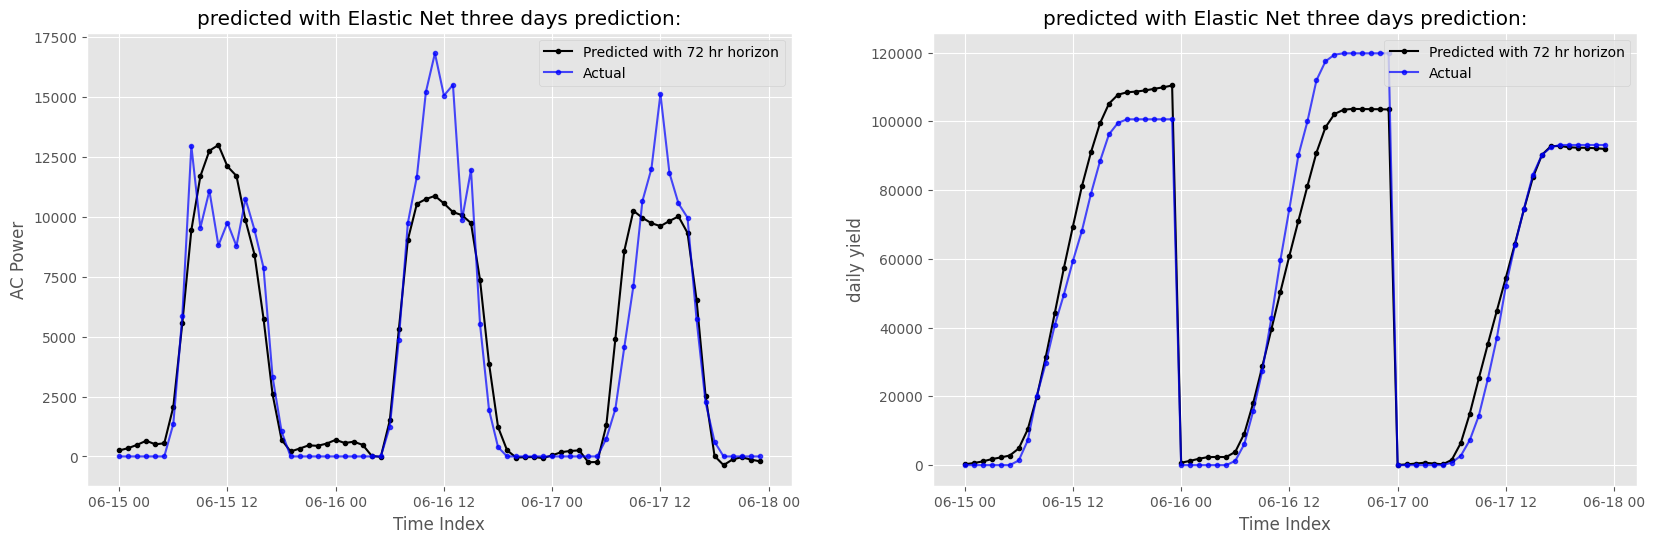

time: 828 ms (started: 2022-04-23 17:43:30 +02:00)


In [128]:
plot_pred_vs_actual(results_en, 'Elastic Net three days prediction:')

The three days predicitions again show a similar behaviour to the two previously investigated models.

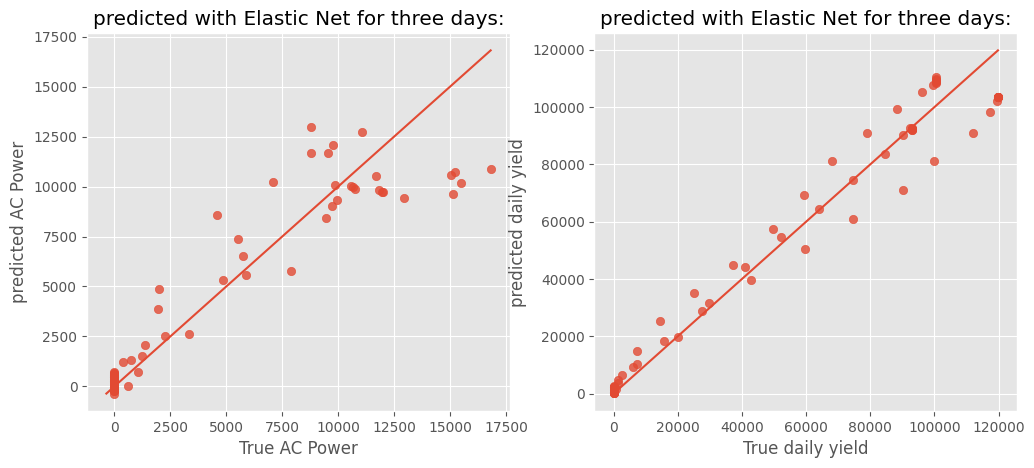

time: 515 ms (started: 2022-04-23 17:43:31 +02:00)


In [129]:
plot_accuracy(results_en, 'Elastic Net for three days:')

In [130]:
print_eval_scores(results_en, 'Elastic Net', hourly = False)

Elastic Net three day prediction
AC power R2 score:        87.362%    MAE:  1198.44kW
daily yield R2 score:     96.441%    MAE:  6048.59kWh
time: 16 ms (started: 2022-04-23 17:43:33 +02:00)


# 4: Testing Phase 2: Model Development

We will now investigate neural networks and with that, more complex model architectures. For this purpose, we first have to split up the training and validation data again.

In [131]:
# Train-Validation-Test Split:
X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(dataX, dataY, val_start_dt = '2020-6-12 0:00', test_start_dt = '2020-06-15 0:00', val = True)

Train data shape:  (552, 2016) (552,)
Validation data shape:  (72, 2016) (72,)
Test data shape:  (72, 2016) (72,)
time: 47 ms (started: 2022-04-23 17:43:34 +02:00)


## 4.1 Simple Neural Network

### 4.1.1 Create Neural Network Model

We will create the model function so that we can use it for hyperparameter optimization in a later step.

In [132]:
def build_model_nn(learning_rate, no_layers, neurons, dropout, activation):
    #Here we will use Sequential API
    model = models.Sequential()

    if activation in ['relu', 'selu', 'gelu']:
        model.add(layers.Dense(neurons, kernel_initializer="he_normal", input_shape=(X_train.shape[1],), activation = activation))
    elif activation == 'leaky_relu':
        model.add(layers.Dense(neurons, kernel_initializer="he_normal", input_shape=(X_train.shape[1],)))
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    else:
        model.add(layers.Dense(neurons, input_shape=(X_train.shape[1],), activation = activation))

    model.add(layers.Dropout(dropout))                        
    model.add(layers.BatchNormalization())

    for _ in range (no_layers):
        if activation in ['relu', 'selu', 'gelu']:
            model.add(layers.Dense(neurons, kernel_initializer="he_normal", activation = activation)) # , kernel_regularizer=regularizers.l2(0.0002)
        elif activation == 'leaky_relu':
            model.add(layers.Dense(neurons, kernel_initializer="he_normal")) # kernel_regularizer=regularizers.l2(0.0002),
            model.add(keras.layers.LeakyReLU(alpha=0.1))
        else:
            model.add(layers.Dense(neurons, activation = activation)) # kernel_regularizer=regularizers.l2(0.0002),
        model.add(layers.Dropout(dropout))
        model.add(layers.BatchNormalization())

    # here, we will use the fact that our model can only have positive values by using relu in the last activation layer
    model.add(layers.Dense(1, kernel_initializer="he_normal", activation = 'relu')) # kernel_regularizer=regularizers.l2(0.0002),

    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=['mse'], metrics=['mae'])
    return model

time: 0 ns (started: 2022-04-23 17:43:34 +02:00)


Let´s first create a basic model and see how well it performs:

In [133]:
#Looking at the graph:
build_model_nn(learning_rate = 0.001, no_layers = 4, neurons = 32, dropout = 0.2, activation = 'leaky_relu').summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                64544     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [134]:
#We will first create the object to feed fit() method:
myCheckpointNN= keras.callbacks.ModelCheckpoint("model_nn.h5", save_best_only=True)

time: 0 ns (started: 2022-04-23 17:43:57 +02:00)


In [135]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
early_stopping_patience = 20
myEarly_stoppingNN = keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

time: 0 ns (started: 2022-04-23 17:43:58 +02:00)


In [136]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 500
batch_size = 32

time: 0 ns (started: 2022-04-23 17:43:59 +02:00)


In [137]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_nn = build_model_nn(learning_rate = 0.001, no_layers = 4, neurons = 32, dropout = 0.2, activation = 'leaky_relu')

#Training step: Trains the model in silent mode (verbose = 0)
history_nn = model_nn.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val) , 
                                callbacks=[myCheckpointNN,myEarly_stoppingNN], verbose=2)

Epoch 1/500
18/18 - 1s - loss: 0.8382 - mae: 0.5548 - val_loss: 0.0961 - val_mae: 0.2365
Epoch 2/500
18/18 - 1s - loss: 0.5356 - mae: 0.4637 - val_loss: 0.0831 - val_mae: 0.1962
Epoch 3/500
18/18 - 0s - loss: 0.3863 - mae: 0.3955 - val_loss: 0.0889 - val_mae: 0.1930
Epoch 4/500
18/18 - 0s - loss: 0.3260 - mae: 0.3609 - val_loss: 0.0912 - val_mae: 0.2005
Epoch 5/500
18/18 - 0s - loss: 0.1988 - mae: 0.2895 - val_loss: 0.0914 - val_mae: 0.1983
Epoch 6/500
18/18 - 0s - loss: 0.1681 - mae: 0.2660 - val_loss: 0.0914 - val_mae: 0.1983
Epoch 7/500
18/18 - 0s - loss: 0.1790 - mae: 0.2698 - val_loss: 0.0914 - val_mae: 0.1983
Epoch 8/500
18/18 - 0s - loss: 0.1735 - mae: 0.2579 - val_loss: 0.0914 - val_mae: 0.1983
Epoch 9/500
18/18 - 1s - loss: 0.1781 - mae: 0.2697 - val_loss: 0.0914 - val_mae: 0.1983
Epoch 10/500
18/18 - 1s - loss: 0.1715 - mae: 0.2588 - val_loss: 0.0914 - val_mae: 0.1983
Epoch 11/500
18/18 - 0s - loss: 0.1484 - mae: 0.2503 - val_loss: 0.0907 - val_mae: 0.1975
Epoch 12/500
18/18 

In [138]:
#Calling back the best model:
model_nn = keras.models.load_model("model_nn.h5")

time: 1.2 s (started: 2022-04-23 17:45:19 +02:00)


In [139]:
#Let's look into the history recorded:
hist_nn = pd.DataFrame(history_nn.history)
#Adding epoch column:
hist_nn['epoch'] = history_nn.epoch
print("best epoch:")
hist_nn.iloc[-early_stopping_patience-1:-early_stopping_patience]

best epoch:


loss      mae  val_loss   val_mae  epoch
38  0.087467  0.17995  0.005995  0.045186     38

time: 15 ms (started: 2022-04-23 17:45:22 +02:00)


In [140]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'],history['loss'], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'],history['val_loss'], "b-.", linewidth=1.5, label="Validation")
  plt.legend()
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("Loss (MSE)")

time: 0 ns (started: 2022-04-23 17:45:23 +02:00)


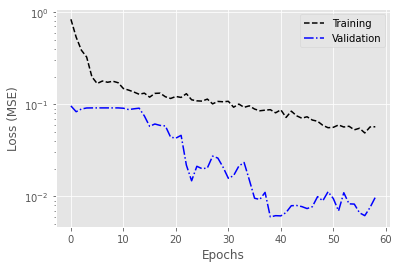

time: 656 ms (started: 2022-04-23 17:45:24 +02:00)


In [141]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_nn)

Possible explanations for the validation error being lower than the training error could be contributed to the regularization error or the fact that our validation set is more "regular" than the training set.

In [142]:
model_prediction_scores(model_nn, X_val, y_val, 'Neural Network')

-----------------------------------
Neural Network Training R^2 Score:  0.8643108448874572
-----------------------------------
-----------------------------------
Neural Network Validation R^2 Score:  0.8848860151509931
-----------------------------------
time: 687 ms (started: 2022-04-23 17:45:25 +02:00)


The validation R² score is comparable to that of the optimized simple models.

### 4.1.2 Hyperparameter optimization

With the help of Optuna, we will optimize the batch size, optimizer learning rate, the number of layers, the dropout rate as well as the activation function. 
* the batch size determines how many samples of the training data are processed before the error is used to update the weights.
* the optimizer learning rate specifies the magnitude with which the weights are updated
* number of layers refers to the number of hidden layers
* the dropout rate determines how many neurons are neglected randomly at each epoch randomly, which is a computationally cheap and remarkably effective regularization method.
* The activation function transforms the bundled input data of a neuron through its respective function. Below, you can find an overview of the different activation functions used. A linear activation function would be the same as no activation as the input of the activation remains the same as its output.

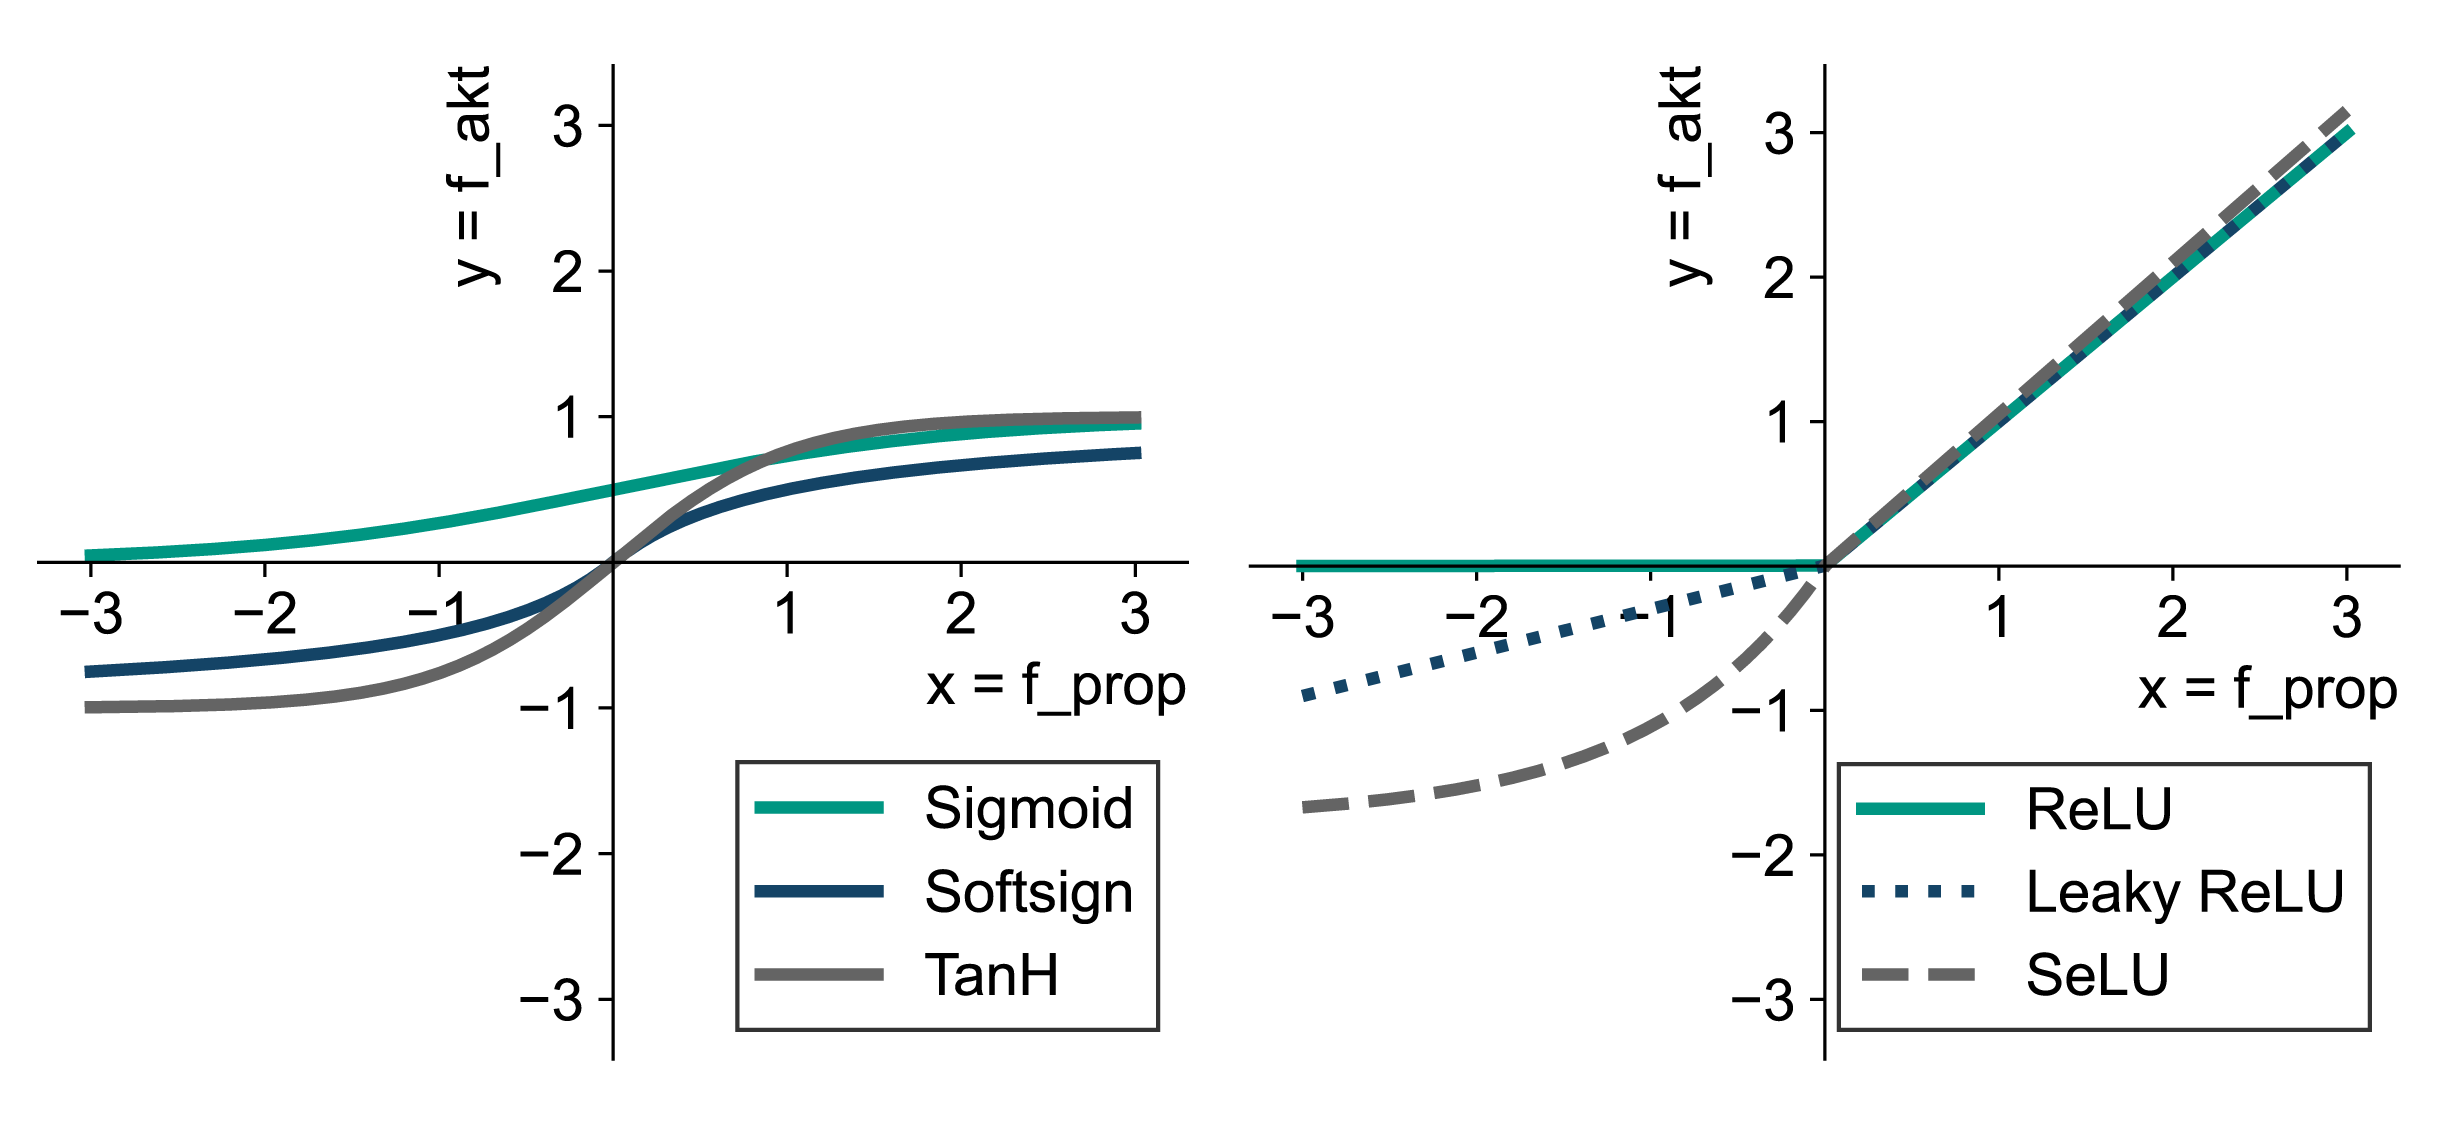

time: 32 ms (started: 2022-04-23 17:45:26 +02:00)


In [143]:
Image(data="activation functions.png", embed =True, width = 700)

We create an objective function in which we use the history object to gain the validation mse.

In [144]:
def objective_nn(n_trials):
    if observe_hourly:
        params = {
            'batch_size' : n_trials.suggest_categorical('batch_size', [2, 4, 8, 16, 32, 64, 128, 256]),
            'learning_rate' : n_trials.suggest_float('learning_rate', 1e-4, 1e-1, log = True),
            'no_layers' : n_trials.suggest_int('no_layers', 1, 4),
            'neurons' : 20, # n_trials.suggest_int('neurons', 5, 30, log = True),
            'dropout' : n_trials.suggest_float('dropout', 0.2, 0.5, log = True),
            'activation' : n_trials.suggest_categorical('activation', ['sigmoid', 'tanh', 'softsign', 'relu', 'leaky_relu'])
        }
    else:
        params = {
        'batch_size' : n_trials.suggest_categorical('batch_size', [8, 16, 32, 64, 128]),
        'learning_rate' : n_trials.suggest_float('learning_rate', 1e-4, 1e-1, log = True),
        'no_layers' : n_trials.suggest_int('no_layers', 1, 4),
        'neurons' : 20, # n_trials.suggest_int('neurons', 5, 30, log = True),
        'dropout' : n_trials.suggest_float('dropout', 0.2, 0.5, log = True),
        'activation' : n_trials.suggest_categorical('activation', ['sigmoid', 'tanh', 'softsign', 'relu', 'leaky_relu'])
    }
    model = build_model_nn(learning_rate = params['learning_rate'], no_layers = params['no_layers'], neurons = params['neurons'], 
                              dropout = params['dropout'], activation = params['activation'])
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=params['batch_size'], validation_data=(X_val, y_val) , 
                                callbacks=[myEarly_stoppingNN], verbose=0)

    mse = pd.DataFrame(history.history).iloc[-early_stopping_patience-1][2]
    return mse

time: 0 ns (started: 2022-04-23 17:45:28 +02:00)


In [145]:
study_nn = op.create_study(direction="minimize")
# setting garbage collector after each trial to true in order to avoid runout of memory (OOM)
study_nn.optimize(objective_nn, n_trials=70, gc_after_trial = True)  
print(f"Optimized MSE: {study_nn.best_value:.4f}")
print("Best params:")
for key, value in study_nn.best_params.items():
    print(f"\t{key}: {value}")

[I 2022-04-23 17:45:29,120] A new study created in memory with name: no-name-0a4eb669-506c-4ad5-bc3d-6526ef2a2ef1
[I 2022-04-23 17:45:50,040] Trial 0 finished with value: 0.006742415484040976 and parameters: {'batch_size': 256, 'learning_rate': 0.038783033392967785, 'no_layers': 4, 'dropout': 0.2781341302691945, 'activation': 'leaky_relu'}. Best is trial 0 with value: 0.006742415484040976.
[I 2022-04-23 17:46:00,456] Trial 1 finished with value: 0.04135812819004059 and parameters: {'batch_size': 256, 'learning_rate': 0.07754792591917181, 'no_layers': 2, 'dropout': 0.2808231950220491, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.006742415484040976.
[I 2022-04-23 17:46:39,183] Trial 2 finished with value: 0.004976542666554451 and parameters: {'batch_size': 4, 'learning_rate': 0.01312029787951757, 'no_layers': 2, 'dropout': 0.3053061424348809, 'activation': 'leaky_relu'}. Best is trial 2 with value: 0.004976542666554451.
[I 2022-04-23 17:46:51,528] Trial 3 finished with value: 

Optimized MSE: 0.0034
Best params:
	batch_size: 32
	learning_rate: 0.00609409176043943
	no_layers: 2
	dropout: 0.23723210611749948
	activation: leaky_relu
time: 24min 27s (started: 2022-04-23 17:45:29 +02:00)


C:\Users\AEppl\AppData\Local\Temp\ipykernel_12056\877311378.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



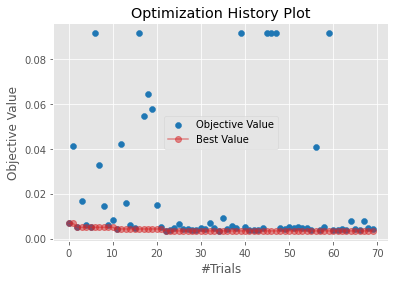

time: 313 ms (started: 2022-04-23 18:09:56 +02:00)


In [146]:
plot_optimization_history(study_nn);

We can see that as only one hidden layer with a fairly high dropout leads to the best results, larger models probably lead to problems with overfitting due to the relatively small training data size.What is further, the batch size has a clear minimum at 16 and has high effects on the result.

In [147]:
fig = op.visualization.plot_slice(study_nn)
fig.show()

time: 218 ms (started: 2022-04-23 18:09:57 +02:00)


In [148]:
myBestCheckpointNN = keras.callbacks.ModelCheckpoint("best_model_nn.h5", save_best_only=True)

time: 0 ns (started: 2022-04-23 18:09:58 +02:00)


Since Optuna does not store models, we have to retrain it, using the best parameters of the study.

In [149]:
model_nn = build_model_nn(learning_rate = study_nn.best_params['learning_rate'], no_layers = study_nn.best_params['no_layers'], 
                             neurons = 20, dropout = study_nn.best_params['dropout'], activation = study_nn.best_params['activation']) # study_nn.best_params['neurons']
history_nn = model_nn.fit(X_train, y_train, epochs=num_epochs, batch_size=study_nn.best_params['batch_size'], validation_data=(X_val, y_val), 
                          callbacks=[myBestCheckpointNN,myEarly_stoppingNN], verbose=2)

Epoch 1/500
18/18 - 1s - loss: 0.3901 - mae: 0.3882 - val_loss: 0.0914 - val_mae: 0.1983
Epoch 2/500
18/18 - 0s - loss: 0.1514 - mae: 0.2599 - val_loss: 0.0914 - val_mae: 0.1983
Epoch 3/500
18/18 - 0s - loss: 0.1322 - mae: 0.2335 - val_loss: 0.0914 - val_mae: 0.1983
Epoch 4/500
18/18 - 0s - loss: 0.1376 - mae: 0.2353 - val_loss: 0.0914 - val_mae: 0.1983
Epoch 5/500
18/18 - 1s - loss: 0.1275 - mae: 0.2267 - val_loss: 0.0914 - val_mae: 0.1983
Epoch 6/500
18/18 - 0s - loss: 0.1170 - mae: 0.2121 - val_loss: 0.0753 - val_mae: 0.1776
Epoch 7/500
18/18 - 0s - loss: 0.1206 - mae: 0.2140 - val_loss: 0.0407 - val_mae: 0.1216
Epoch 8/500
18/18 - 0s - loss: 0.0943 - mae: 0.1881 - val_loss: 0.0269 - val_mae: 0.0922
Epoch 9/500
18/18 - 0s - loss: 0.1024 - mae: 0.1916 - val_loss: 0.0357 - val_mae: 0.1044
Epoch 10/500
18/18 - 1s - loss: 0.0851 - mae: 0.1768 - val_loss: 0.0174 - val_mae: 0.0833
Epoch 11/500
18/18 - 0s - loss: 0.0857 - mae: 0.1744 - val_loss: 0.0066 - val_mae: 0.0475
Epoch 12/500
18/18 

In [150]:
#Let's look into the history recorded:
hist_nn = pd.DataFrame(history_nn.history)
#Adding epoch column:
hist_nn['epoch'] = history_nn.epoch
print("best epoch:")
hist_nn.iloc[-early_stopping_patience-1:-early_stopping_patience]

best epoch:


loss       mae  val_loss   val_mae  epoch
14  0.042992  0.117095  0.005222  0.042658     14

time: 0 ns (started: 2022-04-23 18:10:17 +02:00)


the validation loss which is fairly similar to that during the study shows that the model seems to find its minimum reliably.

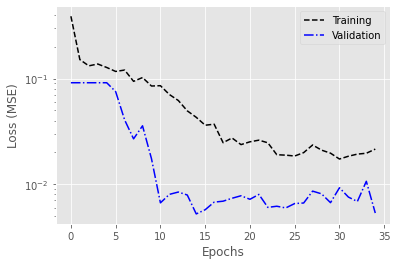

time: 672 ms (started: 2022-04-23 18:10:18 +02:00)


In [151]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_nn)

The training takes longer than that of the "vanilla model" and the curves look less smooth which can be contributed to the smaller batch size and higher learning rate.

In [152]:
model_nn = keras.models.load_model("best_model_nn.h5")
model_prediction_scores(model_nn, X_val, y_val, 'Neural Network')

-----------------------------------
Neural Network Training R^2 Score:  0.8390250310138986
-----------------------------------
-----------------------------------
Neural Network Validation R^2 Score:  0.8997372961463107
-----------------------------------
time: 828 ms (started: 2022-04-23 18:10:19 +02:00)


We can see that not only the validation error improved, however slightly but also the training error increased which probably leads to better generizability of the model.

In [153]:
predictions = pd.Series(model_nn.predict(X_test).flatten(),index=X_test.index)
results_nn_hourly = create_results_df(predictions, y_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-06-15 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float32
 1   actual      72 non-null     float64
dtypes: float32(1), float64(1)
memory usage: 1.4 KB
time: 140 ms (started: 2022-04-23 18:10:21 +02:00)


### 4.1.2 Results hourly forecast

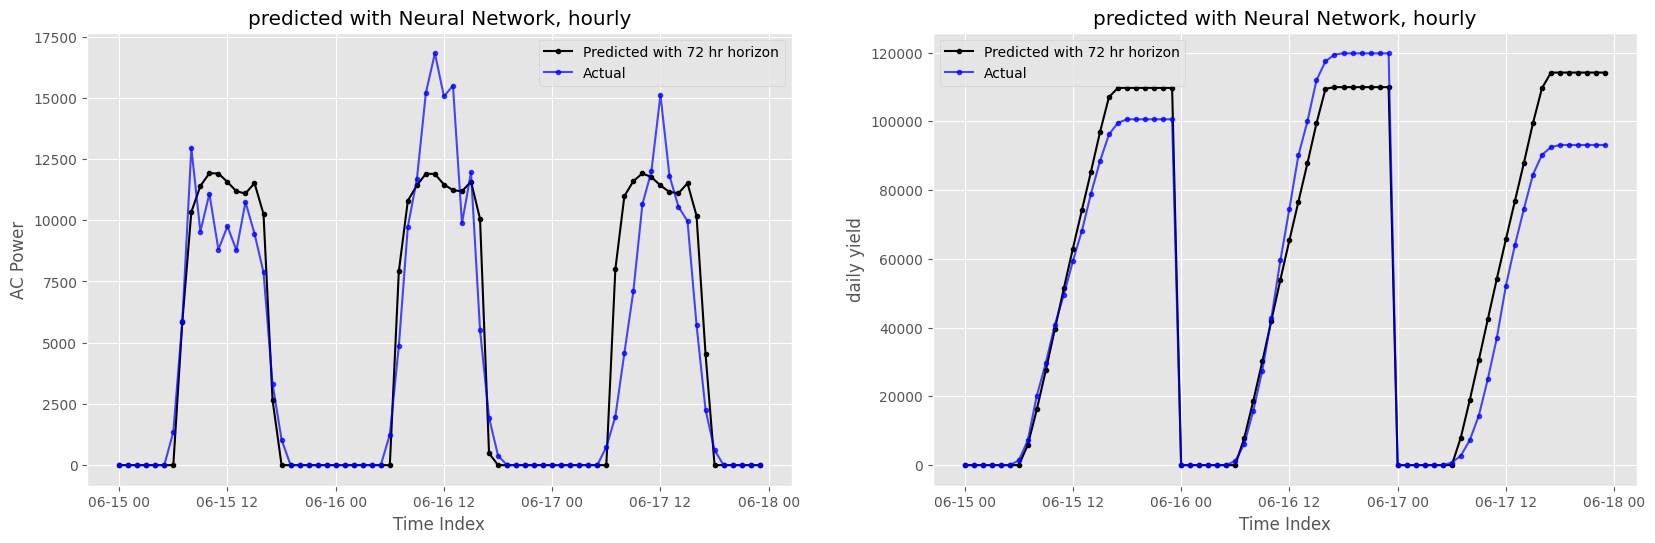

time: 562 ms (started: 2022-04-23 18:10:21 +02:00)


In [154]:
plot_pred_vs_actual(results_nn_hourly, 'Neural Network, hourly')

Similar to the simple models, the daily trend is cought well while the midday hour fluctuations could not be cought.

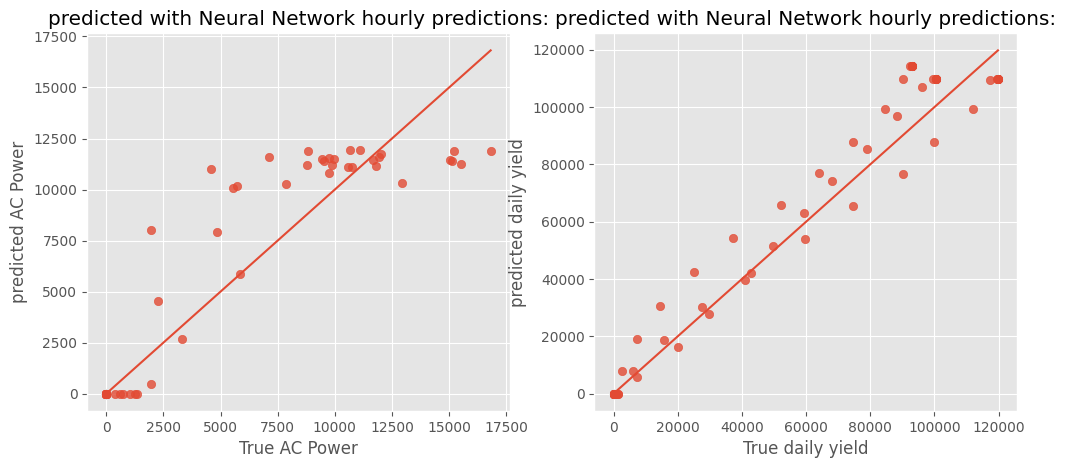

time: 500 ms (started: 2022-04-23 18:10:23 +02:00)


In [155]:
plot_accuracy(results_nn_hourly, 'Neural Network hourly predictions:')

In [156]:
print_eval_scores(results_nn_hourly, 'Neural Network', hourly = True)

Neural Network hourly prediction
AC power R2 score:        85.903%    MAE:  1156.08kW
daily yield R2 score:     94.991%    MAE:  7523.27kWh
time: 0 ns (started: 2022-04-23 18:10:23 +02:00)


The model scores are better than those of the simple models, if only slightly.

In [157]:
predictions = pred_three_days(model_nn, test_weather_info, feature_df.shape[1])
results_nn = create_results_df(predictions, y_test.copy(deep=True))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2020-06-15 00:00:00 to 2020-06-17 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
time: 8.12 s (started: 2022-04-23 18:10:24 +02:00)


### 4.1.3 Results Three Days Forecast

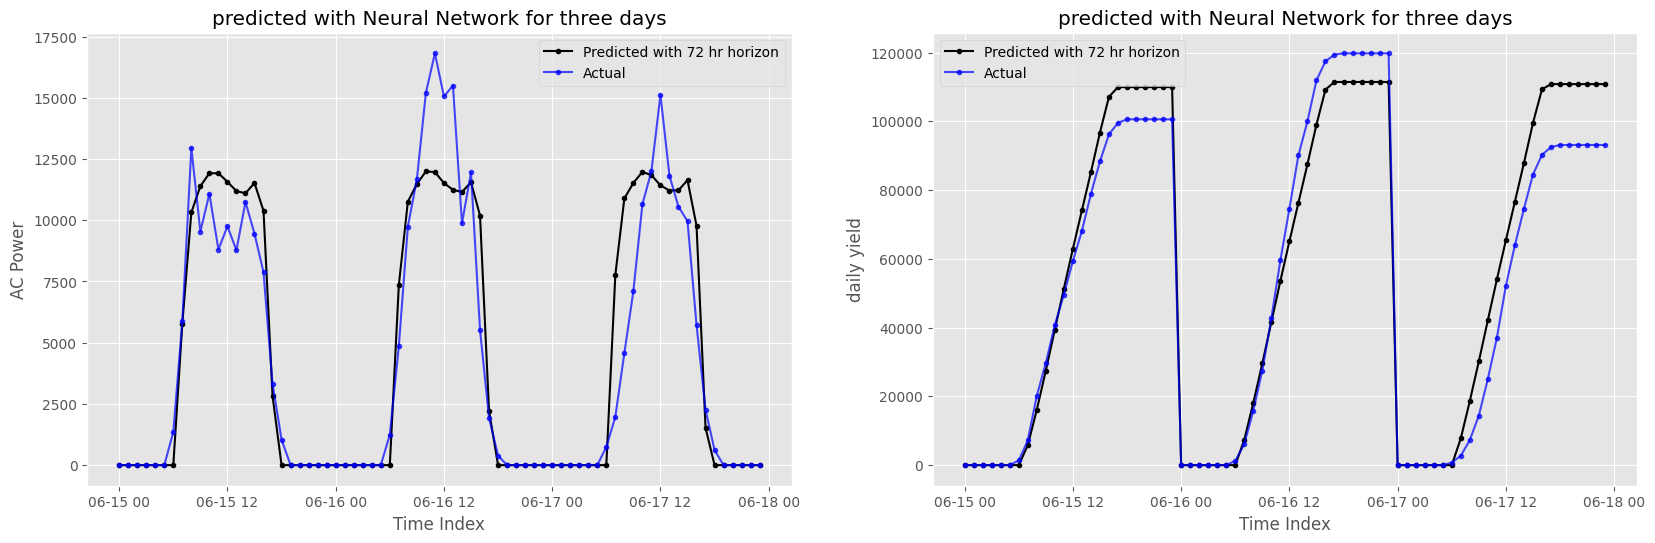

time: 796 ms (started: 2022-04-23 18:10:33 +02:00)


In [158]:
plot_pred_vs_actual(results_nn, 'Neural Network for three days')

Again, the three days prediction capabilities of the model are fairly well.

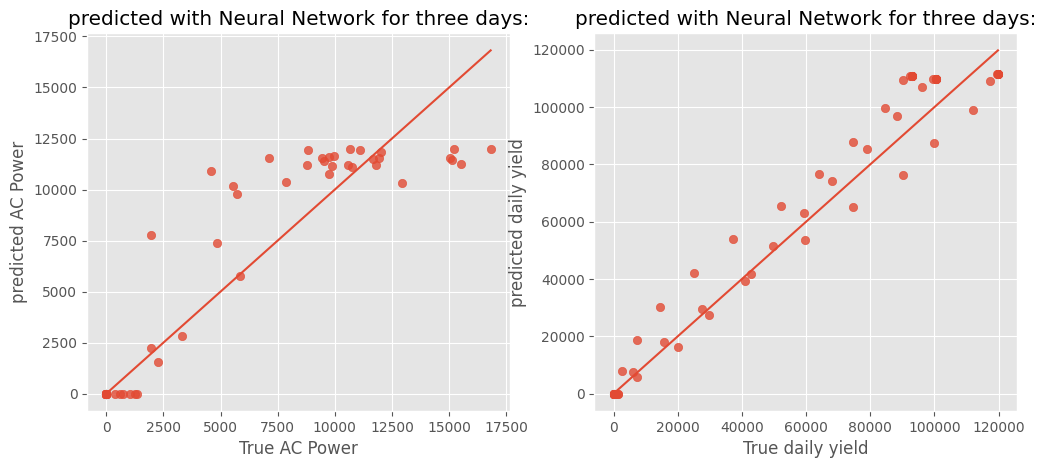

time: 906 ms (started: 2022-04-23 18:10:35 +02:00)


In [159]:
plot_accuracy(results_nn, 'Neural Network for three days:')

In [160]:
print_eval_scores(results_nn, 'Neural Network', hourly = False)

Neural Network three day prediction
AC power R2 score:        86.753%    MAE:  1099.99kW
daily yield R2 score:     95.728%    MAE:  7049.81kWh
time: 0 ns (started: 2022-04-23 18:10:37 +02:00)


This leads to still good prediction errors.

## 4.2 LSTM

Let´s now see how a model created explicitly for time series predictions performs:

### 4.2.1 Reshaping the data

We will first transform the data into its required format:

In [161]:
feature_df.head(2)

AC_POWER  AMBIENT_TEMPERATURE  IRRADIATION       mean_2h  \
2020-05-17 00:00:00       0.0             0.271576          0.0  2.479299e-16   
2020-05-17 01:00:00       0.0             0.231820          0.0  2.479299e-16   

                     median_2h        std_2h  min_2h  max_2h  mean_4h  \
2020-05-17 00:00:00        0.0  2.327949e-08     0.0     0.0      0.0   
2020-05-17 01:00:00        0.0  2.327949e-08     0.0     0.0      0.0   

                     median_4h  ...  mean_24h  median_24h   std_24h  min_24h  \
2020-05-17 00:00:00        0.0  ...  0.234696    0.000177  0.310507      0.0   
2020-05-17 01:00:00        0.0  ...  0.234696    0.000177  0.310507      0.0   

                      max_24h  mean_48h  median_48h   std_48h  min_48h  \
2020-05-17 00:00:00  0.838014  0.260481    0.009514  0.323932      0.0   
2020-05-17 01:00:00  0.838014  0.260481    0.009514  0.323932      0.0   

                      max_48h  
2020-05-17 00:00:00  0.838014  
2020-05-17 01:00:00  0.838014  

[2 rows x 28 columns]

time: 31 ms (started: 2022-04-23 18:10:38 +02:00)


In [162]:
dataY_temporal = feature_df[forecast_variable]
dataX_temporal = feature_df.drop(forecast_variable, axis = 1)
X_train0, y_train0, X_val0, y_val0, X_test0, y_test0 = train_test_split(dataX_temporal, dataY_temporal, val_start_dt = '2020-6-10 0:00', test_start_dt = '2020-06-14 0:00', val = True)

Train data shape:  (576, 27) (576,)
Validation data shape:  (96, 27) (96,)
Test data shape:  (96, 27) (96,)
time: 0 ns (started: 2022-04-23 18:10:39 +02:00)


In [163]:
#Reshaping the 2D [samples, features] data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
def dimension_fix(train, label, n_input = 24, n_output=24, batch_size = 32):

  #Preparing the time stamps:
  label_index = label.index

  train = train.to_numpy()
  label = label.to_numpy()
  X, y = list(), list()

# looping one time step at a time:
  for i_start in range(len(train)):
  # define the end of the sequence
    i_end = i_start + n_input
  # ensure we have enough data
    if i_end <= len(train):
      X.append(train[i_start:i_end, :])

#------------------------------------------------------

  for i_start in range(len(label)):
  # define the end of the input sequence
    i_end = i_start + n_input - 1
    out_end = i_end + n_output
  # ensure we have enough data
    if out_end <= len(label):
      y.append(label[i_end:out_end])
  #------------------------#
  #--------Clean up--------#
  #------------------------#
  #we need to omit the data that does not have labels:
  if n_output > 1:
    ranged = [i for i in range(-1,-n_output,-1)]
    X = np.delete(X, ranged, axis=0)

  # finding the remain wrt batch size (assumed 32 here)
  reminder_elements = len(X)%batch_size
  #filtering the matrices: creating a range
  ranged_x = [-i for i in range(reminder_elements)]
  ranged_y = [-i for i in range(reminder_elements)]
  #Filtering X:
  X = np.delete(X, ranged_x, axis=0)
  #Filtering y: due to the n_input shift
  label_index = label_index[n_input:]
  #Filtering y: due to mod operation
  y = np.delete(y, ranged_y, axis=0)
  label_index = label_index[0:len(y)]

  return np.array(X), np.array(y), label_index


time: 0 ns (started: 2022-04-23 18:10:39 +02:00)


In [164]:
#Reshaping the 2D data into 3D:[samples, timesteps, features]
#Note that reshape is no longer available in Pandas; this is why we convert it to numpy
#array first.
if observe_hourly: scaling = 1
else: scaling = 4

batch_size = 36

X_train, y_train, iy_train  = dimension_fix(X_train0, y_train0, 24*scaling, 1, batch_size)
X_val, y_val, iy_val = dimension_fix(X_val0, y_val0, 24*scaling, 1, batch_size)
X_test, y_test, iy_test = dimension_fix(X_test0, y_test0, 24*scaling, 1, batch_size)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
print(iy_train.shape, iy_val.shape, iy_test.shape)

(540, 24, 27) (540, 1) (72, 24, 27) (72, 1) (72, 24, 27) (72, 1)
(540,) (72,) (72,)
time: 31 ms (started: 2022-04-23 18:10:40 +02:00)


In [165]:
#Check the shifts by 24 hours, since AC_power for nighttime hours is zero, we will make a shift to daytime
shift = 12*scaling

print(iy_test[0+shift],y_test[0+shift])
print(iy_test[1+shift],y_test[1+shift])
print(iy_test[2+shift],y_test[2+shift])

2020-06-15 12:00:00 [0.41303841]
2020-06-15 13:00:00 [0.371578]
2020-06-15 14:00:00 [0.45507558]
time: 16 ms (started: 2022-04-23 18:10:41 +02:00)


In [166]:
#Original dataset:
print(y_test0[24*scaling+shift:len(y_test)+24*scaling+shift].iloc[:3])

2020-06-15 12:00:00    0.413038
2020-06-15 13:00:00    0.371578
2020-06-15 14:00:00    0.455076
Freq: H, Name: AC_POWER, dtype: float64
time: 0 ns (started: 2022-04-23 18:10:42 +02:00)


### 4.2.2 Model Creation

Similar to the neural network, the model creation function is already suited for hyperparameter optimization

In [167]:
def build_model_lstm(learning_rate, no_layers, neurons, dropout, activation, batch_size = None):
    #Here we will use Sequential API
    if batch_size == None: stateful = False
    else: stateful = True
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model = models.Sequential()
    if activation in ['relu', 'selu']:
        model.add(layers.LSTM(neurons, kernel_initializer="he_normal", return_sequences=True, batch_input_shape=(batch_size, None, n_features), stateful=stateful, activation = activation))
    elif activation == 'leaky_relu':
        model.add(layers.LSTM(neurons, kernel_initializer="he_normal", return_sequences=True, batch_input_shape=(batch_size, None, n_features), stateful=stateful))
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    else:
        model.add(layers.LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, None, n_features), stateful=stateful, activation = activation))

    for layer in range (no_layers):
        return_sequences = True
        if layer == no_layers-1: return_sequences = stateful
        if activation in ['relu', 'selu', 'gelu']:
            model.add(layers.LSTM(neurons, return_sequences=return_sequences, stateful=stateful, kernel_initializer="he_normal", activation = activation))
        elif activation == 'leaky_relu':
            model.add(layers.LSTM(neurons, return_sequences=return_sequences, stateful=stateful, kernel_initializer="he_normal"))
            model.add(keras.layers.LeakyReLU(alpha=0.1))
        else:
            model.add(layers.LSTM(neurons, return_sequences=return_sequences, stateful=stateful, activation = activation))
        model.add(layers.Dropout(dropout))

    # here, we will use the fact that our model can only have positive values by using relu in the last activation layer
    model.add(layers.Dense(1, kernel_initializer="he_normal", activation = 'relu'))

    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=['mse'], metrics=['mae'])
    return model

time: 16 ms (started: 2022-04-23 18:10:42 +02:00)


In [168]:
#Looking at the graph:
build_model_lstm(0.001, 4, 32, 0.2, 'tanh', batch_size = batch_size).summary()

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (36, None, 32)            7680      
_________________________________________________________________
lstm_1 (LSTM)                (36, None, 32)            8320      
_________________________________________________________________
dropout_215 (Dropout)        (36, None, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (36, None, 32)            8320      
_________________________________________________________________
dropout_216 (Dropout)        (36, None, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (36, None, 32)            8320      
_________________________________________________________________
dropout_217 (Dropout)        (36, None, 32)          

In [169]:
#We will first create the object to feed fit() method:
myCheckpointLSTM = keras.callbacks.ModelCheckpoint("model_lstm.h5", save_best_only=True)

time: 0 ns (started: 2022-04-23 18:10:47 +02:00)


In [170]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
early_stopping_patience = 20
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=early_stopping_patience,restore_best_weights=True)

time: 0 ns (started: 2022-04-23 18:10:48 +02:00)


As model training takes much longer, we will set a smaller maximum number of epochs.

In [171]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 150
batch_size = 36

time: 0 ns (started: 2022-04-23 18:10:49 +02:00)


In [172]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_lstm = build_model_lstm(0.001, 4, 32, 0.2, 'tanh', batch_size = batch_size)
#Training step: Trains the model in silent mode (verbose = 0)
history_lstm = model_lstm.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM])#, verbose=0)
#Calling back the best model:
model_lstm = keras.models.load_model("model_lstm.h5")


Epoch 1/150
15/15 [==============================] - 3s 233ms/step - loss: 0.0934 - mae: 0.2563 - val_loss: 0.0418 - val_mae: 0.1744
Epoch 2/150
15/15 [==============================] - 1s 40ms/step - loss: 0.0788 - mae: 0.2454 - val_loss: 0.0403 - val_mae: 0.1660
Epoch 3/150
15/15 [==============================] - 0s 31ms/step - loss: 0.0775 - mae: 0.2275 - val_loss: 0.0512 - val_mae: 0.1717
Epoch 4/150
15/15 [==============================] - 1s 34ms/step - loss: 0.0829 - mae: 0.2331 - val_loss: 0.0437 - val_mae: 0.1610
Epoch 5/150
15/15 [==============================] - 0s 31ms/step - loss: 0.0825 - mae: 0.2375 - val_loss: 0.0443 - val_mae: 0.1611
Epoch 6/150
15/15 [==============================] - 0s 30ms/step - loss: 0.0810 - mae: 0.2415 - val_loss: 0.0481 - val_mae: 0.1653
Epoch 7/150
15/15 [==============================] - 1s 39ms/step - loss: 0.0793 - mae: 0.2317 - val_loss: 0.0410 - val_mae: 0.1656
Epoch 8/150
15/15 [==============================] - 1s 34ms/step - loss: 0

In [173]:
#Let's look into the history recorded:
hist_lstm = pd.DataFrame(history_lstm.history)
#Adding epoch column:
hist_lstm['epoch'] = history_lstm.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist_lstm.sample(3)
hist_lstm.iloc[-early_stopping_patience-1:-early_stopping_patience]

loss       mae  val_loss   val_mae  epoch
33  0.078267  0.243345  0.038268  0.173129     33

time: 16 ms (started: 2022-04-23 18:12:22 +02:00)


the losses of the vanilla model are compareable to those of the neural network

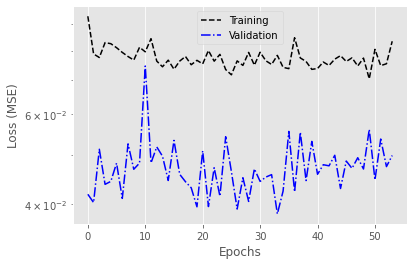

time: 407 ms (started: 2022-04-23 18:12:23 +02:00)


In [174]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_lstm)

In [175]:
model_prediction_scores(model_lstm, X_val, y_val, 'LSTM')

InvalidArgumentError:  [_Derived_]  Invalid input_h shape: [1,36,32] [1,32,32]
	 [[{{node CudnnRNN}}]]
	 [[sequential_74/lstm_5/StatefulPartitionedCall]] [Op:__inference_predict_function_820140]

Function call stack:
predict_function -> predict_function -> predict_function


time: 7.47 s (started: 2022-04-23 18:12:24 +02:00)


### 4.2.3 Hyperparameter optimization

In [ ]:
def objective_lstm(n_trials):
    if observe_hourly:
        params = {
            'batch_size' : n_trials.suggest_categorical('batch_size', [18, 36, 72]),
            'learning_rate' : n_trials.suggest_float('learning_rate', 1e-3, 1e-1, log = True),
            'no_layers' : n_trials.suggest_int('no_layers', 1, 4),
            'neurons' : 32, # n_trials.suggest_int('neurons', 5, 30, log = True),
            'dropout' : n_trials.suggest_float('dropout', 0.2, 0.5, log = True),
            'activation' : n_trials.suggest_categorical('activation', ['sigmoid', 'tanh', 'softsign', 'relu', 'leaky_relu'])
        }
    else:
        params = {
            'batch_size' : n_trials.suggest_categorical('batch_size', [18, 36, 72, 144]),
            'learning_rate' : n_trials.suggest_float('learning_rate', 1e-4, 1e-1, log = True),
            'no_layers' : n_trials.suggest_int('no_layers', 1, 4),
            'neurons' : 32, # n_trials.suggest_int('neurons', 5, 30, log = True),
            'dropout' : n_trials.suggest_float('dropout', 0.2, 0.5, log = True),
            'activation' : n_trials.suggest_categorical('activation', ['sigmoid', 'tanh', 'softsign', 'relu', 'leaky_relu'])
        }
    print(params)

    X_train, y_train, iy_train  = dimension_fix(X_train0, y_train0, 24*scaling, 1, batch_size)
    X_val, y_val, iy_val = dimension_fix(X_val0, y_val0, 24*scaling, 1, batch_size)

    model = build_model_lstm(learning_rate = params['learning_rate'], no_layers = params['no_layers'], neurons = params['neurons'], 
                              dropout = params['dropout'], activation = params['activation'], batch_size=params['batch_size'])
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=params['batch_size'], validation_data=(X_val, y_val) , 
                                callbacks=[myEarly_stoppingLSTM], verbose=0)

    mse = pd.DataFrame(history.history).iloc[-early_stopping_patience-1][2]
    return mse

Unfortunately, using different activation functions than tanh creates a lot of warnings since Keras cannot use all of its underlying calculatory tricks and speedups so the output is very long. However, the additional coumputation time in fact did not make that much of a difference.

In [ ]:
study_lstm = op.create_study(direction="minimize")
# setting garbage collector after each trial to true in order to avoid runout of memory (OOM)
study_lstm.optimize(objective_lstm, n_trials=70, gc_after_trial = True)  
print(f"Optimized MSE: {study_lstm.best_value:.4f}")
print("Best params:")
for key, value in study_lstm.best_params.items():
    print(f"\t{key}: {value}")

Possibly, smaller batch sizes would have led to even better scores but as the training was already taking a lot of time it was decided that the errors are already low enough (mse is smaller by factor of 10 compared to classic neural network). Also, varying the activation function had a great influence, if not as great as that of the number of layers used

In [ ]:
fig = op.visualization.plot_slice(study_lstm)
fig.show()

In [ ]:
myBestCheckpointLSTM = keras.callbacks.ModelCheckpoint("best_model_lstm.h5", save_best_only=True)

In [ ]:
X_train, y_train, iy_train  = dimension_fix(X_train0, y_train0, 24*scaling, 1, study_lstm.best_params['batch_size'])
X_val, y_val, iy_val = dimension_fix(X_val0, y_val0, 24*scaling, 1, study_lstm.best_params['batch_size'])
X_test, y_test, iy_test = dimension_fix(X_test0, y_test0, 24*scaling, 1, study_lstm.best_params['batch_size'])

model_lstm = build_model_lstm(learning_rate = study_lstm.best_params['learning_rate'], no_layers = study_lstm.best_params['no_layers'], 
                             neurons = 32, dropout = study_lstm.best_params['dropout'], activation = study_lstm.best_params['activation']) #study_lstm.best_params['neurons']
history_lstm = model_lstm.fit(X_train, y_train, epochs=num_epochs, batch_size=study_lstm.best_params['batch_size'], validation_data=(X_val, y_val) , 
                          callbacks=[myBestCheckpointLSTM,myEarly_stoppingLSTM], verbose=2)

In [ ]:
#Let's look into the history recorded:
hist_lstm = pd.DataFrame(history_lstm.history)
#Adding epoch column:
hist_lstm['epoch'] = history_lstm.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist_lstm.sample(3)
hist_lstm.iloc[-early_stopping_patience-1:-early_stopping_patience]

the loss is a little higher than during the study, however this should be neglectable

In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_lstm)

In [ ]:
model_lstm = keras.models.load_model("best_model_lstm.h5")
model_prediction_scores(model_lstm, X_val, y_val, 'LSTM')

The training and validation R² scores are very promising, lets now take a look at the test data:

In [176]:
#Label and indices:
#Since we have shifted the data by 4 width windows, initial label DF is to be filtered.
y_test_filtered = y_test0.loc[iy_test]
y_test_filtered

2020-06-15 00:00:00    0.0
2020-06-15 01:00:00    0.0
2020-06-15 02:00:00    0.0
2020-06-15 03:00:00    0.0
2020-06-15 04:00:00    0.0
                      ... 
2020-06-17 19:00:00    0.0
2020-06-17 20:00:00    0.0
2020-06-17 21:00:00    0.0
2020-06-17 22:00:00    0.0
2020-06-17 23:00:00    0.0
Freq: H, Name: AC_POWER, Length: 72, dtype: float64

time: 531 ms (started: 2022-04-24 09:43:46 +02:00)


In [177]:
predictions = pd.Series(model_lstm.predict(X_test.flatten()),index=y_test_filtered.index)
results_lstm_hourly = create_results_df(predictions, y_test_filtered)

ValueError: in user code:

    C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1122 predict_step  **
        return self(x, training=False)
    C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\AEppl\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_74 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [32, 1]


time: 3.2 s (started: 2022-04-24 09:43:49 +02:00)


### 4.2.4 Results hourly forecast

In [ ]:
plot_pred_vs_actual(results_lstm_hourly, 'LSTM, hourly')

We can see that the LSTM is the first model that not only manages to catch the daily trend but also very accurately catches the hourly fluctuations. Differences between the actual and predicted values are minimal.

In [ ]:
plot_accuracy(results_lstm_hourly, 'LSTM hourly predictions:')

In [ ]:
print_eval_scores(results_lstm_hourly, 'LSTM', hourly = True)

As expected from our plots, the hourly R² score is nearly 100 % 

### 4.2.5 Results three days

Let´s see wether the three day predictions are as good as the hourly ones:

In [ ]:
def pred_three_days(model, test_weather_info, n_features):
    # series to store the predicted values
    test_weather = test_weather_info.copy(deep = True)
    y_predicted =pd.Series(index=y_test_filtered.index, dtype='float64')
    X_test_last = X_test[0].reshape((1,X_test[0].shape[0], X_test[0].shape[1]))
    for case_index in y_test_filtered.index:
    # predicting with trained input model
        prediction = model.predict(X_test_last).flatten()[0]
        # print(prediction)
        y_predicted.update(pd.Series(prediction,index=[case_index]))
        test_weather.loc[case_index, forecast_variable] = prediction
        update_next_hour = create_feature_df(test_weather)
        
        test_weather = test_weather.iloc[1:, :]
        # updating X_test_last with new values
        for i in range (X_test_last.shape[1]-1):
            X_test_last[0][i] = X_test_last[0][i+1]
        for i in range(update_next_hour.shape[1]-1):
            X_test_last[0][X_test_last.shape[1]-1][i] = update_next_hour.iloc[0,i]
    return y_predicted

In [ ]:
X_test_last = X_test[0].reshape((1,X_test[0].shape[0], X_test[0].shape[1]))
X_test_last.shape

In [ ]:
predictions = pred_three_days(model_lstm, test_weather_info, feature_df.shape[1])
results_lstm = create_results_df(predictions, y_test_filtered.copy(deep=True))

In [ ]:
plot_pred_vs_actual(results_lstm, 'LSTM three days prediction:')

Unfortunately, the model fails drastically at prdicting longer periods of time. Even though it still kind of catches the hourly peaks, the model fails at predicting the general daily trends.

In [ ]:
plot_accuracy(results_lstm, 'LSTM for three days:')

In [ ]:
print_eval_scores(results_lstm, 'LSTM', hourly = False)

As was to be expected, the scores are pretty bad.

## 4.3 GRU

As a final model, we will asses the GRU as it is typically better for smaller datasets and therefore should be even better than the LSTM. Maybe this will show in its multi day forecasting.

### 4.3.1 Model Creation

In [ ]:
def build_model_gru(learning_rate, no_layers, neurons, dropout, activation):
    #Here we will use Sequential API
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model = models.Sequential()
    if activation in ['relu', 'selu']:
        model.add(layers.GRU(neurons, kernel_initializer="he_normal", return_sequences=True, input_shape=(None, n_features), stateful=False, activation = activation))
    elif activation == 'leaky_relu':
        model.add(layers.GRU(neurons, kernel_initializer="he_normal", return_sequences=True, input_shape=(None, n_features), stateful=False))
        model.add(keras.layers.LeakyReLU(alpha=0.1))
    else:
        model.add(layers.GRU(neurons, return_sequences=True, input_shape=(None, n_features), stateful=False, activation = activation))
    model.add(layers.Dropout(dropout))

    for layer in range (no_layers):
        return_sequences = True
        if layer == no_layers-1: return_sequences = False
        if activation in ['relu', 'selu', 'gelu']:
            model.add(layers.GRU(neurons, return_sequences=return_sequences, stateful=False, kernel_initializer="he_normal", activation = activation))
        elif activation == 'leaky_relu':
            model.add(layers.GRU(neurons, return_sequences=return_sequences, stateful=False, kernel_initializer="he_normal"))
            model.add(keras.layers.LeakyReLU(alpha=0.1))
        else:
            model.add(layers.GRU(neurons, return_sequences=return_sequences, stateful=False, activation = activation))
        model.add(layers.Dropout(dropout))

    # here, we will use the fact that our model can only have positive values by using relu in the last activation layer
    model.add(layers.Dense(1, kernel_initializer="he_normal", activation = 'relu'))

    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=['mse'], metrics=['mae'])
    return model

In [ ]:
#Looking at the graph:
build_model_gru(0.001, 4, 32, 0.2, 'tanh').summary()

In [ ]:
#We will first create the object to feed fit() method:
myCheckpointGRU = keras.callbacks.ModelCheckpoint("model_gru.h5", save_best_only=True)

In [ ]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
early_stopping_patience = 20
myEarly_stoppingGRU = keras.callbacks.EarlyStopping(patience=early_stopping_patience,restore_best_weights=True)

In [ ]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 150
batch_size = 72

In [ ]:
# Model Training:
#-----------------------------------------------------------------------------
#Building the Keras models:
model_gru = build_model_gru(0.001, 4, 32, 0.2, 'tanh')
#Training step: Trains the model in silent mode (verbose = 0)
history_gru = model_gru.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val) , 
                                 callbacks=[myCheckpointGRU,myEarly_stoppingGRU])#, verbose=0)
#Calling back the best model:
model_gru = keras.models.load_model("model_gru.h5")


In [ ]:
#Let's look into the history recorded:
hist_gru = pd.DataFrame(history_gru.history)
#Adding epoch column:
hist_gru['epoch'] = history_gru.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist_gru.sample(3)
hist_gru.iloc[-early_stopping_patience-1:-early_stopping_patience]

In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_gru)

the untuned model creates slightly better results than the untuned LSTM which was to be expected as the untuned LSTM was way to complex and the GRU possesses less complexity in its neurons while other than that the models are identical.

In [ ]:
model_prediction_scores(model_gru, X_val, y_val, 'GRU')

### 4.3.2 Hyperparameter optimization

In [ ]:
def objective_gru(n_trials):
    if observe_hourly:
        params = {
            'batch_size' : n_trials.suggest_categorical('batch_size', [18, 36, 72]),
            'learning_rate' : n_trials.suggest_float('learning_rate', 1e-3, 1e-1, log = True),
            'no_layers' : n_trials.suggest_int('no_layers', 1, 4),
            'neurons' : 32, # n_trials.suggest_int('neurons', 5, 30, log = True),
            'dropout' : n_trials.suggest_float('dropout', 0.2, 0.5, log = True),
            'activation' : n_trials.suggest_categorical('activation', ['sigmoid', 'tanh', 'softsign', 'relu', 'leaky_relu'])
        }
    else:
        params = {
            'batch_size' : n_trials.suggest_categorical('batch_size', [18, 36, 72, 144]),
            'learning_rate' : n_trials.suggest_float('learning_rate', 1e-4, 1e-1, log = True),
            'no_layers' : n_trials.suggest_int('no_layers', 1, 4),
            'neurons' : 32, # n_trials.suggest_int('neurons', 5, 30, log = True),
            'dropout' : n_trials.suggest_float('dropout', 0.2, 0.5, log = True),
            'activation' : n_trials.suggest_categorical('activation', ['sigmoid', 'tanh', 'softsign', 'relu', 'leaky_relu'])
        }
    print(params)
    model = build_model_gru(learning_rate = params['learning_rate'], no_layers = params['no_layers'], neurons = params['neurons'], 
                              dropout = params['dropout'], activation = params['activation'])
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=params['batch_size'], validation_data=(X_val, y_val) , 
                                callbacks=[myEarly_stoppingGRU], verbose=0)

    mse = pd.DataFrame(history.history).iloc[-early_stopping_patience-1][2]
    return mse

In [ ]:
study_gru = op.create_study(direction="minimize")
# setting garbage collector after each trial to true in order to avoid runout of memory (OOM)
study_gru.optimize(objective_gru, n_trials=70, gc_after_trial = True)  
print(f"Optimized MSE: {study_gru.best_value:.4f}")
print("Best params:")
for key, value in study_gru.best_params.items():
    print(f"\t{key}: {value}")

The hyperparameters as well as the MSE are pretty identical to those of the LSTM. However, the number of layers seems to play a lesser role on the results.

In [ ]:
fig = op.visualization.plot_slice(study_gru)
fig.show()

In [ ]:
myBestCheckpointGRU = keras.callbacks.ModelCheckpoint("best_model_gru.h5", save_best_only=True)

In [ ]:
model_gru = build_model_gru(learning_rate = study_gru.best_params['learning_rate'], no_layers = study_gru.best_params['no_layers'], 
                             neurons = 32, dropout = study_gru.best_params['dropout'], activation = study_gru.best_params['activation']) #study_gru.best_params['neurons']
history_gru = model_gru.fit(X_train, y_train, epochs=num_epochs, batch_size=study_gru.best_params['batch_size'], validation_data=(X_val, y_val) , 
                          callbacks=[myBestCheckpointGRU,myEarly_stoppingGRU], verbose=2)

In [ ]:
#Let's look into the history recorded:
hist_gru = pd.DataFrame(history_gru.history)
#Adding epoch column:
hist_gru['epoch'] = history_gru.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist_gru.sample(3)
hist_gru.iloc[-early_stopping_patience-1:-early_stopping_patience]

Retraining the model again leads to no significant change in the losses.

In [ ]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist_gru)

In [ ]:
model_gru = keras.models.load_model("best_model_gru.h5")
model_prediction_scores(model_gru, X_val, y_val, 'GRU')

The R² scores are again very good and comparable to the LSTM. 

In [ ]:
predictions = pd.Series(model_gru.predict(X_test).flatten(),index=y_test_filtered.index)
results_gru_hourly = create_results_df(predictions, y_test_filtered)

### 4.3.3 Results hourly forecast

In [ ]:
plot_pred_vs_actual(results_gru_hourly, 'GRU, hourly')

The GRU is nearly as good, if not as good as the LSTM at predicting the hourly forecast.

In [ ]:
plot_accuracy(results_gru_hourly, 'GRU hourly predictions:')

In [ ]:
print_eval_scores(results_gru_hourly, 'GRU', hourly = True)

### 4.3.4 Results three days

In [ ]:
predictions = pred_three_days(model_gru, test_weather_info, feature_df.shape[1])
results_gru = create_results_df(predictions, y_test_filtered.copy(deep=True))

In [ ]:
plot_pred_vs_actual(results_gru, 'GRU three days prediction:')

Similar to the LSTM, the GRU fails at predicting longer periods of time.

In [ ]:
plot_accuracy(results_gru, 'GRU for three days:')

In [ ]:
print_eval_scores(results_gru, 'GRU', hourly = False)

# 5: Evaluation of the model predictions

The bar plots below show the respective errors of all the optimized models implemented in the wake of this study. If we take a look at the R² error, we can first see that all the models provide very good results except for the three days forecast of the LSTM and GRU. The hourly forecasts of these models in contrast are exceptionally good. What is more, the daily yield R² scores are greater through the bank which is very interesting since the daily yield is generated from the AC power through a simple transformation. This shows us that the nature of the output variable has a great influence on relative quantities such as the R² value.
>Since the mean absolute error provides mostly the same information, while the larger spacing makes the errors more easily distinguishable from each other, subsequent analysis is performed with the MAE plots.

In [ ]:
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
ax[0].set_ylim(40,100)
ax[1].set_ylim(50,100)
scores_all_models.iloc[[0,4]].T.plot.bar(ax = ax[0]);
scores_all_models.iloc[[2,6]].T.plot.bar(ax = ax[1]);

Key-Takeaways:
+ All models beat the baseline except for the three day GRU and LSTM forecast
+ For hourly forecasts, the LSTM and GRU models are the best by far
+ The LSTM model beats the GRU model forecast even though GRU is said to perform better for small datasets. This could be contributed to the fact that the hyperparameter optimization of the LSTM has been conducted over 100 steps, while for the GRU only 70 steps were taken into account
+ While the LSTM and GRU perform poorly on the three day predictions, all other models perform surprisingly well at predicting such a long period of time. While I first thought that this was due to the weather data, closer examination showed that it in fact could be contributed to the many features implemented.
+ The SARIMAX model with exogenous factors has the smallest three day AC power MAE, so statistical models are still very beneficial for short term forecasting. This result, however, is not reflected by the R² error.
+ The SVM model is the most accurate of the simple models, if only by little
+ The neural network beats the simple models in its AC power forecasting ability, if only by little, which is most likely due to the fact that it can resolve more complex underlying relationships.

In [ ]:
fig,ax = plt.subplots(ncols=2,nrows=1, dpi=100,figsize=(20,6))
scores_all_models.iloc[[1,5]].T.plot.bar(ax = ax[0]);
scores_all_models.iloc[[3,7]].T.plot.bar(ax = ax[1]);

# 6: Lessons Learnt and Conclusions

Even though I greatly enjoyed this project, I had to learn a lot of lessons the hard way along the task. The first of which was to never trust the completeness of a dataset at first glance. While Kaggle gave this dataset a ten out of ten rating, the closer I investigated the data, the more I realized how erroneous the dataset in fact was. Even though the data contained no NAN values, it contained a lot of missing time steps, outliers and other problems that required fixing. While I never truly believed the claim that data preparation is the most time consuming and cumbersome task in Data Science, this project definitely changed my mind. 

Another lesson I had to learn the hard way was that running the project on my local machine also had its downsides. Although I was able to take advantage of the major improvements in model training speed by installing Keras with GPU support and running it on my local graphics card, the 8 GB of memory capacity of my computer often proved to be too little and lead to crashes which made my laptop practically unusable during model training since I had to close all other programs in order to save RAM. Another important finding for me was that for neural network models, the batch size is one of the most important parameters as it not only infulences the training results but also the training time and RAM consumption. It is a parameter that has to be treated with great care. Small batch sizes lead to the training taking ages while too large batch sizes lead to large RAM consumprion and in my case, crashes.

Other than that, I really got to like Optuna as an optimization library as its pruning algorithm not only saved me a lot of time compared to my initial approaches with grid search, it also lead to better results.

All in all, I really enjoyed the topic of time series prediction even though the dimensionality of the data gave me some minor headaches from time to time. While the correlation matrix gave me some idea of the fact that the topic seemed to be well suited for time series forecasting, I was not expecting such a good overall model performance. What surprised me the most was how well the baseline model already performed (even though its predicition of course would be solely dependent on the accuracy of the weather forecast) but even more so, how well the LSTM and GRU performed in the near-term and how poorly predictions got in predicting further steps ahead. For further investigation, it would be interesting to see how well an autoencoder would perform in the three days prediction. However, as I already invested way more time than scheduled for a 4 credits course, I unfortunately did not have the time for that.